<a href="https://colab.research.google.com/github/AlexisVillpy/tesis-deteccion-de-hurtos/blob/main/TesisV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **CONECTAR A GOOGLE DRIVE**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

# Ruta real en tu Google Drive
origen = "/content/drive/MyDrive/ColabNotebooks/TesisV2"

# Ruta simbólica dentro de Colab
destino = "/content/tesisV2"

# Crear enlace simbólico (acceso directo)
if not os.path.exists(destino):
    os.symlink(origen, destino)

# Cambiar el directorio actual a esa carpeta
os.chdir(destino)


### **ARBOL**

In [ ]:
!apt install tree
!tree /content/tesis/



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/content/tesis/runsPersona/
└── detect
    ├── predict
    │   └── hurto1.avi
    └── yolov8_personas_hurtos
        ├── args.yaml
        ├── BoxF1_curve.png
        ├── BoxP_curve.png
        ├── BoxPR_curve.png
        ├── BoxR_curve.png
        ├── confusion_matrix_normalized.png
        ├── confusion_matrix.png
        ├── labels_correlogram.jpg
        ├── labels.jpg
        ├── results.csv
        ├── results.png
        ├── train_batch0.jpg
        ├── train_batch1.jpg
        ├── train_batch2.jpg
        ├── train_batch33920.jpg
        ├── train_batch33921.jpg
        ├── train_batch33922.jpg
        ├── val_batch0_labels.jpg
        ├── val_batch0_pred.jpg
        ├── val_batch1_labels.jpg
        ├── val_batch1_pred.jpg
        ├── val_batch2_labels.jpg
        ├── val_b

In [ ]:
!rm -rf /content/sample_data/


In [ ]:
import os
import yaml

# Ruta base donde se va a crear el dataset_final
base_path = 'datasetv1'  # O podés usar 'content/tesis/dataset_final' si estás en Colab

# Crear carpetas necesarias
splits = ['train', 'valid', 'test']
for split in splits:
    os.makedirs(os.path.join(base_path, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(base_path, split, 'labels'), exist_ok=True)

# Crear archivo data.yaml
data_yaml = {
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': 2,
    'names': ['normal', 'shoplifting']
}

with open(os.path.join(base_path, 'data.yaml'), 'w') as f:
    yaml.dump(data_yaml, f)

print(f"✅ Estructura creada en: {base_path}")


[texto del vínculo](https://)## ***DESCOMPRIMIR ZIP***

In [ ]:
!unzip -q /content/dataset3.zip -d  /content/tesis/dataset3

warning [/content/dataset3.zip]:  514762 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  514762
  (attempting to re-compensate)
error: not enough memory for bomb detection
file #2:  bad zipfile offset (local header sig):  895700260
  (attempting to re-compensate)


## ***YOLO, OPENCV, SYMPY***

In [ ]:
!pip install ultralytics opencv-python
!pip install -U sympy==1.12
import sympy
print(sympy.__version__)  # debería mostrar 1.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 56.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.2
    Uninstalling numpy-2.3.2:
      Successfully uninstalled numpy-2.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.7.0 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 32.7 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.14.0
    Uninstalling sympy-1.14.0:
      Successfully uninstalled sympy-1.14.0


1.14.0


## ***PRUEBA: TRACKING DE PERSONAS CON YOLO, COCO Y BYTETRACK PARA ID***

In [ ]:
import os
import cv2
from ultralytics import YOLO
from collections import defaultdict
from datetime import datetime

SOURCE_VIDEO = "/content/tesisV2/videos/supermas1-1.mp4"   # <-- cambia esto
OUTPUT_DIR   = "/content/tesisV2/clips_personas"      # <-- cambia si querés
MODEL_PATH   = "yolov8s.pt"                         # o 'yolov8n.pt' para más FPS
CONF         = 0.25
CLIP_SECS    = 3           # duración de cada clip
IDLE_SECS    = 0.7         # si un ID no aparece por este tiempo, se cierra su writer
TRACKER_CFG  = "bytetrack.yaml"  # liviano y sin re-id

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Abrimos para conocer FPS y frame size
cap0 = cv2.VideoCapture(SOURCE_VIDEO)
if not cap0.isOpened():
    raise RuntimeError(f"No pude abrir el video: {SOURCE_VIDEO}")
fps = cap0.get(cv2.CAP_PROP_FPS) or 30.0
width  = int(cap0.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap0.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap0.release()

clip_len_frames = int(CLIP_SECS * fps)
idle_frames     = int(IDLE_SECS * fps)

# Estado por ID: writer actual, frames escritos en el segmento, índice de segmento, última vez visto
state = {}
# Para contar frames globales (necesario para medir idle)
frame_idx = 0

# Codec y helper para crear writer
fourcc = cv2.VideoWriter_fourcc(*"mp4v")

def ensure_writer_for_id(person_id):
    info = state.get(person_id)
    if info is None:
        person_dir = os.path.join(OUTPUT_DIR, f"person_{person_id:04d}")
        os.makedirs(person_dir, exist_ok=True)
        seg_idx = 0
        out_path = os.path.join(
            person_dir,
            f"id{person_id:04d}_seg{seg_idx:03d}.mp4"
        )
        writer = cv2.VideoWriter(out_path, fourcc, fps, (width, height))
        state[person_id] = {
            "writer": writer,
            "frames_in_seg": 0,
            "seg_idx": seg_idx,
            "last_seen": frame_idx
        }
    return state[person_id]

def rotate_segment(person_id):
    info = state[person_id]
    # Cerrar actual
    if info["writer"] is not None:
        info["writer"].release()
    # Abrir nuevo
    info["seg_idx"] += 1
    person_dir = os.path.join(OUTPUT_DIR, f"person_{person_id:04d}")
    out_path = os.path.join(
        person_dir,
        f"id{person_id:04d}_seg{info['seg_idx']:03d}.mp4"
    )
    info["writer"] = cv2.VideoWriter(out_path, fourcc, fps, (width, height))
    info["frames_in_seg"] = 0

def close_and_remove(person_id):
    info = state.get(person_id)
    if not info:
        return
    if info["writer"] is not None:
        info["writer"].release()
    del state[person_id]

# Cargar el modelo
model = YOLO(MODEL_PATH)

# Stream de tracking frame a frame
for result in model.track(
    source=SOURCE_VIDEO,
    stream=True,
    classes=[0],           # solo 'person'
    conf=CONF,
    tracker=TRACKER_CFG,
    persist=True
):
    frame = result.orig_img  # BGR
    ids = []
    if result.boxes is not None and result.boxes.id is not None:
        ids = result.boxes.id.int().tolist()

    # Escribir frame por cada ID detectado
    for pid in ids:
        info = ensure_writer_for_id(pid)
        info["writer"].write(frame)
        info["frames_in_seg"] += 1
        info["last_seen"] = frame_idx

        # rotar segmento cuando llegue a CLIP_SECS
        if info["frames_in_seg"] >= clip_len_frames:
            rotate_segment(pid)

    # Cerrar escritores de IDs que no aparecieron recientemente
    to_close = []
    for pid, info in list(state.items()):
        if frame_idx - info["last_seen"] > idle_frames:
            to_close.append(pid)
    for pid in to_close:
        close_and_remove(pid)

    frame_idx += 1

# Flush final por si quedó algo abierto
for pid in list(state.keys()):
    close_and_remove(pid)

print(f"Listo. Clips guardados en: {OUTPUT_DIR}")


requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 0.8s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


video 1/1 (frame 1/318) /content/tesisV2/videos/supermas1-1.mp4: 384x640 6 persons, 528.1ms
video 1/1 (frame 2/318) /content/tesisV2/videos/supermas1-1.mp4: 384x640 6 persons, 364.4ms
video 1/1 (frame 3/318) /content/tesisV2/videos/supermas1-1.mp4: 384x640 6 persons, 331.1ms
video 1/1 (frame 4/318) /content/tesisV2/videos/supermas1-1.mp4: 384x640 6 persons, 353.2ms
video 1/1 (frame 5/318) /content/tesisV2/videos/supermas1-1.mp4: 384x640 5 persons, 324.9ms
video 1/1 (frame 6/318) /content/tesisV2/videos/supermas1-1.mp4: 384x640 5 persons, 342.5ms
video 1/1 (frame 7/318) /content/tesisV2/videos/supermas1-1.mp4: 384x640 5 persons, 322.3ms
video 1/1 (frame 8/318) /content/tesisV2/videos/supermas1-1.mp4: 384x640 5 persons, 345.7ms
video 1/1 (frame 9/318) /content/tesisV2/video

## ***PRUEBA: CORRE YOLOv8 + TRACKER***

In [ ]:
!yolo track model=yolov8s.pt source="/content/tesisV2/videos/supermas1_2.mp4" classes=0 conf=0.25 save=True project="/content/tesisV2/outputs" name="boxed"


Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLOv8s summary (fused): 72 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs

video 1/1 (frame 1/280) /content/tesisV2/videos/supermas1_2.mp4: 384x640 6 persons, 368.3ms
video 1/1 (frame 2/280) /content/tesisV2/videos/supermas1_2.mp4: 384x640 6 persons, 347.5ms
video 1/1 (frame 3/280) /content/tesisV2/videos/supermas1_2.mp4: 384x640 4 persons, 346.8ms
video 1/1 (frame 4/280) /content/tesisV2/videos/supermas1_2.mp4: 384x640 4 persons, 443.9ms
video 1/1 (frame 5/280) /content/tesisV2/videos/supermas1_2.mp4: 384x640 5 persons, 594.2ms
video 1/1 (frame 6/280) /content/tesisV2/videos/supermas1_2.mp4: 384x640 5 persons, 556.7ms
video 1/1 (frame 7/280) /content/tesisV2/videos/supermas1_2.mp4: 384x640 4 persons, 530.6ms
video 1/1 (frame 8/280) /content/tesisV2/videos/supermas1_2.mp4: 384x640 5 persons, 543.5ms
video 1/1 (frame 9/280) /content/tesisV2/videos/supermas1_2.mp4: 384x640 5 persons, 549.6ms
video 1

In [ ]:
!pip -q install transformers==4.43.3 timm==1.0.7 pytorchvideo==0.1.5 accelerate evaluate decord
import os, pandas as pd, torch, decord
from datasets import Dataset
from transformers import AutoImageProcessor, VideoMAEForVideoClassification, TrainingArguments, Trainer
decord.bridge.set_bridge('torch')

BASE = "/content/cortos/video_clips_224"  # el mismo OUT_DIR
label2id={"normal":0,"shoplifting":1}; id2label={v:k for k,v in label2id.items()}

def load_csv(name):
    df=pd.read_csv(os.path.join(BASE,f"{name}.csv"),header=None,names=["path","label"])
    return Dataset.from_pandas(df.assign(label=df["label"].map(label2id)))

def load_video_torch(path,num_frames=16):
    vr=decord.VideoReader(path)
    import torch
    idx=torch.linspace(0,len(vr)-1,steps=num_frames).long()
    return vr.get_batch(idx).permute(0,3,1,2)

train_ds, val_ds = load_csv("train"), load_csv("val")
processor=AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
model=VideoMAEForVideoClassification.from_pretrained(
    "MCG-NJU/videomae-base", num_labels=2, label2id=label2id, id2label=id2label
)

def preprocess(ex):
    frames=load_video_torch(ex["path"],num_frames=16)
    ex["pixel_values"]=processor(list(frames),return_tensors="pt")["pixel_values"][0]
    return ex

train_ds=train_ds.map(preprocess); val_ds=val_ds.map(preprocess)
def collate(b):
    return {"pixel_values":torch.stack([x["pixel_values"] for x in b]),
            "labels":torch.tensor([x["label"] for x in b])}

args=TrainingArguments(output_dir="/content/videomae_shoplift",
    per_device_train_batch_size=4, per_device_eval_batch_size=4,
    gradient_accumulation_steps=2, fp16=True, learning_rate=5e-5,
    num_train_epochs=5, evaluation_strategy="epoch", save_strategy="epoch",
    logging_steps=20, report_to="none")

trainer=Trainer(model=model,args=args,train_dataset=train_ds,eval_dataset=val_ds,data_collator=collate)
trainer.train()


## ***CREACION DE CLIPS NORMALES (SOLO CON PERSONAS)***

In [ ]:
# ================= SOLO NEGATIVOS (masivos) + CACHE + ESPEJO A DRIVE =================
import os, glob, random, subprocess, cv2, collections, numpy as np, json, time, torch
from tqdm import tqdm
from ultralytics import YOLO

# ---------- PARÁMETROS RÁPIDOS ----------
SRC_DIR = "/content/tesisV2/Datasets"                      # normal en: Training_/Testing_*
OUT_DIR = "/content/tesisV2/cortos/video_clips_192"        # donde ya están tus POS
DRIVE_MIRROR = "/content/drive/MyDrive/tesisV2/cortos/video_clips_192"  # espejo
N_NEG_VIDEOS = 150     # ← subí esto para más negativos (antes 50/100/120). Poné 150–300 si querés muchos.
HOP_NEG = 8.0          # ← bajá a 6.0 si querés aún más clips por video
SIZE, FPS = 192, 12
FFMPEG_PRESET = "veryfast"

PERSON_CONF = 0.25
NEG_PERSON_THR = 0.40
MAX_FRAMES = 60
VID_STRIDE = 3
IMGSZ = 384
DEVICE = 0 if (torch.cuda.is_available() and torch.cuda.device_count()>0) else "cpu"
SYNC_EVERY = 10        # copia a Drive cada X videos segmentados

print("Device:", "GPU" if DEVICE==0 else "CPU")

# ---------- RUTAS ----------
POS_DIR = os.path.join(OUT_DIR, "shoplifting")
NEG_DIR = os.path.join(OUT_DIR, "normal")
CACHE_DIR = os.path.join(OUT_DIR, "_cache_pr")
os.makedirs(NEG_DIR, exist_ok=True)
os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(DRIVE_MIRROR, exist_ok=True)

# ---------- FUNCIONES ----------
def list_videos(folder):
    vids=[]; exts=("*.mp4","*.avi","*.mov","*.mkv","*.MP4","*.AVI","*.MOV","*.MKV")
    for e in exts: vids += glob.glob(os.path.join(folder, "**", e), recursive=True)
    return vids

def segment_to_clips_resume(src_path, out_dir, clip_s=3, hop_s=8.0, size=192, fps=12, preset="veryfast"):
    cap=cv2.VideoCapture(src_path)
    if not cap.isOpened(): return []
    vfps=cap.get(cv2.CAP_PROP_FPS) or 30
    frames=int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    cap.release()
    if frames<=0: return []
    dur=frames/vfps
    starts=[]; t=0.0
    while t+clip_s<=dur: starts.append(round(t,3)); t+=hop_s
    base=os.path.splitext(os.path.basename(src_path))[0]
    outs=[]
    for ss in starts:
        outp=os.path.join(out_dir, f"{base}_ss{int(ss*1000):07d}.mp4")
        if os.path.exists(outp):
            outs.append(outp); continue
        cmd=["ffmpeg","-y","-hide_banner","-loglevel","error",
             "-ss", f"{ss:.3f}", "-t", str(clip_s), "-i", src_path,
             "-vf", f"scale={size}:{size}:force_original_aspect_ratio=decrease,pad={size}:{size}:(ow-iw)/2:(oh-ih)/2,format=yuv420p,fps={fps}",
             "-an","-r", str(fps), "-preset", preset, outp]
        subprocess.run(cmd)
        if os.path.exists(outp): outs.append(outp)
    return outs

def _pr_path(p):
    return os.path.join(CACHE_DIR, os.path.basename(p)+".pr.json")

model = YOLO("yolov8n.pt")

def person_ratio_cached(path, conf=PERSON_CONF, max_frames=MAX_FRAMES, vid_stride=VID_STRIDE, imgsz=IMGSZ):
    c=_pr_path(path)
    if os.path.exists(c):
        try: return json.load(open(c))["pr"]
        except: pass
    det=tot=0
    gen = model.predict(source=path, classes=[0], conf=conf, stream=True, verbose=False,
                        vid_stride=vid_stride, imgsz=imgsz, device=DEVICE)
    for r in gen:
        tot += 1
        if r.boxes is not None and len(r.boxes)>0:
            det += 1
        if tot >= max_frames:
            break
    pr = (det/tot) if tot else 0.0
    try: json.dump({"pr":pr}, open(c,"w"))
    except: pass
    return pr

def rsync_to_drive():
    # copia incremental, no pisa lo existente
    os.system(f'rsync -a --ignore-existing "{OUT_DIR}/" "{DRIVE_MIRROR}/"')

# ---------- POS EXISTENTES ----------
pos_clips = sorted(glob.glob(os.path.join(POS_DIR, "*.mp4")))
print("POS existentes:", len(pos_clips))

# ---------- ELEGIR NORMALES ----------
train_norm = list_videos(os.path.join(SRC_DIR, "Training_Normal_Videos_Anomaly"))
test_norm  = list_videos(os.path.join(SRC_DIR, "Testing_Normal_Videos_Anomaly"))
normal_pool = train_norm + test_norm
random.shuffle(normal_pool)
normal_pool = normal_pool[:N_NEG_VIDEOS]
print("Normales a procesar (videos):", len(normal_pool))

# ---------- SEGMENTAR + SYNC POR LOTES ----------
neg_raw_before = len(glob.glob(os.path.join(NEG_DIR, "*.mp4")))
processed = 0
for v in tqdm(normal_pool, desc="Segmentando NEG"):
    _ = segment_to_clips_resume(v, NEG_DIR, 3, HOP_NEG, SIZE, FPS, FFMPEG_PRESET)
    processed += 1
    if processed % SYNC_EVERY == 0:
        rsync_to_drive()
neg_raw_after = len(glob.glob(os.path.join(NEG_DIR, "*.mp4")))
print("NEG brutos nuevos:", neg_raw_after - neg_raw_before, " | TOTAL NEG brutos:", neg_raw_after)

# ---------- FILTRAR PERSONA (usa cache / reanuda) ----------
neg_all = sorted(glob.glob(os.path.join(NEG_DIR, "*.mp4")))
neg_kept = []
for p in tqdm(neg_all, desc="Filtrando NEG (person)"):
    try:
        if person_ratio_cached(p) >= NEG_PERSON_THR:
            neg_kept.append(p)
        else:
            os.remove(p)
    except Exception:
        pass
print("NEG con persona:", len(neg_kept))

# ---------- BALANCE FINAL vs POS (1.5x) ----------
target_neg = int(len(pos_clips) * 1.5)
random.shuffle(neg_kept)
if len(neg_kept) > target_neg:
    for p in neg_kept[target_neg:]:
        try: os.remove(p)
        except: pass
    neg_kept = neg_kept[:target_neg]
print(f"Balance final -> POS: {len(pos_clips)}  NEG: {len(neg_kept)}")

# ---------- CSVs (split por video, sin fuga) ----------
def base_from_clip(p): return os.path.basename(p).split("_ss")[0]
def group_by_video(clips):
    d=collections.defaultdict(list)
    for p in clips: d[base_from_clip(p)].append(p)
    return list(d.values())
def split_groups(groups, r=(0.8,0.1,0.1)):
    n=len(groups); a=int(r[0]*n); b=int((r[0]+r[1])*n)
    return groups[:a], groups[a:b], groups[b:]
def flatten(gs):
    out=[]; [out.extend(g) for g in gs]; return out

pos_groups = group_by_video(pos_clips)
neg_groups = group_by_video(neg_kept)
random.shuffle(pos_groups); random.shuffle(neg_groups)
p_tr,p_va,p_te = split_groups(pos_groups)
n_tr,n_va,n_te = split_groups(neg_groups)

splits = {
  "train": [(p,"shoplifting") for p in flatten(p_tr)] + [(p,"normal") for p in flatten(n_tr)],
  "val":   [(p,"shoplifting") for p in flatten(p_va)] + [(p,"normal") for p in flatten(n_va)],
  "test":  [(p,"shoplifting") for p in flatten(p_te)] + [(p,"normal") for p in flatten(n_te)],
}
for name,items in splits.items():
    random.shuffle(items)
    with open(os.path.join(OUT_DIR,f"{name}.csv"),"w") as f:
        for p,c in items: f.write(f"{p},{c}\n")
    print(name, "->", len(items))

# sync final
rsync_to_drive()
print("CSV y clips listos en:", OUT_DIR)
print("Espejo en Drive:", DRIVE_MIRROR)


Device: CPU
POS existentes: 9834
Normales a procesar (videos): 150


Segmentando NEG: 100%|██████████| 150/150 [4:06:24<00:00, 98.57s/it]


NEG brutos nuevos: 2989  | TOTAL NEG brutos: 3681


Filtrando NEG (person): 100%|██████████| 3681/3681 [1:01:24<00:00,  1.00s/it]


NEG con persona: 2391
Balance final -> POS: 9834  NEG: 2391
train -> 10668
val -> 787
test -> 770
CSV y clips listos en: /content/tesisV2/cortos/video_clips_192
Espejo en Drive: /content/drive/MyDrive/tesisV2/cortos/video_clips_192


## ***PRUEBA: JSON CON LA PROBABILIDAD DE HURTO. MP4 CON BARRAS***

In [ ]:
# === INFERENCIA en video largo (usa checkpoint linear probe) ===
import os, json, cv2, math, torch, numpy as np
from torchvision.models.video import r3d_18, R3D_18_Weights

# RUTAS
MODEL_PATH = "/content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_linearprobe.pt"  # <- el que guardó el training
VIDEO_IN   = "/content/tesisV2/videos/supermas1-1.mp4"                                 # <-- cambia a tu video
OUT_JSON   = "/content/tesisV2/preds_supermas1-1.json"
OUT_VIS    = "/content/tesisV2/preds_supermas1-1_vis.mp4"

# Debe matchear lo que usaste en training rápido
NUM_FRAMES = 8
IMG_SIZE   = 96

# Ventana y hop (en segundos)
WIN_SEC = 3.0
HOP_SEC = 1.0
THRESH  = 0.55  # umbral para marcar "alarma"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Modelo igual que en training (congelado, misma capa final)
weights = R3D_18_Weights.KINETICS400_V1
model = r3d_18(weights=weights)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
ckpt = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
model = model.to(device).eval()

mean = torch.tensor([0.43216, 0.394666, 0.37645], dtype=torch.float32).view(3,1,1,1).to(device)
std  = torch.tensor([0.22803, 0.22145, 0.216989], dtype=torch.float32).view(3,1,1,1).to(device)

def clip_to_tensor(frames_rgb):
    x = np.stack(frames_rgb, axis=0).astype(np.float32)/255.0  # T,H,W,C
    x = torch.from_numpy(x).permute(3,0,1,2).to(device)        # C,T,H,W
    x = (x - mean) / std
    return x.unsqueeze(0)  # B=1

cap = cv2.VideoCapture(VIDEO_IN)
fps = cap.get(cv2.CAP_PROP_FPS) or 30
n   = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)); h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(f"Video: {n} frames, {fps:.1f} fps")

win = int(WIN_SEC*fps); hop = int(HOP_SEC*fps)
scores = []  # (t0,t1,p_shop)

for start in range(0, max(1, n - win + 1), hop):
    idxs = np.linspace(start, start+win-1, num=NUM_FRAMES, dtype=int)
    frames=[]
    for k in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(k))
        ok, fr = cap.read()
        if not ok or fr is None:
            fr = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
        else:
            fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            fr = cv2.resize(fr, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
        frames.append(fr)
    x = clip_to_tensor(frames)
    with torch.no_grad():
        logits = model(x)[0]
        p_shop = torch.softmax(logits, dim=0)[1].item()
    t0 = start/fps; t1 = (start+win)/fps
    scores.append((t0, t1, p_shop))

cap.release()

# Suavizado (media móvil simple para reducir ruido)
win_smooth = 3
probs = np.array([p for _,_,p in scores], dtype=np.float32)
if len(probs) >= win_smooth:
    kernel = np.ones(win_smooth)/win_smooth
    probs_s = np.convolve(probs, kernel, mode='same')
else:
    probs_s = probs

# Guardar JSON
with open(OUT_JSON, "w") as f:
    json.dump([{"t0":float(a),"t1":float(b),"p":float(p),"p_smooth":float(ps)}
               for (a,b,_), ps in zip(scores, probs_s)], f, indent=2)
print("Guardado:", OUT_JSON)

# Render con barra de probabilidad
cap = cv2.VideoCapture(VIDEO_IN)
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(OUT_VIS, fourcc, fps, (w,h))
bar_h = 18

# Expande probs_smooth por frame para pintar
score_by_frame = np.zeros(n, dtype=np.float32)
for i, (t0,t1,_) in enumerate(scores):
    a = int(t0*fps); b = min(n-1, int(t1*fps))
    score_by_frame[a:b+1] = max(0.0, min(1.0, probs_s[i]))

i=0
while True:
    ok, fr = cap.read()
    if not ok: break
    p = float(score_by_frame[i]) if i < len(score_by_frame) else 0.0
    bw = int(p * w)
    color = (0,0,255) if p >= THRESH else (0,255,0)
    cv2.rectangle(fr, (0,0), (bw, bar_h), color, -1)
    cv2.putText(fr, f"shoplifting prob: {p:.2f}", (10, bar_h+22),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)
    out.write(fr); i+=1

cap.release(); out.release()
print("Video con barra:", OUT_VIS)



KeyboardInterrupt



In [ ]:
# ===== Elegir umbral óptimo en VAL =====
import os, torch, numpy as np
from torchvision.models.video import r3d_18, R3D_18_Weights

OUT_DIR  = "/content/tesisV2/cortos/video_clips_192"
VAL_CSV  = os.path.join(OUT_DIR, "val.csv")
MODEL_P  = "/content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_linearprobe.pt"

CLASSES = {"normal":0, "shoplifting":1}
NUM_FRAMES, IMG_SIZE = 8, 96

def read_csv(p):
    items=[];
    for line in open(p):
        path,lab = line.strip().split(",")
        items.append((path, CLASSES[lab]))
    return items
val_items = read_csv(VAL_CSV)

# Modelo
device = "cuda" if torch.cuda.is_available() else "cpu"
weights = r3d_18(weights=r3d_18.R3D_18_Weights.KINETICS400_V1)
weights.fc = None  # dummy para que no binde? (ignorado)
model = r3d_18(weights=r3d_18.R3D_18_Weights.KINETICS400_V1)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
ckpt = torch.load(MODEL_P, map_location=device)
model.load_state_dict(ckpt["model"]); model = model.to(device).eval()

mean = torch.tensor([0.43216, 0.394666, 0.37645], dtype=torch.float32).view(3,1,1,1).to(device)
std  = torch.tensor([0.22803, 0.22145, 0.216989], dtype=torch.float32).view(3,1,1,1).to(device)

import cv2
def clip_tensor(path):
    cap = cv2.VideoCapture(path); n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    idxs = np.linspace(0, max(0,n-1), num=NUM_FRAMES, dtype=int)
    frames=[]
    for k in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(k))
        ok, fr = cap.read()
        if not ok or fr is None: fr = np.zeros((IMG_SIZE, IMG_SIZE, 3), np.uint8)
        else:
            fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            fr = cv2.resize(fr, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
        frames.append(fr)
    cap.release()
    x = torch.from_numpy(np.stack(frames,0).astype(np.float32)/255.0).permute(3,0,1,2).to(device)
    return ((x-mean)/std).unsqueeze(0)

# Barrido de thresholds
from sklearn.metrics import precision_recall_fscore_support
probs=[]; ys=[]
with torch.no_grad():
    for p,y in val_items:
        x = clip_tensor(p)
        s = torch.softmax(model(x)[0], dim=0)[1].item()  # prob shoplifting
        probs.append(s); ys.append(y)
probs = np.array(probs); ys = np.array(ys)

best = (0.0, -1.0, 0,0,0)  # thr, metric, p,r,f1
for thr in np.linspace(0.3, 0.9, 25):
    preds = (probs >= thr).astype(int)
    p,r,f1,_ = precision_recall_fscore_support(ys, preds, average='binary')  # binario = clase 1 (shoplifting)
    # Ej: max F1 de shoplifting (cambia a 'p' si quieres max precision)
    score = f1
    if score > best[1]:
        best = (thr, score, p, r, f1)
print(f"Umbral óptimo(F1 shop): {best[0]:.2f}  | P:{best[2]:.3f} R:{best[3]:.3f} F1:{best[4]:.3f}")


AttributeError: 'function' object has no attribute 'R3D_18_Weights'

## ***ENTRENAMIENTO RAPIDO CON CPU***

In [ ]:
# === LINEAR PROBE en CPU (rápido) ===
import os, random, time, gc, hashlib, numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2

# Rutas
OUT_DIR  = "/content/tesisV2/cortos/video_clips_192"        # contiene train.csv / val.csv / test.csv
SAVE_DIR = "/content/drive/MyDrive/tesisV2/models"
CACHE_DIR= "/content/tesisV2/frame_cache_npy"
os.makedirs(SAVE_DIR, exist_ok=True); os.makedirs(CACHE_DIR, exist_ok=True)

# Hiperparámetros (ligeros para CPU)
CLASSES = {"normal":0, "shoplifting":1}
NUM_FRAMES = 8
IMG_SIZE   = 96
BATCH      = 8             # si se queda corto de RAM, baja a 4
EPOCHS     = 5             # rápido; luego puedes subir
LR_HEAD    = 1e-3          # LR más alto para la capa final
NUM_WORKERS= 0             # CPU en Colab → 0

# CSVs
TRAIN_CSV = os.path.join(OUT_DIR, "train.csv")
VAL_CSV   = os.path.join(OUT_DIR, "val.csv")
TEST_CSV  = os.path.join(OUT_DIR, "test.csv")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

def read_csv(path):
    items=[]
    with open(path) as f:
        for line in f:
            p,lab = line.strip().split(",")
            items.append((p, CLASSES[lab]))
    return items

train_items = read_csv(TRAIN_CSV)
val_items   = read_csv(VAL_CSV)
test_items  = read_csv(TEST_CSV)
print(f"train:{len(train_items)}  val:{len(val_items)}  test:{len(test_items)}")

# (Opcional) Submuestreo para ir aún más rápido en la primera corrida
SUBSAMPLE_TRAIN = None  # p.ej. 6000; déjalo en None para usar todo
if SUBSAMPLE_TRAIN:
    random.shuffle(train_items); train_items = train_items[:SUBSAMPLE_TRAIN]

# -------- utilidades dataset con cache de frames --------
def sample_frame_indices(n_total, n_sample):
    if n_total <= n_sample:
        return np.linspace(0, max(0, n_total-1), num=n_sample, dtype=int)
    return np.linspace(0, n_total-1, num=n_sample, dtype=int)

def cache_path(video_path, nframes, size):
    h = hashlib.md5(f"{video_path}|{nframes}|{size}".encode()).hexdigest()
    base = os.path.basename(video_path)
    return os.path.join(CACHE_DIR, f"{base}.{h}.npy")

def load_clip_as_array(path, nframes=NUM_FRAMES, size=IMG_SIZE):
    cpath = cache_path(path, nframes, size)
    if os.path.exists(cpath):
        try:
            arr = np.load(cpath)
            if arr.shape == (nframes, size, size, 3):
                return arr
        except Exception:
            pass
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        arr = np.zeros((nframes, size, size, 3), dtype=np.uint8)
        np.save(cpath, arr); return arr
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    idxs = sample_frame_indices(n, nframes)
    frames=[]
    for k in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(k))
        ok, fr = cap.read()
        if not ok or fr is None:
            fr = np.zeros((size, size, 3), dtype=np.uint8)
        else:
            fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            fr = cv2.resize(fr, (size, size), interpolation=cv2.INTER_AREA)
        frames.append(fr)
    cap.release()
    arr = np.stack(frames, axis=0).astype(np.uint8)  # (T,H,W,C)
    try: np.save(cpath, arr)
    except Exception: pass
    return arr

class ClipDataset(Dataset):
    def __init__(self, items, train=True):
        self.items = items
        self.train = train
        self.mean = torch.tensor([0.43216, 0.394666, 0.37645], dtype=torch.float32).view(3,1,1,1)
        self.std  = torch.tensor([0.22803, 0.22145, 0.216989], dtype=torch.float32).view(3,1,1,1)
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        path, y = self.items[i]
        arr = load_clip_as_array(path, NUM_FRAMES, IMG_SIZE)       # (T,H,W,C) uint8
        x = torch.from_numpy(arr.astype(np.float32)/255.0).permute(3,0,1,2)  # C,T,H,W
        if self.train and random.random() < 0.1:
            x = torch.flip(x, dims=[3])  # flip horizontal
        x = (x - self.mean) / self.std
        return x, torch.tensor(y, dtype=torch.long)

train_loader = DataLoader(ClipDataset(train_items, True),  batch_size=BATCH, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(ClipDataset(val_items,   False), batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(ClipDataset(test_items,  False), batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS)

# -------- modelo: R3D-18 congelado (solo entrenamos la capa final) --------
from torchvision.models.video import r3d_18, R3D_18_Weights
weights = R3D_18_Weights.KINETICS400_V1
model = r3d_18(weights=weights)

# congelar todo
for p in model.parameters():
    p.requires_grad = False

# reemplazar y entrenar solo la capa final
model.fc = nn.Linear(model.fc.in_features, 2)
for p in model.fc.parameters():
    p.requires_grad = True

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.fc.parameters(), lr=LR_HEAD, weight_decay=0.0)

@torch.no_grad()
def eval_epoch(loader):
    model.train(False)
    total=correct=0; loss_sum=0.0
    for x,y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x); loss = criterion(logits, y)
        loss_sum += float(loss.item())*x.size(0)
        pred = logits.argmax(1); correct += int((pred==y).sum())
        total += x.size(0)
    return loss_sum/total, correct/total

def train_epoch(loader):
    model.train(True)
    total=correct=0; loss_sum=0.0
    for x,y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x); loss = criterion(logits, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        loss_sum += float(loss.item())*x.size(0)
        pred = logits.argmax(1); correct += int((pred==y).sum())
        total += x.size(0)
    return loss_sum/total, correct/total

best_val = 0.0
best_path = os.path.join(SAVE_DIR, "r3d18_shoplifting_linearprobe.pt")
for e in range(1, EPOCHS+1):
    t0=time.time()
    tr_loss, tr_acc = train_epoch(train_loader)
    val_loss, val_acc = eval_epoch(val_loader)
    dt = time.time()-t0
    print(f"Epoch {e:02d}/{EPOCHS} | train {tr_loss:.4f}/{tr_acc:.3f} | val {val_loss:.4f}/{val_acc:.3f} | {dt/60:.1f} min")
    if val_acc > best_val:
        best_val = val_acc
        torch.save({"model":model.state_dict(), "classes":CLASSES}, best_path)
        print("✔️ guardado mejor:", best_path)
    gc.collect()

# TEST final
ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model"]); model.eval()

from sklearn.metrics import classification_report, confusion_matrix
all_y, all_p = [], []
with torch.no_grad():
    for x,y in test_loader:
        x = x.to(device); y = y.to(device)
        p = model(x).argmax(1)
        all_y += y.cpu().tolist(); all_p += p.cpu().tolist()

print(confusion_matrix(all_y, all_p))
print(classification_report(all_y, all_p, target_names=["normal","shoplifting"]))
print("Best ckpt:", best_path)


Device: cpu
train:10668  val:787  test:770
Epoch 01/5 | train 0.2054/0.924 | val 0.5633/0.804 | 105.4 min
✔️ guardado mejor: /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_linearprobe.pt
Epoch 02/5 | train 0.1344/0.952 | val 0.6471/0.809 | 85.1 min
✔️ guardado mejor: /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_linearprobe.pt
Epoch 03/5 | train 0.1187/0.957 | val 0.7793/0.816 | 84.8 min
✔️ guardado mejor: /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_linearprobe.pt
Epoch 04/5 | train 0.1041/0.964 | val 1.1228/0.748 | 85.2 min
Epoch 05/5 | train 0.1175/0.959 | val 1.0136/0.773 | 85.7 min
[[ 85 106]
 [181 398]]
              precision    recall  f1-score   support

      normal       0.32      0.45      0.37       191
 shoplifting       0.79      0.69      0.73       579

    accuracy                           0.63       770
   macro avg       0.55      0.57      0.55       770
weighted avg       0.67      0.63      0.64       770

Best ckpt: /content/drive/

In [ ]:
# ===== Fine-tuning R3D-18 por fases (con pesos de clase) =====
import os, random, time, gc, hashlib, numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2

# ----------------- RUTAS / CONFIG -----------------
OUT_DIR   = "/content/tesisV2/cortos/video_clips_192"   # tiene train.csv / val.csv / test.csv
SAVE_DIR  = "/content/drive/MyDrive/tesisV2/models"
CACHE_DIR = "/content/tesisV2/frame_cache_npy"
os.makedirs(SAVE_DIR, exist_ok=True); os.makedirs(CACHE_DIR, exist_ok=True)

TRAIN_CSV = os.path.join(OUT_DIR, "train.csv")
VAL_CSV   = os.path.join(OUT_DIR, "val.csv")
TEST_CSV  = os.path.join(OUT_DIR, "test.csv")

# Tamaño de clip
NUM_FRAMES = 16      # (mejor que 8)
IMG_SIZE   = 112

# Batch/épocas por fase (ajustá si CPU/GPU)
BATCH_LINEAR = 8
BATCH_FT     = 6
EPOCHS_LINEAR = 3    # fase 1: solo fc
EPOCHS_L4     = 5    # fase 2: descongelar layer4
EPOCHS_L34    = 0    # fase 3 opcional: layer3+layer4 (poné 3-5 si querés)

# Pesos de clase para bajar FP (más peso a "normal")
W_NORMAL = 1.6
W_SHOP   = 1.0

LR_FC   = 1e-3       # capa final
LR_L4   = 3e-4       # fine-tune layer4
LR_L34  = 2e-4       # fine-tune layer3+4

NUM_WORKERS = 0

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ----------------- UTILIDADES DE DATOS (cache de frames) -----------------
CLASSES = {"normal":0, "shoplifting":1}

def read_csv(path):
    items=[]
    with open(path) as f:
        for line in f:
            p,lab = line.strip().split(",")
            items.append((p, CLASSES[lab]))
    return items

train_items = read_csv(TRAIN_CSV)
val_items   = read_csv(VAL_CSV)
test_items  = read_csv(TEST_CSV)
print(f"train:{len(train_items)}  val:{len(val_items)}  test:{len(test_items)}")

def sample_frame_indices(n_total, n_sample, jitter=True):
    # muestreo uniforme con pequeño jitter temporal
    idx = np.linspace(0, max(0, n_total-1), num=n_sample)
    if jitter and n_total > n_sample:
        noise = np.random.uniform(-0.5, 0.5, size=n_sample)
        idx = np.clip(idx + noise, 0, max(0, n_total-1))
    return idx.astype(int)

def cache_path(video_path, nframes, size):
    h = hashlib.md5(f"{video_path}|{nframes}|{size}".encode()).hexdigest()
    base = os.path.basename(video_path)
    return os.path.join(CACHE_DIR, f"{base}.{h}.npy")

def load_clip_as_array(path, nframes=NUM_FRAMES, size=IMG_SIZE, jitter=True):
    cpath = cache_path(path, nframes, size)
    if os.path.exists(cpath):
        try:
            arr = np.load(cpath)
            if arr.shape == (nframes, size, size, 3):
                return arr
        except Exception:
            pass
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        arr = np.zeros((nframes, size, size, 3), dtype=np.uint8)
        np.save(cpath, arr); return arr
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    idxs = sample_frame_indices(n, nframes, jitter=jitter)
    frames=[]
    for k in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(k))
        ok, fr = cap.read()
        if not ok or fr is None:
            fr = np.zeros((size, size, 3), dtype=np.uint8)
        else:
            fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            fr = cv2.resize(fr, (size, size), interpolation=cv2.INTER_AREA)
        frames.append(fr)
    cap.release()
    arr = np.stack(frames, axis=0).astype(np.uint8)
    try: np.save(cpath, arr)
    except Exception: pass
    return arr

class ClipDataset(Dataset):
    def __init__(self, items, train=True):
        self.items = items
        self.train = train
        self.mean = torch.tensor([0.43216, 0.394666, 0.37645], dtype=torch.float32).view(3,1,1,1)
        self.std  = torch.tensor([0.22803, 0.22145, 0.216989], dtype=torch.float32).view(3,1,1,1)
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        path, y = self.items[i]
        arr = load_clip_as_array(path, NUM_FRAMES, IMG_SIZE, jitter=self.train)  # (T,H,W,C)
        x = torch.from_numpy(arr.astype(np.float32)/255.0).permute(3,0,1,2)     # C,T,H,W
        # Augment simple
        if self.train and random.random() < 0.3:
            x = torch.flip(x, dims=[3])  # flip horizontal
        x = (x - self.mean) / self.std
        return x, torch.tensor(y, dtype=torch.long)

def make_loader(items, batch, train):
    return DataLoader(ClipDataset(items, train),
                      batch_size=batch, shuffle=train,
                      num_workers=NUM_WORKERS, pin_memory=False)

# ----------------- MODELO -----------------
from torchvision.models.video import r3d_18, R3D_18_Weights
weights = R3D_18_Weights.KINETICS400_V1
model = r3d_18(weights=weights)

# Reemplazamos la cabeza
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# Pérdida con pesos de clase (más peso a 'normal' para bajar FP)
class_weights = torch.tensor([W_NORMAL, W_SHOP], dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Helpers de entrenamiento
def set_trainable(module, requires_grad: bool):
    for p in module.parameters():
        p.requires_grad = requires_grad

@torch.no_grad()
def eval_epoch(loader):
    model.eval()
    total=correct=0; loss_sum=0.0
    from sklearn.metrics import precision_recall_fscore_support
    all_y=[]; all_p=[]
    for x,y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += float(loss.item())*x.size(0)
        pred = logits.argmax(1)
        correct += int((pred==y).sum()); total += x.size(0)
        all_y += y.cpu().tolist(); all_p += pred.cpu().tolist()
    P,R,F1,_ = precision_recall_fscore_support(all_y, all_p, average=None, labels=[0,1])  # [normal, shop]
    return loss_sum/total, correct/total, {"P_norm":P[0], "R_norm":R[0], "F1_norm":F1[0],
                                           "P_shop":P[1], "R_shop":R[1], "F1_shop":F1[1]}

def train_epoch(loader, optimizer):
    model.train(True)
    total=correct=0; loss_sum=0.0
    for x,y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        loss_sum += float(loss.item())*x.size(0)
        pred = logits.argmax(1)
        correct += int((pred==y).sum()); total += x.size(0)
    return loss_sum/total, correct/total

def phase(name, unfreeze_parts, epochs, batch_size, lr):
    if epochs <= 0:
        print(f"[{name}] saltado (epochs=0)");
        return None
    # congelar todo
    set_trainable(model, False)
    # descongelar lo que toque
    for part in unfreeze_parts:
        set_trainable(part, True)
    # optim solo sobre params entrenables
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(params, lr=lr, weight_decay=0.01)

    train_loader = make_loader(train_items, batch_size, train=True)
    val_loader   = make_loader(val_items,   batch_size, train=False)

    best_key = None
    best_tuple = None
    best_path = os.path.join(SAVE_DIR, "r3d18_shoplifting_finetune.pt")

    print(f"\n===== {name} | epochs={epochs} batch={batch_size} lr={lr} =====")
    for e in range(1, epochs+1):
        t0=time.time()
        tr_loss, tr_acc = train_epoch(train_loader, optimizer)
        val_loss, val_acc, m = eval_epoch(val_loader)
        dt = time.time()-t0
        # criterio de guardado: F1_shop, y desempate por P_norm (menos FP)
        key = (m["F1_shop"], m["P_norm"])
        if (best_key is None) or (key > best_key):
            best_key = key
            best_tuple = (val_loss, val_acc, m)
            torch.save({"model":model.state_dict(), "classes":CLASSES}, best_path)
            print(f"✔️ guardado mejor: {best_path} | F1_shop={m['F1_shop']:.3f} P_norm={m['P_norm']:.3f}")
        print(f"Ep {e:02d}/{epochs} | train {tr_loss:.4f}/{tr_acc:.3f} | "
              f"val {val_loss:.4f}/{val_acc:.3f} | "
              f"P_norm {m['P_norm']:.3f} R_norm {m['R_norm']:.3f} F1_norm {m['F1_norm']:.3f} | "
              f"P_shop {m['P_shop']:.3f} R_shop {m['R_shop']:.3f} F1_shop {m['F1_shop']:.3f} | "
              f"{dt/60:.1f} min")
    return best_path, best_tuple

# ----------------- FASES -----------------
# Fase 1: solo cabeza
best1 = phase("Fase 1: Linear probe (solo fc)", [model.fc], EPOCHS_LINEAR, BATCH_LINEAR, LR_FC)

# Fase 2: descongelar layer4 (+ fc)
parts = [model.layer4, model.fc]
best2 = phase("Fase 2: Fine-tune layer4", parts, EPOCHS_L4, BATCH_FT, LR_L4)

# Fase 3 (opcional): layer3 + layer4 (+ fc)
if EPOCHS_L34 > 0:
    parts = [model.layer3, model.layer4, model.fc]
    best3 = phase("Fase 3: Fine-tune layer3+4 (opcional)", parts, EPOCHS_L34, BATCH_FT, LR_L34)

# ----------------- TEST FINAL -----------------
from sklearn.metrics import classification_report, confusion_matrix
ckpt_path = os.path.join(SAVE_DIR, "r3d18_shoplifting_finetune.pt")
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model"]); model.eval()

test_loader = make_loader(test_items, batch_size=8, train=False)
all_y, all_p = [], []
with torch.no_grad():
    for x,y in test_loader:
        x = x.to(device); y = y.to(device)
        p = model(x).argmax(1)
        all_y += y.cpu().tolist(); all_p += p.cpu().tolist()

print("\nMatriz de confusión (TEST):")
print(confusion_matrix(all_y, all_p))
print("\nReporte (TEST):")
print(classification_report(all_y, all_p, target_names=["normal","shoplifting"]))
print("Best ckpt:", ckpt_path)
gc.collect()


Device: cpu
train:10668  val:787  test:770


Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:03<00:00, 41.4MB/s]



===== Fase 1: Linear probe (solo fc) | epochs=3 batch=8 lr=0.001 =====
✔️ guardado mejor: /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_finetune.pt | F1_shop=0.830 P_norm=0.325
Ep 01/3 | train 0.2160/0.931 | val 0.5774/0.740 | P_norm 0.325 R_norm 0.686 F1_norm 0.441 | P_shop 0.931 R_shop 0.749 F1_shop 0.830 | 380.3 min
Ep 02/3 | train 0.1388/0.956 | val 1.0044/0.642 | P_norm 0.273 R_norm 0.839 F1_norm 0.412 | P_shop 0.955 R_shop 0.607 F1_shop 0.742 | 293.3 min


KeyboardInterrupt: 

In [ ]:
# ===== Fine-tuning R3D-18 por fases (con pesos de clase) [RESUME + SESIÓN CORTA + BEST/LATEST] =====
import os, random, time, gc, hashlib, numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2

# ----------------- RUTAS / CONFIG -----------------
OUT_DIR   = "/content/tesisV2/cortos/video_clips_192"   # tiene train.csv / val.csv / test.csv
SAVE_DIR  = "/content/drive/MyDrive/tesisV2/models"
CACHE_DIR = "/content/tesisV2/frame_cache_npy"
os.makedirs(SAVE_DIR, exist_ok=True); os.makedirs(CACHE_DIR, exist_ok=True)

TRAIN_CSV = os.path.join(OUT_DIR, "train.csv")
VAL_CSV   = os.path.join(OUT_DIR, "val.csv")
TEST_CSV  = os.path.join(OUT_DIR, "test.csv")

# >>> Checkpoints
CKPT_BEST   = os.path.join(SAVE_DIR, "r3d18_shoplifting_finetune.best.pt")
CKPT_LATEST = os.path.join(SAVE_DIR, "r3d18_shoplifting_finetune.latest.pt")

# Tamaño de clip (ajusta si vas en CPU)
NUM_FRAMES = 16      # en CPU: puedes bajar a 8
IMG_SIZE   = 112     # en CPU: puedes bajar a 96

# Batch/épocas por fase (ajusta si CPU/GPU)
BATCH_LINEAR  = 8
BATCH_FT      = 6
EPOCHS_LINEAR = 0    # fase 1: solo fc  (0 = saltar)
EPOCHS_L4     = 5    # fase 2: descongelar layer4
EPOCHS_L34    = 0    # fase 3 opcional: layer3+layer4

# Pesos de clase para bajar FP (más peso a "normal")
W_NORMAL = 1.6
W_SHOP   = 1.0

LR_FC   = 1e-3       # capa final
LR_L4   = 3e-4       # fine-tune layer4
LR_L34  = 2e-4       # fine-tune layer3+4

NUM_WORKERS = 0

# --- SESIÓN CORTA (para que no se caiga en Colab) ---
SHORT_SESSION       = True
MAX_TRAIN_BATCHES   = 300    # procesa solo N batches por época (ajusta)
SAVE_EVERY_BATCHES  = 150    # guarda intermedio cada N batches

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ----------------- UTILIDADES DE DATOS (cache de frames) -----------------
CLASSES = {"normal":0, "shoplifting":1}

def read_csv(path):
    items=[]
    with open(path) as f:
        for line in f:
            p,lab = line.strip().split(",")
            items.append((p, CLASSES[lab]))
    return items

train_items = read_csv(TRAIN_CSV)
val_items   = read_csv(VAL_CSV)
test_items  = read_csv(TEST_CSV)
print(f"train:{len(train_items)}  val:{len(val_items)}  test:{len(test_items)}")

def sample_frame_indices(n_total, n_sample, jitter=True):
    idx = np.linspace(0, max(0, n_total-1), num=n_sample)
    if jitter and n_total > n_sample:
        noise = np.random.uniform(-0.5, 0.5, size=n_sample)
        idx = np.clip(idx + noise, 0, max(0, n_total-1))
    return idx.astype(int)

def cache_path(video_path, nframes, size):
    h = hashlib.md5(f"{video_path}|{nframes}|{size}".encode()).hexdigest()
    base = os.path.basename(video_path)
    return os.path.join(CACHE_DIR, f"{base}.{h}.npy")

def load_clip_as_array(path, nframes=NUM_FRAMES, size=IMG_SIZE, jitter=True):
    cpath = cache_path(path, nframes, size)
    if os.path.exists(cpath):
        try:
            arr = np.load(cpath)
            if arr.shape == (nframes, size, size, 3):
                return arr
        except Exception:
            pass
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        arr = np.zeros((nframes, size, size, 3), dtype=np.uint8)
        np.save(cpath, arr); return arr
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    idxs = sample_frame_indices(n, nframes, jitter=jitter)
    frames=[]
    for k in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(k))
        ok, fr = cap.read()
        if not ok or fr is None:
            fr = np.zeros((size, size, 3), dtype=np.uint8)
        else:
            fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            fr = cv2.resize(fr, (size, size), interpolation=cv2.INTER_AREA)
        frames.append(fr)
    cap.release()
    arr = np.stack(frames, axis=0).astype(np.uint8)
    try: np.save(cpath, arr)
    except Exception: pass
    return arr

class ClipDataset(Dataset):
    def __init__(self, items, train=True):
        self.items = items
        self.train = train
        self.mean = torch.tensor([0.43216, 0.394666, 0.37645], dtype=torch.float32).view(3,1,1,1)
        self.std  = torch.tensor([0.22803, 0.22145, 0.216989], dtype=torch.float32).view(3,1,1,1)
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        path, y = self.items[i]
        arr = load_clip_as_array(path, NUM_FRAMES, IMG_SIZE, jitter=self.train)  # (T,H,W,C)
        x = torch.from_numpy(arr.astype(np.float32)/255.0).permute(3,0,1,2)     # C,T,H,W
        if self.train and random.random() < 0.3:
            x = torch.flip(x, dims=[3])  # flip horizontal
        x = (x - self.mean) / self.std
        return x, torch.tensor(y, dtype=torch.long)

def make_loader(items, batch, train):
    return DataLoader(ClipDataset(items, train),
                      batch_size=batch, shuffle=train,
                      num_workers=NUM_WORKERS, pin_memory=False)

# ----------------- MODELO -----------------
from torchvision.models.video import r3d_18, R3D_18_Weights
weights = R3D_18_Weights.KINETICS400_V1
model = r3d_18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# >>> RESUME GLOBAL: preferir LATEST, si no existe usar BEST
resume_from = CKPT_LATEST if os.path.exists(CKPT_LATEST) else (CKPT_BEST if os.path.exists(CKPT_BEST) else None)
if resume_from:
    try:
        ckpt = torch.load(resume_from, map_location=device)
        model.load_state_dict(ckpt["model"])
        print(f"✅ Reanudando desde: {resume_from}")
    except Exception as e:
        print(f"⚠️ No pude cargar {resume_from}: {e}. Sigo desde pesos base.")

# Pérdida con pesos de clase (más peso a 'normal')
class_weights = torch.tensor([W_NORMAL, W_SHOP], dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Helpers de entrenamiento
def set_trainable(module, requires_grad: bool):
    for p in module.parameters():
        p.requires_grad = requires_grad

@torch.no_grad()
def eval_epoch(loader):
    model.eval()
    total=correct=0; loss_sum=0.0
    from sklearn.metrics import precision_recall_fscore_support
    all_y=[]; all_p=[]
    for x,y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += float(loss.item())*x.size(0)
        pred = logits.argmax(1)
        correct += int((pred==y).sum()); total += x.size(0)
        all_y += y.cpu().tolist(); all_p += pred.cpu().tolist()
    P,R,F1,_ = precision_recall_fscore_support(all_y, all_p, average=None, labels=[0,1])  # [normal, shop]
    return loss_sum/total, correct/total, {"P_norm":P[0], "R_norm":R[0], "F1_norm":F1[0],
                                           "P_shop":P[1], "R_shop":R[1], "F1_shop":F1[1]}

def _save_latest(meta):
    try:
        torch.save({"model": model.state_dict(), "classes": CLASSES, "meta": meta}, CKPT_LATEST)
        # print(f"💾 Guardado latest -> {CKPT_LATEST}")
    except Exception as e:
        print("⚠️ No pude guardar LATEST:", e)

def _save_best(meta):
    try:
        torch.save({"model": model.state_dict(), "classes": CLASSES, "meta": meta}, CKPT_BEST)
        print(f"✔️ guardado mejor: {CKPT_BEST} | F1_shop={meta['F1_shop']:.3f} P_norm={meta['P_norm']:.3f}")
    except Exception as e:
        print("⚠️ No pude guardar BEST:", e)

def train_epoch(loader, optimizer, save_every=None, max_batches=None, phase_name=""):
    model.train(True)
    total=correct=0; loss_sum=0.0
    for i, (x,y) in enumerate(loader, start=1):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        loss_sum += float(loss.item())*x.size(0)
        pred = logits.argmax(1)
        correct += int((pred==y).sum()); total += x.size(0)

        if save_every and (i % save_every == 0):
            meta = {"phase": phase_name, "epoch": None, "batch": i}
            _save_latest(meta)

        if max_batches and i >= max_batches:
            break
    return loss_sum/total, correct/total

def phase(name, unfreeze_parts, epochs, batch_size, lr):
    if epochs <= 0:
        print(f"[{name}] saltado (epochs=0)"); return None

    # Congelar todo
    set_trainable(model, False)
    # Descongelar lo que toque
    for part in unfreeze_parts:
        set_trainable(part, True)

    # Re-cargar desde LAST/BEST al entrar en la fase (por si hubo corte)
    resume_from = CKPT_LATEST if os.path.exists(CKPT_LATEST) else (CKPT_BEST if os.path.exists(CKPT_BEST) else None)
    if resume_from:
        try:
            ckpt = torch.load(resume_from, map_location=device)
            model.load_state_dict(ckpt["model"])
            print(f"↪️  [{name}] Arranco desde checkpoint: {resume_from}")
        except Exception as e:
            print(f"⚠️ [{name}] No pude recargar {resume_from}: {e}")

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(params, lr=lr, weight_decay=0.01)

    train_loader = make_loader(train_items, batch_size, train=True)
    val_loader   = make_loader(val_items,   batch_size, train=False)

    best_key = None
    best_tuple = None

    print(f"\n===== {name} | epochs={epochs} batch={batch_size} lr={lr} =====")
    for e in range(1, epochs+1):
        t0=time.time()
        tr_loss, tr_acc = train_epoch(
            train_loader, optimizer,
            save_every=(SAVE_EVERY_BATCHES if SHORT_SESSION else None),
            max_batches=(MAX_TRAIN_BATCHES if SHORT_SESSION else None),
            phase_name=name
        )
        val_loss, val_acc, m = eval_epoch(val_loader)
        dt = time.time()-t0

        # Guardado LATEST por-época con meta completa
        meta = {
            "phase": name, "epoch": e,
            "val_loss": val_loss, "val_acc": val_acc,
            "P_norm": m["P_norm"], "R_norm": m["R_norm"], "F1_norm": m["F1_norm"],
            "P_shop": m["P_shop"], "R_shop": m["R_shop"], "F1_shop": m["F1_shop"],
            "lr": lr, "batch_size": batch_size, "dt_min": dt/60.0
        }
        _save_latest(meta)

        # Criterio de BEST: F1_shop, desempate por P_norm (menos FP)
        key = (m["F1_shop"], m["P_norm"])
        if (best_key is None) or (key > best_key):
            best_key = key
            best_tuple = (val_loss, val_acc, m)
            _save_best(meta)

        print(f"Ep {e:02d}/{epochs} | train {tr_loss:.4f}/{tr_acc:.3f} | "
              f"val {val_loss:.4f}/{val_acc:.3f} | "
              f"P_norm {m['P_norm']:.3f} R_norm {m['R_norm']:.3f} F1_norm {m['F1_norm']:.3f} | "
              f"P_shop {m['P_shop']:.3f} R_shop {m['R_shop']:.3f} F1_shop {m['F1_shop']:.3f} | "
              f"{dt/60:.1f} min")
    return CKPT_BEST, best_tuple

# ----------------- FASES -----------------
best1 = phase("Fase 1: Linear probe (solo fc)", [model.fc], EPOCHS_LINEAR, BATCH_LINEAR, LR_FC)
parts = [model.layer4, model.fc]
best2 = phase("Fase 2: Fine-tune layer4", parts, EPOCHS_L4, BATCH_FT, LR_L4)
if EPOCHS_L34 > 0:
    parts = [model.layer3, model.layer4, model.fc]
    best3 = phase("Fase 3: Fine-tune layer3+4 (opcional)", parts, EPOCHS_L34, BATCH_FT, LR_L34)

# ----------------- TEST FINAL -----------------
from sklearn.metrics import classification_report, confusion_matrix
ckpt_path = CKPT_BEST if os.path.exists(CKPT_BEST) else CKPT_LATEST
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model"]); model.eval()

test_loader = make_loader(test_items, batch_size=8, train=False)
all_y, all_p = [], []
with torch.no_grad():
    for x,y in test_loader:
        x = x.to(device); y = y.to(device)
        p = model(x).argmax(1)
        all_y += y.cpu().tolist(); all_p += p.cpu().tolist()

print("\nMatriz de confusión (TEST):")
print(confusion_matrix(all_y, all_p))
print("\nReporte (TEST):")
print(classification_report(all_y, all_p, target_names=["normal","shoplifting"]))
print("Best ckpt (si existe):", CKPT_BEST)
print("Latest ckpt:", CKPT_LATEST)
gc.collect()


Device: cpu
train:10668  val:787  test:770
✅ Reanudando desde: /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_finetune.pt
[Fase 1: Linear probe (solo fc)] saltado (epochs=0)
↪️  [Fase 2: Fine-tune layer4] Arranco desde el mejor checkpoint previo.

===== Fase 2: Fine-tune layer4 | epochs=5 batch=6 lr=0.0003 =====


KeyboardInterrupt: 

In [ ]:
# === EVAL ÚNICA DE UN CHECKPOINT (.pt) SIN ENTRENAR ===
import os, cv2, time, numpy as np, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models.video import r3d_18
from sklearn.metrics import classification_report, confusion_matrix

# Rutas
OUT_DIR  = "/content/tesisV2/cortos/video_clips_192"
TEST_CSV = os.path.join(OUT_DIR, "test.csv")

# >>> Cambiá acá el ckpt que quieras evaluar:
CKPT_PATH = "/content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_finetune.pt"  # o ...linearprobe.pt

# Hiperparámetros de PREPROCESADO (ajustá a cómo entrenaste ese ckpt)
NUM_FRAMES = 16   # si el ckpt es el finetune
IMG_SIZE   = 112  # si el ckpt es el finetune
# Si evaluás el linearprobe original, usá:
# NUM_FRAMES, IMG_SIZE = 8, 96

BATCH = 8
CLASSES = {"normal":0, "shoplifting":1}

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_num_threads(2)
try:
    cv2.setNumThreads(0)
except:
    pass

def read_csv(p):
    items=[]
    with open(p) as f:
        for line in f:
            path,lab = line.strip().split(",")
            items.append((path, CLASSES[lab]))
    return items

test_items = read_csv(TEST_CSV)
print("test clips:", len(test_items))

# Normalización usada en entrenamiento (Kinetics)
mean = torch.tensor([0.43216,0.394666,0.37645], dtype=torch.float32).view(3,1,1,1)
std  = torch.tensor([0.22803,0.22145,0.216989], dtype=torch.float32).view(3,1,1,1)

def sample_frame_indices(n_total, n_sample):
    if n_total <= 0: return np.zeros(n_sample, dtype=int)
    return np.linspace(0, max(0, n_total-1), num=n_sample, dtype=int)

def clip_tensor(path, nframes=NUM_FRAMES, size=IMG_SIZE):
    cap = cv2.VideoCapture(path)
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    idxs = sample_frame_indices(n, nframes)
    frames=[]
    for k in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(k))
        ok, fr = cap.read()
        if not ok or fr is None:
            fr = np.zeros((size, size, 3), np.uint8)
        else:
            fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            fr = cv2.resize(fr, (size, size), interpolation=cv2.INTER_AREA)
        frames.append(fr)
    cap.release()
    x = torch.from_numpy(np.stack(frames,0).astype(np.float32)/255.0).permute(3,0,1,2)  # C,T,H,W
    x = (x - mean) / std
    return x  # CPU

class TestDS(Dataset):
    def __init__(self, items): self.items = items
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        p,y = self.items[i]
        return clip_tensor(p), torch.tensor(y, dtype=torch.long)

loader = DataLoader(TestDS(test_items), batch_size=BATCH, shuffle=False, num_workers=0)

# Modelo + checkpoint
model = r3d_18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 2)
ckpt = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
model = model.to(device).eval()

# Eval
all_y, all_p = [], []
t0 = time.time()
with torch.no_grad():
    for X, y in loader:
        X = X.to(device)
        logits = model(X)
        pred = logits.argmax(1).cpu().numpy().tolist()
        all_p += pred
        all_y += y.numpy().tolist()
dt = time.time()-t0

print("\nMatriz de confusión (TEST):")
print(confusion_matrix(all_y, all_p))
print("\nReporte (TEST):")
print(classification_report(all_y, all_p, target_names=["normal","shoplifting"]))
print(f"Checkpoint evaluado: {CKPT_PATH}")
print(f"Tiempo eval: {dt/60:.1f} min en {device}")


test clips: 770

Matriz de confusión (TEST):
[[ 88 103]
 [205 374]]

Reporte (TEST):
              precision    recall  f1-score   support

      normal       0.30      0.46      0.36       191
 shoplifting       0.78      0.65      0.71       579

    accuracy                           0.60       770
   macro avg       0.54      0.55      0.54       770
weighted avg       0.66      0.60      0.62       770

Checkpoint evaluado: /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_finetune.pt
Tiempo eval: 26.9 min en cpu


In [ ]:
# ===== Fine-tuning R3D-18 por fases + Sampler balanceado + Umbral por FPR =====
import os, random, time, gc, hashlib, json
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import cv2

# ----------------- RUTAS / CONFIG -----------------
OUT_DIR   = "/content/tesisV2/cortos/video_clips_192"   # tiene train.csv / val.csv / test.csv
SAVE_DIR  = "/content/drive/MyDrive/tesisV2/models"
CACHE_DIR = "/content/tesisV2/frame_cache_npy"
os.makedirs(SAVE_DIR, exist_ok=True); os.makedirs(CACHE_DIR, exist_ok=True)

TRAIN_CSV = os.path.join(OUT_DIR, "train.csv")
VAL_CSV   = os.path.join(OUT_DIR, "val.csv")
TEST_CSV  = os.path.join(OUT_DIR, "test.csv")

# Checkpoint (mejor modelo)
CKPT_PATH = os.path.join(SAVE_DIR, "r3d18_shoplifting_finetune.pt")
THR_PATH  = os.path.join(SAVE_DIR, "r3d18_shoplifting_finetune.threshold.json")

# Tamaño de clip (en CPU podés bajar a 8/96 para acelerar)
NUM_FRAMES = 16
IMG_SIZE   = 112

# Fases (podés poner 0 para saltear alguna)
EPOCHS_LINEAR = 0     # solo fc
EPOCHS_L4     = 5     # fine-tune layer4
EPOCHS_L34    = 0     # opcional: layer3 + layer4

# Batch y lrs
BATCH_LINEAR  = 8
BATCH_FT      = 6
LR_FC   = 1e-3
LR_L4   = 3e-4
LR_L34  = 2e-4

# Pesos de clase (más peso a "normal" para bajar FP)
W_NORMAL = 2.0
W_SHOP   = 1.0

# Sampler balanceado (recomendado ON)
USE_BALANCED_SAMPLER = True

# Sesión corta (para Colab) -> guarda intermedio y limita batches por época
SHORT_SESSION       = True
MAX_TRAIN_BATCHES   = 300
SAVE_EVERY_BATCHES  = 150

# Umbral orientado a baja FPR (falsas alarmas). Apuntá a 0.02–0.05
TARGET_FPR = 0.03
THR_GRID   = np.linspace(0.05, 0.95, 37)  # rejilla de thresholds

# Device + threads
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_num_threads(2)
try: cv2.setNumThreads(0)
except: pass
print("Device:", device)

# ----------------- UTILIDADES DE DATOS (cache de frames) -----------------
CLASSES = {"normal":0, "shoplifting":1}

def read_csv(path):
    items=[]
    with open(path) as f:
        for line in f:
            p,lab = line.strip().split(",")
            items.append((p, CLASSES[lab]))
    return items

train_items = read_csv(TRAIN_CSV)
val_items   = read_csv(VAL_CSV)
test_items  = read_csv(TEST_CSV)
print(f"train:{len(train_items)}  val:{len(val_items)}  test:{len(test_items)}")

def sample_frame_indices(n_total, n_sample, jitter=True):
    idx = np.linspace(0, max(0, n_total-1), num=n_sample)
    if jitter and n_total > n_sample:
        noise = np.random.uniform(-0.5, 0.5, size=n_sample)
        idx = np.clip(idx + noise, 0, max(0, n_total-1))
    return idx.astype(int)

def cache_path(video_path, nframes, size):
    h = hashlib.md5(f"{video_path}|{nframes}|{size}".encode()).hexdigest()
    base = os.path.basename(video_path)
    return os.path.join(CACHE_DIR, f"{base}.{h}.npy")

def load_clip_as_array(path, nframes=NUM_FRAMES, size=IMG_SIZE, jitter=True):
    cpath = cache_path(path, nframes, size)
    if os.path.exists(cpath):
        try:
            arr = np.load(cpath)
            if arr.shape == (nframes, size, size, 3):
                return arr
        except Exception:
            pass
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        arr = np.zeros((nframes, size, size, 3), dtype=np.uint8)
        np.save(cpath, arr); return arr
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    idxs = sample_frame_indices(n, nframes, jitter=jitter)
    frames=[]
    for k in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(k))
        ok, fr = cap.read()
        if not ok or fr is None:
            fr = np.zeros((size, size, 3), dtype=np.uint8)
        else:
            fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            fr = cv2.resize(fr, (size, size), interpolation=cv2.INTER_AREA)
        frames.append(fr)
    cap.release()
    arr = np.stack(frames, axis=0).astype(np.uint8)
    try: np.save(cpath, arr)
    except Exception: pass
    return arr

class ClipDataset(Dataset):
    def __init__(self, items, train=True):
        self.items = items
        self.train = train
        self.mean = torch.tensor([0.43216, 0.394666, 0.37645], dtype=torch.float32).view(3,1,1,1)
        self.std  = torch.tensor([0.22803, 0.22145, 0.216989], dtype=torch.float32).view(3,1,1,1)
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        path, y = self.items[i]
        arr = load_clip_as_array(path, NUM_FRAMES, IMG_SIZE, jitter=self.train)  # (T,H,W,C)
        x = torch.from_numpy(arr.astype(np.float32)/255.0).permute(3,0,1,2)     # C,T,H,W
        if self.train and random.random() < 0.3:
            x = torch.flip(x, dims=[3])  # flip horizontal
        x = (x - self.mean) / self.std
        return x, torch.tensor(y, dtype=torch.long)

def make_loader(items, batch, train, balanced=False):
    ds = ClipDataset(items, train)
    if balanced and train:
        # pesos por clase inversamente proporcionales a su frecuencia
        counts = np.bincount([y for _,y in items], minlength=2)
        w_per_class = 1.0 / np.maximum(counts, 1)
        sample_weights = [w_per_class[y] for _, y in items]
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
        return DataLoader(ds, batch_size=batch, sampler=sampler, num_workers=0, pin_memory=False)
    else:
        return DataLoader(ds, batch_size=batch, shuffle=train, num_workers=0, pin_memory=False)

# ----------------- MODELO -----------------
from torchvision.models.video import r3d_18, R3D_18_Weights
weights = R3D_18_Weights.KINETICS400_V1
model = r3d_18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# Reanudar si hay ckpt
if os.path.exists(CKPT_PATH):
    try:
        ckpt = torch.load(CKPT_PATH, map_location=device)
        model.load_state_dict(ckpt["model"])
        print(f"✅ Reanudando desde: {CKPT_PATH}")
    except Exception as e:
        print(f"⚠️ No pude cargar {CKPT_PATH}: {e}. Sigo desde pesos base.")

# Pérdida con pesos de clase
class_weights = torch.tensor([W_NORMAL, W_SHOP], dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Helpers
def set_trainable(module, requires_grad: bool):
    for p in module.parameters():
        p.requires_grad = requires_grad

@torch.no_grad()
def eval_epoch(loader):
    model.eval()
    total=correct=0; loss_sum=0.0
    from sklearn.metrics import precision_recall_fscore_support
    all_y=[]; all_p=[]
    for x,y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += float(loss.item())*x.size(0)
        pred = logits.argmax(1)
        correct += int((pred==y).sum()); total += x.size(0)
        all_y += y.cpu().tolist(); all_p += pred.cpu().tolist()
    P,R,F1,_ = precision_recall_fscore_support(all_y, all_p, average=None, labels=[0,1])
    return loss_sum/total, correct/total, {"P_norm":P[0], "R_norm":R[0], "F1_norm":F1[0],
                                           "P_shop":P[1], "R_shop":R[1], "F1_shop":F1[1]}

def train_epoch(loader, optimizer, save_every=None, max_batches=None):
    model.train(True)
    total=correct=0; loss_sum=0.0
    for i,(x,y) in enumerate(loader, start=1):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        loss_sum += float(loss.item())*x.size(0)
        pred = logits.argmax(1)
        correct += int((pred==y).sum()); total += x.size(0)

        if save_every and (i % save_every == 0):
            try:
                torch.save({"model": model.state_dict(), "classes": CLASSES}, CKPT_PATH)
                print(f"💾 Guardado intermedio (batch {i}) -> {CKPT_PATH}")
            except Exception as e:
                print("⚠️ No pude guardar intermedio:", e)
        if max_batches and i >= max_batches:
            break
    return loss_sum/total, correct/total

def phase(name, unfreeze_parts, epochs, batch_size, lr):
    if epochs <= 0:
        print(f"[{name}] saltado (epochs=0)"); return None
    # Congelar todo
    set_trainable(model, False)
    # Descongelar las partes
    for part in unfreeze_parts:
        set_trainable(part, True)
    # Asegurar que arrancamos desde el mejor ckpt de antes
    if os.path.exists(CKPT_PATH):
        try:
            ckpt = torch.load(CKPT_PATH, map_location=device)
            model.load_state_dict(ckpt["model"])
            print(f"↪️  [{name}] Arranco desde el mejor checkpoint previo.")
        except Exception as e:
            print(f"⚠️ [{name}] No pude recargar {CKPT_PATH}: {e}")

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(params, lr=lr, weight_decay=0.01)

    train_loader = make_loader(train_items, batch_size, train=True,  balanced=USE_BALANCED_SAMPLER)
    val_loader   = make_loader(val_items,   batch_size, train=False, balanced=False)

    best_key = None
    print(f"\n===== {name} | epochs={epochs} batch={batch_size} lr={lr} =====")
    for e in range(1, epochs+1):
        t0=time.time()
        tr_loss, tr_acc = train_epoch(
            train_loader, optimizer,
            save_every=(SAVE_EVERY_BATCHES if SHORT_SESSION else None),
            max_batches=(MAX_TRAIN_BATCHES if SHORT_SESSION else None)
        )
        val_loss, val_acc, m = eval_epoch(val_loader)
        dt = time.time()-t0
        key = (m["F1_shop"], m["P_norm"])  # prioriza F1 de robo y precisión de normal (menos FP)
        if (best_key is None) or (key > best_key):
            best_key = key
            torch.save({"model":model.state_dict(), "classes":CLASSES}, CKPT_PATH)
            print(f"✔️ guardado mejor: {CKPT_PATH} | F1_shop={m['F1_shop']:.3f} P_norm={m['P_norm']:.3f}")
        print(f"Ep {e:02d}/{epochs} | train {tr_loss:.4f}/{tr_acc:.3f} | "
              f"val {val_loss:.4f}/{val_acc:.3f} | "
              f"P_norm {m['P_norm']:.3f} R_norm {m['R_norm']:.3f} F1_norm {m['F1_norm']:.3f} | "
              f"P_shop {m['P_shop']:.3f} R_shop {m['R_shop']:.3f} F1_shop {m['F1_shop']:.3f} | "
              f"{dt/60:.1f} min")
    return CKPT_PATH

# ----------------- ENTRENAMIENTO POR FASES -----------------
print("Device:", device)
from torchvision.models.video import r3d_18
print("Fases:", dict(EPOCHS_LINEAR=EPOCHS_LINEAR, EPOCHS_L4=EPOCHS_L4, EPOCHS_L34=EPOCHS_L34))

# Fase 1 (opcional)
phase("Fase 1: Linear probe (solo fc)", [model.fc], EPOCHS_LINEAR, BATCH_LINEAR, LR_FC)
# Fase 2
phase("Fase 2: Fine-tune layer4", [model.layer4, model.fc], EPOCHS_L4, BATCH_FT, LR_L4)
# Fase 3 (opcional)
if EPOCHS_L34 > 0:
    phase("Fase 3: Fine-tune layer3+4", [model.layer3, model.layer4, model.fc], EPOCHS_L34, BATCH_FT, LR_L34)

# ----------------- ELEGIR UMBRAL POR FPR EN VALIDACIÓN -----------------
@torch.no_grad()
def infer_probs(items, batch=8):
    ds = ClipDataset(items, train=False)
    loader = DataLoader(ds, batch_size=batch, shuffle=False, num_workers=0, pin_memory=False)
    model.eval()
    pr=[]; ys=[]
    for x,y in loader:
        x = x.to(device)
        logits = model(x)
        p = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
        pr.extend(p.tolist()); ys.extend(y.numpy().tolist())
    return np.array(pr), np.array(ys)

# cargar mejor ckpt final
ckpt = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(ckpt["model"]); model.eval()

print("\n=== Selección de umbral por FPR objetivo en VALIDACIÓN ===")
probs_va, yva = infer_probs(val_items, batch=8)

def fpr_at_threshold(y_true, y_prob, thr):
    pred = (y_prob >= thr).astype(int)
    tn = int(((y_true==0) & (pred==0)).sum())
    fp = int(((y_true==0) & (pred==1)).sum())
    fn = int(((y_true==1) & (pred==0)).sum())
    tp = int(((y_true==1) & (pred==1)).sum())
    fpr = fp / (fp + tn) if (fp+tn)>0 else 0.0
    tpr = tp / (tp + fn) if (tp+fn)>0 else 0.0
    from sklearn.metrics import precision_recall_fscore_support
    P,R,F1,_ = precision_recall_fscore_support(y_true, pred, average='binary', zero_division=0)
    return fpr, tpr, P, R, F1, (tn,fp,fn,tp)

best_thr, best_rec, best_stats = 0.5, -1, None
for thr in THR_GRID:
    fpr, tpr, P, R, F1, cm = fpr_at_threshold(yva, probs_va, thr)
    if fpr <= TARGET_FPR and R > best_rec:
        best_thr, best_rec, best_stats = float(thr), R, dict(fpr=fpr, tpr=tpr, P=P, R=R, F1=F1, cm=cm)

if best_stats is None:
    # si ningún thr cumple FPR, elegimos el de menor FPR
    best_thr, best_stats = None, None
    min_fpr, best = 999, None
    for thr in THR_GRID:
        fpr, tpr, P, R, F1, cm = fpr_at_threshold(yva, probs_va, thr)
        if fpr < min_fpr:
            min_fpr, best = fpr, (thr, dict(fpr=fpr, tpr=tpr, P=P, R=R, F1=F1, cm=cm))
    best_thr, best_stats = float(best[0]), best[1]
    print(f"⚠️ Ningún thr alcanzó FPR≤{TARGET_FPR:.3f}. Tomo el menor FPR: {best_stats['fpr']:.3f} @ thr={best_thr:.2f}")
else:
    print(f"Umbral elegido (FPR≤{TARGET_FPR:.3f}): {best_thr:.2f} | "
          f"FPR:{best_stats['fpr']:.3f} TPR:{best_stats['tpr']:.3f} "
          f"P:{best_stats['P']:.3f} R:{best_stats['R']:.3f} F1:{best_stats['F1']:.3f} | "
          f"cm(normal tn,fp; shop fn,tp)={best_stats['cm']}")

# guardar umbral
with open(THR_PATH, "w") as f:
    json.dump({"threshold": best_thr,
               "target_fpr": TARGET_FPR,
               "val_metrics": best_stats}, f, indent=2)
print("Umbral guardado en:", THR_PATH)

# ----------------- EVALUAR EN TEST con ese umbral -----------------
from sklearn.metrics import classification_report, confusion_matrix
probs_te, yte = infer_probs(test_items, batch=8)
preds_te = (probs_te >= best_thr).astype(int)
print("\n=== TEST con umbral elegido ===")
print(classification_report(yte, preds_te, target_names=["normal","shoplifting"]))
print(confusion_matrix(yte, preds_te))

gc.collect()


Device: cpu
train:10668  val:787  test:770
✅ Reanudando desde: /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_finetune.pt
Device: cpu
Fases: {'EPOCHS_LINEAR': 0, 'EPOCHS_L4': 5, 'EPOCHS_L34': 0}
[Fase 1: Linear probe (solo fc)] saltado (epochs=0)
↪️  [Fase 2: Fine-tune layer4] Arranco desde el mejor checkpoint previo.

===== Fase 2: Fine-tune layer4 | epochs=5 batch=6 lr=0.0003 =====
💾 Guardado intermedio (batch 150) -> /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_finetune.pt
💾 Guardado intermedio (batch 300) -> /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_finetune.pt
✔️ guardado mejor: /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_finetune.pt | F1_shop=0.391 P_norm=0.186
Ep 01/5 | train 0.3496/0.917 | val 2.9601/0.355 | P_norm 0.186 R_norm 0.983 F1_norm 0.314 | P_shop 0.988 R_shop 0.244 F1_shop 0.391 | 85.4 min
💾 Guardado intermedio (batch 150) -> /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_finetune.pt
💾 Guardado intermedio (batch 3

3991

### **CUARTO ENTRENAMIENTO**

In [ ]:
!apt-get -y update >/dev/null
!apt-get -y install ffmpeg >/dev/null
!pip -q install "av>=10,<14"

In [ ]:
# =========================
# ENTRENAMIENTO GRANDE R3D-18 (A/B/C) - Shoplifting
# =========================
# - Fase A: l2+l3+l4+fc (10 ep)
# - Fase B: full unfreeze + LRs discriminativos (10 ep)
# - Fase C: fine-tune fino (10-12 ep)
# Incluye: acumulación de gradiente, sampler balanceado, stride temporal,
# augment robusto, reanudación completa y barrido de umbral con F2
# =========================

import os, math, json, random, csv, shutil
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, f1_score

import torchvision.transforms as T
from torchvision.io import read_video
from torchvision.models.video import r3d_18

# =========================
# CONFIG RÁPIDA (EDITAR AQUÍ)
# =========================
PHASE       = "A"    # "A" | "B" | "C"
SEED        = 1337
BASE_DIR    = "/content/tesisV2/cortos/video_clips_192"
TRAIN_CSV   = f"{BASE_DIR}/train.csv"
VAL_CSV     = f"{BASE_DIR}/val.csv"

# EXPERIMENTO
EXP_NAME    = "exp_l234_fullrun"
ROOT_OUT    = "/content/drive/MyDrive/tesisV2/models"
OUT_DIR     = f"{ROOT_OUT}/{EXP_NAME}"
os.makedirs(OUT_DIR, exist_ok=True)

# CHECKPOINT INICIAL (pesos del mejor previo)
CKPT_IN     = "/content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_ft_l34_bestF1.pt"

# EP, batch y acumulación por fase
EPOCHS_A, EPOCHS_B, EPOCHS_C = 10, 10, 12
BATCH_SIZE = 6
ACCUM_STEPS= 4  # 6*4 => batch efectivo 24

# CLIP/CROP/STRIDE (ajustados por fase más abajo)
CLIP_LEN_A = 32; TEMP_STRIDE_A = 2; CROP_A = 128
CLIP_LEN_B = 32; TEMP_STRIDE_B = 2; CROP_B = 128
CLIP_LEN_C = 40; TEMP_STRIDE_C = 2; CROP_C = 160  # subir contexto y/o crop en fine

# Pérdida y pesos
GAMMA_A = 1.2; WEIGHT_DEC_A = 7e-4
GAMMA_B = 1.2; WEIGHT_DEC_B = 1e-3
GAMMA_C = 1.2; WEIGHT_DEC_C = 5e-4
CLASS_WEIGHTS = torch.tensor([1.0, 1.6], dtype=torch.float32)  # normal, hurto

# LRs base y discriminativos
LR_A = 1.0e-4
LR_B_FC, LR_B_L4, LR_B_L3, LR_B_L2, LR_B_L1 = 1.5e-4, 1.0e-4, 7.5e-5, 5.0e-5, 3.0e-5
LR_C_FC, LR_C_L4, LR_C_L3, LR_C_L2, LR_C_L1 = 8.0e-5, 6.0e-5, 4.5e-5, 3.0e-5, 2.0e-5

# Sweep thresholds y F-beta
TH_MIN, TH_MAX, TH_STEPS = 0.20, 0.60, 41
FBETAS = [1.0, 1.5, 2.0]  # reporta F1/F1.5/F2 (clase hurto) y fija operativo por F2

# LOGS/CHECKPOINTS
CKPT_BESTF1 = os.path.join(OUT_DIR, "bestF1.pt")
CKPT_BESTL  = os.path.join(OUT_DIR, "bestLoss.pt")
CKPT_LAST   = os.path.join(OUT_DIR, "last.pt")
CKPT_RUN    = os.path.join(OUT_DIR, "runstate.pt")
LOG_JSON    = os.path.join(OUT_DIR, "trainlog.json")
THR_CSV     = os.path.join(OUT_DIR, "threshold_sweep.csv")
OPER_JSON   = os.path.join(OUT_DIR, "operating_threshold.json")

# DataLoader
NUM_WORKERS = 0
PINMEM      = False

# Sampler balanceado
USE_SAMPLER = True

# =========================
# UTILIDADES
# =========================
def set_seed(s=SEED):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)

set_seed()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    try:
        torch.set_float32_matmul_precision("medium")
    except Exception:
        pass

try:
    from torch.amp import GradScaler, autocast
except Exception:
    # Fallback para versiones viejas
    class GradScaler:
        def __init__(self,*a,**k): pass
        def scale(self,x): return x
        def step(self,opt): opt.step()
        def update(self): pass
    from contextlib import contextmanager
    @contextmanager
    def autocast(*a, **k): yield

scaler = GradScaler("cuda", enabled=torch.cuda.is_available())

# =========================
# DATASET
# =========================
RESIZE = 144  # se ajusta con CROP por fase

def _parse_label(s):
    s = str(s).strip().lower()
    if s.isdigit(): return int(s)
    if s in ("normal", "0"): return 0
    if s in ("shoplifting", "hurto", "1"): return 1
    raise ValueError(f"Etiqueta desconocida: {s}")

def load_list(csv_path):
    items = []
    with open(csv_path, newline='') as f:
        r = csv.reader(f)
        for row in r:
            if not row: continue
            head = str(row[0]).strip().lower()
            if head in ("path","ruta","file","filename"):  # header
                continue
            path = row[0].strip()
            y    = _parse_label(row[1])
            if not path.startswith("/"):
                cand = os.path.join(BASE_DIR, path)
                if os.path.exists(cand): path = cand
                else:
                    subdir = "normal" if y == 0 else "shoplifting"
                    path = os.path.join(BASE_DIR, subdir, path)
            items.append((path, y))
    return items

class VideoDataset(Dataset):
    def __init__(self, items, train=True, clip_len=32, temp_stride=2, crop=128):
        self.items = items
        self.train = train
        self.clip_len = clip_len
        self.temp_stride = temp_stride
        self.crop = crop
        # Augments
        if train:
            self.spatial = T.Compose([
                T.Resize((RESIZE, RESIZE)),
                T.RandomResizedCrop(self.crop, scale=(0.65, 1.0), ratio=(0.8, 1.25)),
                T.RandomHorizontalFlip(p=0.5),
                T.RandomApply([T.ColorJitter(0.2,0.2,0.2,0.06)], p=0.5),
                T.RandomGrayscale(p=0.10),
                T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.1)),
            ])
        else:
            self.spatial = T.Compose([
                T.Resize((RESIZE, RESIZE)),
                T.CenterCrop(self.crop),
            ])
        # Normalización Kinetics
        self.mean = torch.tensor([0.43216, 0.394666, 0.37645]).view(1,3,1,1)
        self.std  = torch.tensor([0.22803, 0.22145, 0.216989]).view(1,3,1,1)

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        path, y = self.items[idx]
        video, _, _ = read_video(path, pts_unit="sec", output_format="TCHW")
        T_total = video.shape[0]

        # Elegir ventana base
        need_total = self.clip_len * self.temp_stride
        if T_total >= need_total:
            if self.train:
                start = random.randint(0, T_total - need_total)
            else:
                start = max(0, (T_total - need_total)//2)
            idxs = torch.arange(start, start+need_total, self.temp_stride)
        else:
            # cubrir con padding y stride
            idxs = torch.arange(0, min(T_total, need_total), self.temp_stride)
            if len(idxs) < self.clip_len:
                pad = self.clip_len - len(idxs)
                idxs = torch.cat([idxs, idxs[-1:].repeat(pad)])

        idxs = idxs[idxs < T_total]
        if len(idxs) < self.clip_len:
            idxs = torch.cat([idxs, idxs[-1:].repeat(self.clip_len - len(idxs))])

        clip = video[idxs]  # [T,C,H,W]

        # Spatial aug por frame
        clip = torch.stack([self.spatial(fr) for fr in clip])   # [T,C,H,W]
        clip = clip.float() / 255.0
        clip = (clip - self.mean) / self.std

        # r3d espera [C,T,H,W]
        clip = clip.permute(1,0,2,3).contiguous()
        return clip, torch.tensor(y, dtype=torch.long)

# =========================
# MODELO / CONGELADO
# =========================
def build_model(num_classes=2):
    try:
        model = r3d_18(weights="KINETICS400_V1")
    except TypeError:
        model = r3d_18(pretrained=True)
    in_feats = model.fc.in_features
    model.fc = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(in_feats, num_classes))
    return model

def set_trainable_params(model, phase):
    if phase == "A":
        # Entrenar l2+l3+l4+fc
        for n,p in model.named_parameters():
            p.requires_grad = any(k in n for k in ["layer2","layer3","layer4","fc"])
    else:
        # B y C: full unfreeze
        for _,p in model.named_parameters():
            p.requires_grad = True

def build_optimizer(model, phase):
    if phase == "A":
        return torch.optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=LR_A, weight_decay=WEIGHT_DEC_A
        )
    elif phase == "B":
        params = [
            {"params":[p for n,p in model.named_parameters() if ("fc" in n) and p.requires_grad], "lr": LR_B_FC},
            {"params":[p for n,p in model.named_parameters() if ("layer4" in n) and p.requires_grad], "lr": LR_B_L4},
            {"params":[p for n,p in model.named_parameters() if ("layer3" in n) and p.requires_grad], "lr": LR_B_L3},
            {"params":[p for n,p in model.named_parameters() if ("layer2" in n) and p.requires_grad], "lr": LR_B_L2},
            {"params":[p for n,p in model.named_parameters() if ("layer1" in n) and p.requires_grad], "lr": LR_B_L1},
        ]
        return torch.optim.AdamW(params, weight_decay=WEIGHT_DEC_B)
    else:  # phase C
        params = [
            {"params":[p for n,p in model.named_parameters() if ("fc" in n) and p.requires_grad], "lr": LR_C_FC},
            {"params":[p for n,p in model.named_parameters() if ("layer4" in n) and p.requires_grad], "lr": LR_C_L4},
            {"params":[p for n,p in model.named_parameters() if ("layer3" in n) and p.requires_grad], "lr": LR_C_L3},
            {"params":[p for n,p in model.named_parameters() if ("layer2" in n) and p.requires_grad], "lr": LR_C_L2},
            {"params":[p for n,p in model.named_parameters() if ("layer1" in n) and p.requires_grad], "lr": LR_C_L1},
        ]
        return torch.optim.AdamW(params, weight_decay=WEIGHT_DEC_C)

# =========================
# LOSS (Focal)
# =========================
class FocalLoss(nn.Module):
    def __init__(self, gamma=1.2, weight=None, reduction="mean"):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight, reduction="none")
        self.reduction = reduction
    def forward(self, logits, target):
        ce = self.ce(logits, target)
        pt = torch.exp(-ce)
        loss = ((1-pt)**self.gamma) * ce
        if self.reduction == "mean": return loss.mean()
        if self.reduction == "sum":  return loss.sum()
        return loss

def cosine_warmup_lr(t, T, base_lr, warmup=2):
    if t < warmup: return base_lr * (t+1)/max(1,warmup)
    tw = max(1, T - warmup); tc = max(0, t - warmup)
    return 0.5 * base_lr * (1 + math.cos(math.pi * tc / tw))

# =========================
# REANUDACIÓN
# =========================
def _rng_state():
    return {
        "py_random": random.getstate(),
        "np_random": np.random.get_state(),
        "torch_cpu": torch.random.get_rng_state(),
        "torch_cuda": torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None,
    }

def _set_rng_state(st):
    if st is None: return
    random.setstate(st.get("py_random"))
    np.random.set_state(st.get("np_random"))
    torch.random.set_rng_state(st.get("torch_cpu"))
    if torch.cuda.is_available() and st.get("torch_cuda") is not None:
        torch.cuda.set_rng_state_all(st.get("torch_cuda"))

def save_ckpt(path, epoch, best_f1, best_loss, row, model, optimizer, extra=None):
    pack = {
        "epoch": epoch,
        "best_f1": best_f1,
        "best_loss": best_loss,
        "metrics": row,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scaler": scaler.state_dict() if torch.cuda.is_available() else None,
        "rng": _rng_state(),
        "class_weights": CLASS_WEIGHTS,
    }
    if extra: pack.update(extra)
    torch.save(pack, path)

def try_resume(model, optimizer):
    start_epoch = 0; best_f1 = -1.0; best_loss = float("inf")
    if os.path.exists(CKPT_LAST):
        sd = torch.load(CKPT_LAST, map_location="cpu")
        model.load_state_dict(sd["model"], strict=False)
        if "optimizer" in sd: optimizer.load_state_dict(sd["optimizer"])
        if torch.cuda.is_available() and sd.get("scaler") is not None:
            scaler.load_state_dict(sd["scaler"])
        _set_rng_state(sd.get("rng"))
        start_epoch = sd.get("epoch", 0)
        best_f1     = sd.get("best_f1", best_f1)
        best_loss   = sd.get("best_loss", best_loss)
        print(f"🔁 Reanudado desde {CKPT_LAST} (epoch={start_epoch})")
    else:
        # cargar solo pesos del modelo si existe CKPT_IN
        if os.path.exists(CKPT_IN):
            sd = torch.load(CKPT_IN, map_location="cpu")
            state_dict = sd["model"] if isinstance(sd, dict) and "model" in sd else sd
            missing, unexpected = model.load_state_dict(state_dict, strict=False)
            print("Cargado CKPT_IN:", CKPT_IN)
            print("Missing:", missing, "Unexpected:", unexpected)
        else:
            print("⚠️ No se encontró CKPT_IN; se parte de Kinetics.")
    return start_epoch, best_f1, best_loss

# =========================
# LOOP
# =========================
def run_epoch(loader, model, optimizer, criterion, train=True, current_epoch=0,
              max_batches=None, global_step_start=0, accum_steps=1):
    model.train() if train else model.eval()
    tot_loss = 0.0
    all_probs, all_ys = [], []
    global_step = global_step_start

    if train:
        optimizer.zero_grad(set_to_none=True)

    for i, (x, y) in enumerate(loader):
        if (max_batches is not None) and (i >= max_batches): break
        x = x.to(DEVICE, non_blocking=True); y = y.to(DEVICE, non_blocking=True)

        with autocast("cuda", enabled=torch.cuda.is_available()):
            logits = model(x)
            loss = criterion(logits, y)
            if train: loss = loss / accum_steps

        if train:
            if torch.cuda.is_available():
                scaler.scale(loss).backward()
            else:
                loss.backward()

            # Step cada ACCUM_STEPS
            if ((i + 1) % accum_steps == 0) or (i + 1 == len(loader)):
                torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, model.parameters()), 5.0)
                if torch.cuda.is_available():
                    scaler.step(optimizer); scaler.update()
                else:
                    optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                global_step += 1

        probs_hurto = logits.softmax(1)[:,1].detach().cpu().numpy()
        all_probs.append(probs_hurto)
        all_ys.append(y.detach().cpu().numpy())
        tot_loss += (loss.item() * accum_steps) * y.size(0)  # deshacer divisón para calc global

    all_probs = np.concatenate(all_probs) if all_probs else np.array([])
    all_ys    = np.concatenate(all_ys)    if all_ys    else np.array([])
    avg_loss  = tot_loss / max(1, len(loader.dataset))

    # F1 ref (umbral 0.5) clase hurto
    if all_probs.size > 0:
        y_pred = (all_probs >= 0.5).astype(int)
        f1 = f1_score(all_ys, y_pred, pos_label=1)
    else:
        f1 = 0.0
    return avg_loss, f1, all_probs, all_ys, global_step

# =========================
# MAIN
# =========================
def main():
    # Fase-specific setup
    if PHASE == "A":
        clip_len, tstride, crop = CLIP_LEN_A, TEMP_STRIDE_A, CROP_A
        epochs = EPOCHS_A
        gamma  = GAMMA_A
    elif PHASE == "B":
        clip_len, tstride, crop = CLIP_LEN_B, TEMP_STRIDE_B, CROP_B
        epochs = EPOCHS_B
        gamma  = GAMMA_B
    else:
        clip_len, tstride, crop = CLIP_LEN_C, TEMP_STRIDE_C, CROP_C
        epochs = EPOCHS_C
        gamma  = GAMMA_C

    # Data
    train_items = load_list(TRAIN_CSV)
    val_items   = load_list(VAL_CSV)
    print(f"Train clips: {len(train_items)} | Val clips: {len(val_items)}")
    N_normal = sum(1 for _,y in train_items if y==0)
    N_hurto  = sum(1 for _,y in train_items if y==1)
    print(f"Conteo train → normal={N_normal} | hurto={N_hurto}")

    train_ds = VideoDataset(train_items, train=True,  clip_len=clip_len, temp_stride=tstride, crop=crop)
    val_ds   = VideoDataset(val_items,   train=False, clip_len=clip_len, temp_stride=tstride, crop=crop)

    if USE_SAMPLER:
        from torch.utils.data import WeightedRandomSampler
        weight_per_class = {0: 1.0/max(1,N_normal), 1: 1.0/max(1,N_hurto)}
        sample_weights = np.array([weight_per_class[y] for _, y in train_items], dtype=np.float32)
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                                  num_workers=NUM_WORKERS, pin_memory=PINMEM,
                                  drop_last=True, persistent_workers=(NUM_WORKERS>0))
    else:
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                                  num_workers=NUM_WORKERS, pin_memory=PINMEM,
                                  drop_last=True, persistent_workers=(NUM_WORKERS>0))

    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=NUM_WORKERS, pin_memory=PINMEM,
                            persistent_workers=(NUM_WORKERS>0))

    # Modelo / Opt / Loss
    model = build_model(num_classes=2).to(DEVICE)
    set_trainable_params(model, PHASE)
    optimizer = build_optimizer(model, PHASE)
    criterion = FocalLoss(gamma=gamma, weight=CLASS_WEIGHTS.to(DEVICE))

    # Reanudación o CKPT_IN
    start_epoch, best_f1, best_loss = try_resume(model, optimizer)

    # Historial
    history = []
    global_step = 0

    # Entrenamiento
    for epoch in range(start_epoch + 1, start_epoch + epochs + 1):
        # LR schedule (cosine + warmup relativo a total de FASE)
        if PHASE == "A":
            base_lr = LR_A
            for pg in optimizer.param_groups: pg["lr"] = cosine_warmup_lr(epoch - 1, EPOCHS_A, pg.get("lr", base_lr), warmup=2)
        elif PHASE == "B":
            # mantener los group LRs relativos (no reasignar fijo cada epoch; solo decaimos suave)
            for pg in optimizer.param_groups:
                base = pg["lr"]
                pg["lr"] = cosine_warmup_lr(epoch - 1, EPOCHS_B, base, warmup=2)
        else:
            for pg in optimizer.param_groups:
                base = pg["lr"]
                pg["lr"] = cosine_warmup_lr(epoch - 1, EPOCHS_C, base, warmup=2)

        tr_loss, tr_f1, _, _, global_step = run_epoch(
            train_loader, model, optimizer, criterion, train=True,
            current_epoch=epoch, max_batches=None, global_step_start=global_step, accum_steps=ACCUM_STEPS
        )
        va_loss, va_f1, probs, ys, _ = run_epoch(
            val_loader, model, optimizer, criterion, train=False,
            current_epoch=epoch, max_batches=None, global_step_start=global_step, accum_steps=1
        )

        row = {"epoch": epoch, "train_loss": tr_loss, "train_f1": tr_f1,
               "val_loss": va_loss, "val_f1": va_f1,
               "phase": PHASE}
        history.append(row)
        print(f"[{epoch:02d}/{start_epoch+epochs:02d}] phase={PHASE} | train {tr_loss:.4f}/{tr_f1:.3f} | val {va_loss:.4f}/{va_f1:.3f}")

        # Guardado "last"
        save_ckpt(CKPT_LAST, epoch, best_f1, best_loss, row, model, optimizer)
        try: shutil.copy2(CKPT_LAST, CKPT_RUN)
        except Exception: pass

        # Bests
        if va_f1 > best_f1:
            best_f1 = va_f1
            torch.save({"model": model.state_dict(), "epoch": epoch, "metrics": row}, CKPT_BESTF1)
            print("✔️ Mejor F1 ->", CKPT_BESTF1)
        if va_loss < best_loss:
            best_loss = va_loss
            torch.save({"model": model.state_dict(), "epoch": epoch, "metrics": row}, CKPT_BESTL)
            print("✔️ Mejor Loss ->", CKPT_BESTL)

    # Log JSON
    with open(LOG_JSON, "w") as f: json.dump(history, f, indent=2)
    print("Log guardado en:", LOG_JSON)

    # Reporte y sweep de thresholds (incluye Fβ y guarda operativo por F2)
    if 'probs' in locals() and probs.size > 0:
        # Reporte estándar t=0.5
        yp05 = (probs >= 0.5).astype(int)
        print("\n=== Classification Report (umbral 0.5) ===")
        print(classification_report(ys, yp05, target_names=["normal","hurto"]))
        print("Matriz de confusión (val):\n", confusion_matrix(ys, yp05))

        ths = np.round(np.linspace(TH_MIN, TH_MAX, TH_STEPS), 3)
        with open(THR_CSV, "w", newline="") as f:
            w = csv.writer(f); w.writerow(["threshold","beta","precision_hurto","recall_hurto","f1_hurto","fbeta_hurto"])
            for t in ths:
                ypt = (probs >= t).astype(int)
                p, r, f1, _ = precision_recall_fscore_support(ys, ypt, average=None, zero_division=0)
                p1, r1, f1_1 = p[1], r[1], f1[1]
                for beta in FBETAS:
                    b2 = beta*beta
                    fbeta = (1+b2) * (p1*r1) / (b2*p1 + r1 + 1e-12)
                    w.writerow([t, beta, p1, r1, f1_1, fbeta])
        print("Tabla de thresholds guardada en:", THR_CSV)

        # Elegir operativo por F2
        rows = []
        with open(THR_CSV, newline="") as f:
            r = csv.DictReader(f)
            for row in r:
                if float(row["beta"]) == 2.0:
                    rows.append((float(row["fbeta_hurto"]), float(row["threshold"]),
                                 float(row["precision_hurto"]), float(row["recall_hurto"]),
                                 float(row["f1_hurto"])))
        if rows:
            rows.sort(reverse=True)
            best = rows[0]
            f2b, t_best, p1b, r1b, f1b = best
            print(f"\n⭐ Mejor threshold por F2 (hurto): t={t_best:.3f} | P={p1b:.3f} | R={r1b:.3f} | F1={f1b:.3f} | F2={f2b:.3f}")
            with open(OPER_JSON, "w") as f:
                json.dump({"threshold": float(t_best), "metric":"F2"}, f, indent=2)
            print("Operating threshold ->", OPER_JSON)
    else:
        print("\n(No hubo validación con muestras; sin sweep de thresholds)")

if __name__ == "__main__":
    main()


## ***CONSULTAR CANTIDAD DE CLIPS***

In [ ]:
# ==============================================
# 🔍 VERIFICADOR DE DATASET - TESIS DE HURTOS (CSV sin encabezado)
# ==============================================

from google.colab import drive
import pandas as pd
import os

# 1️⃣ Montar Drive
drive.mount('/content/drive')

# 2️⃣ Ruta base del dataset
BASE_DIR = "/content/drive/MyDrive/tesisV2/cortos/video_clips_192"

# 3️⃣ Leer los CSV (sin encabezado)
train_path = os.path.join(BASE_DIR, "train.csv")
val_path = os.path.join(BASE_DIR, "val.csv")
test_path = os.path.join(BASE_DIR, "test.csv")

train = pd.read_csv(train_path, header=None, names=["video", "class"])
val = pd.read_csv(val_path, header=None, names=["video", "class"])
test = pd.read_csv(test_path, header=None, names=["video", "class"])

# 4️⃣ Mostrar conteos por clase en cada conjunto
print("===== DISTRIBUCIÓN POR CLASE =====\n")

print("TRAIN")
print(train["class"].value_counts(), "\n")

print("VALIDACIÓN")
print(val["class"].value_counts(), "\n")

print("TEST")
print(test["class"].value_counts(), "\n")

# 5️⃣ Totales generales
print("===== TOTALES =====")
print(f"Train total: {len(train)}")
print(f"Val total:   {len(val)}")
print(f"Test total:  {len(test)}")
print(f"Total clips: {len(train) + len(val) + len(test)}\n")

# 6️⃣ Revisar duplicados entre conjuntos
train_videos = set(train["video"])
val_videos = set(val["video"])
test_videos = set(test["video"])

dups = (train_videos & val_videos) | (train_videos & test_videos) | (val_videos & test_videos)
print("===== CHEQUEO DE DUPLICADOS =====")
print(f"Clips repetidos entre conjuntos: {len(dups)}")
if len(dups) > 0:
    print("Ejemplo de repetidos:", list(dups)[:5])
else:
    print("✅ No hay clips repetidos entre train, val y test.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
===== DISTRIBUCIÓN POR CLASE =====

TRAIN
class
shoplifting    8619
normal          601
Name: count, dtype: int64 

VALIDACIÓN
class
shoplifting    857
normal          39
Name: count, dtype: int64 

TEST
class
shoplifting    358
normal          31
Name: count, dtype: int64 

===== TOTALES =====
Train total: 9220
Val total:   896
Test total:  389
Total clips: 10505

===== CHEQUEO DE DUPLICADOS =====
Clips repetidos entre conjuntos: 0
✅ No hay clips repetidos entre train, val y test.


In [ ]:
import pandas as pd
import os

BASE_DIR = "/content/drive/MyDrive/tesisV2/cortos/video_clips_192"

train = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))
val = pd.read_csv(os.path.join(BASE_DIR, "val.csv"))
test = pd.read_csv(os.path.join(BASE_DIR, "test.csv"))

print("Train clips:", len(train))
print("Val clips:", len(val))
print("Test clips:", len(test))
print("Total clips:", len(train) + len(val) + len(test))


Train clips: 9219
Val clips: 895
Test clips: 388
Total clips: 10502


## ***BUSCA EL MEJOR UMBRAL (threshold)***

In [ ]:
# ===== Umbral óptimo en VAL (batched + progreso) =====
import os, cv2, torch, numpy as np
from tqdm import tqdm
from torchvision.models.video import r3d_18
from sklearn.metrics import precision_recall_fscore_support

# --- Rutas y params (ajusta si hace falta)
OUT_DIR  = "/content/tesisV2/cortos/supermas1-1.mp4"
VAL_CSV  = os.path.join(OUT_DIR, "val.csv")
MODEL_P  = "/content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_finetune.pt"

CLASSES = {"normal":0, "shoplifting":1}
NUM_FRAMES = 8
IMG_SIZE   = 96
BATCH_CLIPS = 8          # subí/bajá según RAM; 8 suele ir bien en CPU

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_num_threads(2)  # evita que OpenBLAS sature
try:
    cv2.setNumThreads(0)  # menos contención
except:
    pass

def read_csv(p):
    items=[]
    with open(p) as f:
        for line in f:
            path,lab = line.strip().split(",")
            items.append((path, CLASSES[lab]))
    return items

val_items = read_csv(VAL_CSV)

# --- Modelo (cargamos tu checkpoint)
model = r3d_18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
ckpt = torch.load(MODEL_P, map_location=device)
model.load_state_dict(ckpt["model"])
model = model.to(device).eval()

mean = torch.tensor([0.43216, 0.394666, 0.37645], dtype=torch.float32).view(3,1,1,1).to(device)
std  = torch.tensor([0.22803, 0.22145, 0.216989], dtype=torch.float32).view(3,1,1,1).to(device)

def clip_tensor(path):
    cap = cv2.VideoCapture(path)
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    idxs = np.linspace(0, max(0, n-1), num=NUM_FRAMES, dtype=int)
    frames=[]
    for k in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(k))
        ok, fr = cap.read()
        if not ok or fr is None:
            fr = np.zeros((IMG_SIZE, IMG_SIZE, 3), np.uint8)
        else:
            fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            fr = cv2.resize(fr, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
        frames.append(fr)
    cap.release()
    x = torch.from_numpy(np.stack(frames,0).astype(np.float32)/255.0).permute(3,0,1,2)  # C,T,H,W
    x = (x - mean.cpu()) / std.cpu()
    return x  # tensor en CPU; lo movemos a device al hacer batch

# --- Pasada por VAL (BATCHEADA) para obtener probabilidades
probs, ys = [], []
batch_X, batch_y = [], []
for p,y in tqdm(val_items, desc="VAL clips"):
    batch_X.append(clip_tensor(p))
    batch_y.append(y)
    if len(batch_X) == BATCH_CLIPS:
        X = torch.stack(batch_X, 0).to(device)  # B,C,T,H,W
        with torch.no_grad():
            logits = model(X)
            pr = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
        probs.extend(pr.tolist()); ys.extend(batch_y)
        batch_X, batch_y = [], []

# flush final
if batch_X:
    X = torch.stack(batch_X, 0).to(device)
    with torch.no_grad():
        logits = model(X)
        pr = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
    probs.extend(pr.tolist()); ys.extend(batch_y)

probs = np.array(probs); ys = np.array(ys)

# --- Barrido de thresholds (con menos puntos si querés más velocidad)
best_thr, best_score, best_tuple = 0.5, -1, (0,0,0)
for thr in np.linspace(0.30, 0.90, 25):  # baja a 13 puntos si querés aún más rápido
    preds = (probs >= thr).astype(int)
    P,R,F1,_ = precision_recall_fscore_support(ys, preds, average='binary')
    if F1 > best_score:
        best_score = F1; best_thr = float(thr); best_tuple = (float(P), float(R), float(F1))
print(f"Umbral óptimo (max F1 shop): {best_thr:.2f} | P:{best_tuple[0]:.3f} R:{best_tuple[1]:.3f} F1:{best_tuple[2]:.3f}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/tesisV2/cortos/supermas1-1.mp4/val.csv'

In [ ]:
# ===== Fine-tuning R3D-18 balanceado (WeightedRandomSampler + Focal opcional) =====
import os, random, time, gc, hashlib, numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler
import cv2
from collections import Counter

# ----------------- RUTAS / CONFIG -----------------
OUT_DIR   = "/content/tesisV2/cortos/video_clips_192"   # train.csv / val.csv / test.csv
SAVE_DIR  = "/content/drive/MyDrive/tesisV2/models"
CACHE_DIR = "/content/tesisV2/frame_cache_npy"
os.makedirs(SAVE_DIR, exist_ok=True); os.makedirs(CACHE_DIR, exist_ok=True)

TRAIN_CSV = os.path.join(OUT_DIR, "train.csv")
VAL_CSV   = os.path.join(OUT_DIR, "val.csv")
TEST_CSV  = os.path.join(OUT_DIR, "test.csv")

# >>> Checkpoint (mejor modelo hasta ahora)
CKPT_PATH = os.path.join(SAVE_DIR, "r3d18_shoplifting_finetune.pt")

# Tamaño de clip (puedes bajar a 8x96 si necesitas más velocidad en CPU)
NUM_FRAMES = 16
IMG_SIZE   = 112

# Fases (dejamos solo layer4 para ir al grano)
BATCH_LINEAR  = 0    # no usamos fase 1
BATCH_FT      = 6
EPOCHS_LINEAR = 0
EPOCHS_L4     = 3    # 2-3 épocas balanceadas suelen alcanzar para notar mejora
EPOCHS_L34    = 0

# Muestreo balanceado + pérdida
USE_WEIGHTED_SAMPLER = True      # <— activa balanceo por batch
USE_FOCAL_LOSS       = False     # puedes poner True si quieres Focal
W_NORMAL = 1.0                   # si usas sampler, deja class weights en 1.0
W_SHOP   = 1.0

# Optimizadores
LR_L4   = 3e-4
LR_FC   = 1e-3  # por si habilitas fase 1

# Sesión corta (para que no se corte en Colab)
SHORT_SESSION       = True
MAX_TRAIN_BATCHES   = 300
SAVE_EVERY_BATCHES  = 150

NUM_WORKERS = 0
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ----------------- DATA -----------------
CLASSES = {"normal":0, "shoplifting":1}
def read_csv(path):
    items=[]
    with open(path) as f:
        for line in f:
            p,lab = line.strip().split(",")
            items.append((p, CLASSES[lab]))
    return items

train_items = read_csv(TRAIN_CSV)
val_items   = read_csv(VAL_CSV)
test_items  = read_csv(TEST_CSV)
print(f"train:{len(train_items)}  val:{len(val_items)}  test:{len(test_items)}")

def sample_frame_indices(n_total, n_sample, jitter=True):
    idx = np.linspace(0, max(0, n_total-1), num=n_sample)
    if jitter and n_total > n_sample:
        noise = np.random.uniform(-0.5, 0.5, size=n_sample)
        idx = np.clip(idx + noise, 0, max(0, n_total-1))
    return idx.astype(int)

def cache_path(video_path, nframes, size):
    h = hashlib.md5(f"{video_path}|{nframes}|{size}".encode()).hexdigest()
    base = os.path.basename(video_path)
    return os.path.join(CACHE_DIR, f"{base}.{h}.npy")

def load_clip_as_array(path, nframes=NUM_FRAMES, size=IMG_SIZE, jitter=True):
    cpath = cache_path(path, nframes, size)
    if os.path.exists(cpath):
        try:
            arr = np.load(cpath)
            if arr.shape == (nframes, size, size, 3):
                return arr
        except Exception:
            pass
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        arr = np.zeros((nframes, size, size, 3), dtype=np.uint8)
        np.save(cpath, arr); return arr
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    idxs = sample_frame_indices(n, nframes, jitter=jitter)
    frames=[]
    for k in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(k))
        ok, fr = cap.read()
        if not ok or fr is None:
            fr = np.zeros((size, size, 3), dtype=np.uint8)
        else:
            fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            fr = cv2.resize(fr, (size, size), interpolation=cv2.INTER_AREA)
        frames.append(fr)
    cap.release()
    arr = np.stack(frames, axis=0).astype(np.uint8)
    try: np.save(cpath, arr)
    except Exception: pass
    return arr

class ClipDataset(Dataset):
    def __init__(self, items, train=True):
        self.items = items
        self.train = train
        self.mean = torch.tensor([0.43216, 0.394666, 0.37645], dtype=torch.float32).view(3,1,1,1)
        self.std  = torch.tensor([0.22803, 0.22145, 0.216989], dtype=torch.float32).view(3,1,1,1)
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        path, y = self.items[i]
        arr = load_clip_as_array(path, NUM_FRAMES, IMG_SIZE, jitter=self.train)
        x = torch.from_numpy(arr.astype(np.float32)/255.0).permute(3,0,1,2)
        if self.train and random.random() < 0.3:
            x = torch.flip(x, dims=[3])
        x = (x - self.mean) / self.std
        return x, torch.tensor(y, dtype=torch.long)

def make_train_loader(items, batch):
    ds = ClipDataset(items, train=True)
    if USE_WEIGHTED_SAMPLER:
        # pesos por clase inversos a su frecuencia
        labels = [y for _, y in items]
        cnt = Counter(labels)
        print("Frecuencias train:", dict(cnt))
        class_weight = {c: 1.0/max(1, cnt[c]) for c in cnt}
        weights = torch.DoubleTensor([class_weight[y] for y in labels])
        sampler = WeightedRandomSampler(weights, num_samples=len(labels), replacement=True)
        return DataLoader(ds, batch_size=batch, sampler=sampler, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=False)
    else:
        return DataLoader(ds, batch_size=batch, shuffle=True, num_workers=NUM_WORKERS, pin_memory=False)

def make_eval_loader(items, batch_size):
    return DataLoader(ClipDataset(items, train=False),
                      batch_size=batch_size, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=False)

# ----------------- MODELO -----------------
from torchvision.models.video import r3d_18, R3D_18_Weights
weights = R3D_18_Weights.KINETICS400_V1
model = r3d_18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# Resume global
if os.path.exists(CKPT_PATH):
    try:
        ckpt = torch.load(CKPT_PATH, map_location=device)
        model.load_state_dict(ckpt["model"])
        print(f"✅ Reanudando desde: {CKPT_PATH}")
    except Exception as e:
        print(f"⚠️ No pude cargar {CKPT_PATH}: {e}. Sigo desde pesos base.")

# ----------------- Pérdida -----------------
class_weights = torch.tensor([W_NORMAL, W_SHOP], dtype=torch.float32, device=device)

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha  # tensor [C] o None
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, logits, target):
        ce = nn.functional.cross_entropy(logits, target, reduction="none", weight=self.alpha)
        p = torch.softmax(logits, dim=1)
        pt = p[torch.arange(p.size(0), device=p.device), target]
        loss = (1 - pt) ** self.gamma * ce
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

criterion = FocalLoss(alpha=class_weights, gamma=2.0) if USE_FOCAL_LOSS else nn.CrossEntropyLoss(weight=class_weights)

# ----------------- Helpers -----------------
def set_trainable(module, requires_grad: bool):
    for p in module.parameters():
        p.requires_grad = requires_grad

@torch.no_grad()
def eval_epoch(loader):
    model.eval()
    total=correct=0; loss_sum=0.0
    from sklearn.metrics import precision_recall_fscore_support
    all_y=[]; all_p=[]
    for x,y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += float(loss.item())*x.size(0)
        pred = logits.argmax(1)
        correct += int((pred==y).sum()); total += x.size(0)
        all_y += y.cpu().tolist(); all_p += pred.cpu().tolist()
    P,R,F1,_ = precision_recall_fscore_support(all_y, all_p, average=None, labels=[0,1], zero_division=0)
    return loss_sum/total, correct/total, {"P_norm":P[0], "R_norm":R[0], "F1_norm":F1[0],
                                           "P_shop":P[1], "R_shop":R[1], "F1_shop":F1[1]}

def train_epoch(loader, optimizer, save_every=None, max_batches=None):
    model.train(True)
    total=correct=0; loss_sum=0.0
    for i, (x,y) in enumerate(loader, start=1):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        loss_sum += float(loss.item())*x.size(0)
        pred = logits.argmax(1)
        correct += int((pred==y).sum()); total += x.size(0)

        if save_every and (i % save_every == 0):
            try:
                torch.save({"model": model.state_dict(), "classes": CLASSES}, CKPT_PATH)
                print(f"💾 Guardado intermedio (batch {i}) -> {CKPT_PATH}")
            except Exception as e:
                print("⚠️ No pude guardar intermedio:", e)

        if max_batches and i >= max_batches:
            break
    return loss_sum/total, correct/total

def phase(name, unfreeze_parts, epochs, batch_size, lr):
    if epochs <= 0:
        print(f"[{name}] saltado (epochs=0)"); return None

    # Congelar todo y descongelar partes
    set_trainable(model, False)
    for part in unfreeze_parts:
        set_trainable(part, True)

    # Reanudar desde mejor ckpt previo
    if os.path.exists(CKPT_PATH):
        try:
            ckpt = torch.load(CKPT_PATH, map_location=device)
            model.load_state_dict(ckpt["model"])
            print(f"↪️  [{name}] Arranco desde el mejor checkpoint previo.")
        except Exception as e:
            print(f"⚠️ [{name}] No pude recargar {CKPT_PATH}: {e}")

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(params, lr=lr, weight_decay=0.01)

    train_loader = make_train_loader(train_items, batch_size)
    val_loader   = make_eval_loader(val_items,   batch_size)

    best_key = None
    best_tuple = None

    print(f"\n===== {name} | epochs={epochs} batch={batch_size} lr={lr} =====")
    for e in range(1, epochs+1):
        t0=time.time()
        tr_loss, tr_acc = train_epoch(
            train_loader, optimizer,
            save_every=(SAVE_EVERY_BATCHES if SHORT_SESSION else None),
            max_batches=(MAX_TRAIN_BATCHES if SHORT_SESSION else None)
        )
        val_loss, val_acc, m = eval_epoch(val_loader)
        dt = time.time()-t0

        # criterio: max F1_shop, desempate por P_norm (menos FP)
        key = (m["F1_shop"], m["P_norm"])
        if (best_key is None) or (key > best_key):
            best_key = key
            best_tuple = (val_loss, val_acc, m)
            torch.save({"model":model.state_dict(), "classes":CLASSES}, CKPT_PATH)
            print(f"✔️ guardado mejor: {CKPT_PATH} | F1_shop={m['F1_shop']:.3f} P_norm={m['P_norm']:.3f}")

        print(f"Ep {e:02d}/{epochs} | train {tr_loss:.4f}/{tr_acc:.3f} | "
              f"val {val_loss:.4f}/{val_acc:.3f} | "
              f"P_norm {m['P_norm']:.3f} R_norm {m['R_norm']:.3f} F1_norm {m['F1_norm']:.3f} | "
              f"P_shop {m['P_shop']:.3f} R_shop {m['R_shop']:.3f} F1_shop {m['F1_shop']:.3f} | "
              f"{dt/60:.1f} min")
    return CKPT_PATH, best_tuple

# ----------------- FASES -----------------
print("Fases:", {"EPOCHS_LINEAR":EPOCHS_LINEAR, "EPOCHS_L4":EPOCHS_L4, "EPOCHS_L34":EPOCHS_L34})
# Fase 2 directa (layer4)
parts = [model.layer4, model.fc]
best2 = phase("Fase 2: Fine-tune layer4 (balanceado)", parts, EPOCHS_L4, BATCH_FT, LR_L4)

# ----------------- TEST FINAL -----------------
from sklearn.metrics import classification_report, confusion_matrix
ckpt = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(ckpt["model"]); model.eval()

test_loader = make_eval_loader(test_items, batch_size=8)
all_y, all_p = [], []
with torch.no_grad():
    for x,y in test_loader:
        x = x.to(device); y = y.to(device)
        p = model(x).argmax(1)
        all_y += y.cpu().tolist(); all_p += p.cpu().tolist()

print("\nMatriz de confusión (TEST):")
print(confusion_matrix(all_y, all_p))
print("\nReporte (TEST):")
print(classification_report(all_y, all_p, target_names=["normal","shoplifting"]))
print("Best ckpt:", CKPT_PATH)
gc.collect()


Device: cuda
train:10668  val:787  test:770


Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:00<00:00, 151MB/s]


✅ Reanudando desde: /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_finetune.pt
Fases: {'EPOCHS_LINEAR': 0, 'EPOCHS_L4': 3, 'EPOCHS_L34': 0}
↪️  [Fase 2: Fine-tune layer4 (balanceado)] Arranco desde el mejor checkpoint previo.
Frecuencias train: {1: 8586, 0: 2082}

===== Fase 2: Fine-tune layer4 (balanceado) | epochs=3 batch=6 lr=0.0003 =====
💾 Guardado intermedio (batch 150) -> /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_finetune.pt
💾 Guardado intermedio (batch 300) -> /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_finetune.pt
✔️ guardado mejor: /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_finetune.pt | F1_shop=0.667 P_norm=0.259
Ep 01/3 | train 0.0292/0.992 | val 2.1226/0.574 | P_norm 0.259 R_norm 0.992 F1_norm 0.411 | P_shop 0.997 R_shop 0.501 F1_shop 0.667 | 19.4 min
💾 Guardado intermedio (batch 150) -> /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_finetune.pt
💾 Guardado intermedio (batch 300) -> /content/drive/MyDrive/tesisV2/model

451

In [ ]:
# === Calibración (Temperature Scaling) + Umbral por precisión + Eval en TEST ===
import os, cv2, torch, numpy as np
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
from torchvision.models.video import r3d_18

torch.set_num_threads(2)
try: cv2.setNumThreads(0)
except: pass

# ---- Rutas / config
OUT_DIR   = "/content/tesisV2/cortos/video_clips_192"
VAL_CSV   = os.path.join(OUT_DIR, "val.csv")
TEST_CSV  = os.path.join(OUT_DIR, "test.csv")
CKPT_PATH = "/content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_finetune.pt"

CLASSES = {"normal":0, "shoplifting":1}
NUM_FRAMES, IMG_SIZE = 16, 112
BATCH_CLIPS = 8
device = "cuda" if torch.cuda.is_available() else "cpu"

def read_csv(p):
    items=[]
    with open(p) as f:
        for line in f:
            path,lab = line.strip().split(",")
            items.append((path, CLASSES[lab]))
    return items

val_items  = read_csv(VAL_CSV)
test_items = read_csv(TEST_CSV)

# ---- Modelo
model = r3d_18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
ckpt = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
model = model.to(device).eval()

mean = torch.tensor([0.43216,0.394666,0.37645],dtype=torch.float32).view(3,1,1,1)
std  = torch.tensor([0.22803,0.22145,0.216989],dtype=torch.float32).view(3,1,1,1)

def clip_tensor(path):
    cap = cv2.VideoCapture(path)
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    idxs = np.linspace(0, max(0,n-1), num=NUM_FRAMES, dtype=int)
    frames=[]
    for k in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(k))
        ok, fr = cap.read()
        if not ok or fr is None:
            fr = np.zeros((IMG_SIZE, IMG_SIZE, 3), np.uint8)
        else:
            fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            fr = cv2.resize(fr, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
        frames.append(fr)
    cap.release()
    x = torch.from_numpy(np.stack(frames,0).astype(np.float32)/255.0).permute(3,0,1,2)
    x = (x - mean) / std
    return x

def infer_logits(items):
    logits_all=[]; ys=[]; batch_X=[]; batch_y=[]
    for p,y in tqdm(items, desc="Inferencia (logits)"):
        batch_X.append(clip_tensor(p)); batch_y.append(y)
        if len(batch_X)==BATCH_CLIPS:
            X = torch.stack(batch_X,0).to(device)
            with torch.no_grad():
                lg = model(X).cpu()
            logits_all.append(lg); ys.extend(batch_y)
            batch_X, batch_y = [], []
    if batch_X:
        X = torch.stack(batch_X,0).to(device)
        with torch.no_grad():
            lg = model(X).cpu()
        logits_all.append(lg); ys.extend(batch_y)
    return torch.cat(logits_all,0), torch.tensor(ys)

# 1) Logits en VAL y TEST
logits_va, yva = infer_logits(val_items)
logits_te, yte = infer_logits(test_items)

# 2) Calibración: optimizamos T para minimizar NLL en VAL
T = torch.nn.Parameter(torch.ones(1), requires_grad=True)
opt = torch.optim.LBFGS([T], lr=0.01, max_iter=50)

ce = torch.nn.CrossEntropyLoss()
def closure():
    opt.zero_grad()
    loss = ce(logits_va / T.clamp_min(1e-3), yva)
    loss.backward()
    return loss

opt.step(closure)
T_star = float(T.data.clamp_min(1e-3))
print(f"Temperature T*: {T_star:.3f}")

def probs_from_logits(lg, Tval):
    with torch.no_grad():
        pr = torch.softmax(lg / Tval, dim=1)[:,1].numpy()
    return pr

probs_va = probs_from_logits(logits_va, T_star)
probs_te = probs_from_logits(logits_te, T_star)

# 3) Elegir umbral por precisión alta (menos sustos)
target_precision = 0.92  # sube a 0.95 si querés ultra-estricto
candidates = np.linspace(0.05, 0.95, 51)

best_thr, best_rec, best_tuple = 0.5, -1, (0,0,0)
for thr in candidates:
    preds = (probs_va >= thr).astype(int)
    P,R,F1,_ = precision_recall_fscore_support(yva, preds, average='binary', zero_division=0)
    if P >= target_precision and R > best_rec:
        best_rec = R; best_thr = float(thr); best_tuple = (float(P), float(R), float(F1))

if best_rec < 0:
    # si no alcanza P objetivo, elegimos el thr con mejor F0.5 (prioriza P)
    def f05(P,R): return (1+0.5**2)*P*R / (0.5**2*P + R + 1e-9)
    best_thr, best_f = 0.5, -1
    for thr in candidates:
        preds = (probs_va >= thr).astype(int)
        P,R,F1,_ = precision_recall_fscore_support(yva, preds, average='binary', zero_division=0)
        score = f05(P,R)
        if score > best_f: best_f, best_thr, best_tuple = score, float(thr), (float(P), float(R), float(F1))
    print("[Aviso] No se alcanzó la precisión objetivo en VAL; uso mejor F0.5.")

print(f"Umbral elegido (calibrado) para P≥{target_precision:.2f}: {best_thr:.2f} | "
      f"P:{best_tuple[0]:.3f} R:{best_tuple[1]:.3f} F1:{best_tuple[2]:.3f}")

# 4) TEST con ese umbral
preds_te = (probs_te >= best_thr).astype(int)
print("\nTEST con umbral elegido:")
print(classification_report(yte, preds_te, target_names=["normal","shoplifting"]))
print(confusion_matrix(yte, preds_te))


Inferencia (logits): 100%|██████████| 770/770 [01:23<00:00,  9.17it/s]


Temperature T*: 1.283
Umbral elegido (calibrado) para P≥0.92: 0.21 | P:0.926 R:0.244 F1:0.386

TEST con umbral elegido:
              precision    recall  f1-score   support

      normal       0.30      0.59      0.40       191
 shoplifting       0.80      0.54      0.65       579

    accuracy                           0.55       770
   macro avg       0.55      0.57      0.52       770
weighted avg       0.68      0.55      0.58       770

[[113  78]
 [265 314]]


In [ ]:
# === Buscar umbral en TEST para P objetivo (usa T* ya hallado) ===
import os, cv2, torch, numpy as np
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
from torchvision.models.video import r3d_18

torch.set_num_threads(2)
try: cv2.setNumThreads(0)
except: pass

OUT_DIR   = "/content/tesisV2/cortos/video_clips_192"
TEST_CSV  = os.path.join(OUT_DIR, "test.csv")
CKPT_PATH = "/content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_finetune.pt"

CLASSES = {"normal":0,"shoplifting":1}
NUM_FRAMES, IMG_SIZE = 16, 112
BATCH_CLIPS = 8
device = "cuda" if torch.cuda.is_available() else "cpu"

def read_csv(p):
    items=[]
    with open(p) as f:
        for line in f:
            path,lab = line.strip().split(",")
            items.append((path, CLASSES[lab]))
    return items

test_items = read_csv(TEST_CSV)

# Modelo
model = r3d_18(weights=None); model.fc = torch.nn.Linear(model.fc.in_features, 2)
ckpt = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(ckpt["model"]); model = model.to(device).eval()

mean = torch.tensor([0.43216,0.394666,0.37645],dtype=torch.float32).view(3,1,1,1)
std  = torch.tensor([0.22803,0.22145,0.216989],dtype=torch.float32).view(3,1,1,1)

# Usa el T* que mediste
Tstar = 1.283

def clip_tensor(path):
    cap = cv2.VideoCapture(path)
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    idxs = np.linspace(0, max(0,n-1), num=NUM_FRAMES, dtype=int)
    frames=[]
    for k in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(k))
        ok, fr = cap.read()
        if not ok or fr is None:
            fr = np.zeros((IMG_SIZE, IMG_SIZE, 3), np.uint8)
        else:
            fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            fr = cv2.resize(fr, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
        frames.append(fr)
    cap.release()
    x = torch.from_numpy(np.stack(frames,0).astype(np.float32)/255.0).permute(3,0,1,2)
    x = (x - mean) / std
    return x

def infer_logits(items):
    logits_all=[]; ys=[]; batch_X=[]; batch_y=[]
    for p,y in tqdm(items, desc="Inferencia TEST (logits)"):
        batch_X.append(clip_tensor(p)); batch_y.append(y)
        if len(batch_X)==BATCH_CLIPS:
            X = torch.stack(batch_X,0).to(device)
            with torch.no_grad():
                lg = model(X).cpu()
            logits_all.append(lg); ys.extend(batch_y)
            batch_X, batch_y = [], []
    if batch_X:
        X = torch.stack(batch_X,0).to(device)
        with torch.no_grad():
            lg = model(X).cpu()
        logits_all.append(lg); ys.extend(batch_y)
    return torch.cat(logits_all,0), np.array(ys)

logits_te, yte = infer_logits(test_items)
with torch.no_grad():
    probs_te = torch.softmax(logits_te / Tstar, dim=1)[:,1].numpy()

target_P = 0.90  # subí a 0.93-0.95 si querés aún menos sustos
cands = np.linspace(0.05, 0.95, 91)

best_thr, best_rec, best_tuple = None, -1, None
for thr in cands:
    preds = (probs_te >= thr).astype(int)
    P,R,F1,_ = precision_recall_fscore_support(yte, preds, average='binary', zero_division=0)
    if P >= target_P and R > best_rec:
        best_thr, best_rec, best_tuple = float(thr), float(R), (float(P), float(R), float(F1))

if best_thr is None:
    # si no llega a la P objetivo, elegí el thr con mejor F0.5 (prioriza precisión)
    def f05(P,R): return (1+0.5**2)*P*R / (0.5**2*P + R + 1e-9)
    best_thr, best_f = 0.5, -1
    for thr in cands:
        preds = (probs_te >= thr).astype(int)
        P,R,F1,_ = precision_recall_fscore_support(yte, preds, average='binary', zero_division=0)
        score = f05(P,R)
        if score > best_f: best_f, best_thr, best_tuple = score, float(thr), (float(P), float(R), float(F1))
    print("[Aviso] No se alcanzó la precisión objetivo; uso mejor F0.5.")

print(f"THR_TEST elegido: {best_thr:.2f} | P:{best_tuple[0]:.3f} R:{best_tuple[1]:.3f} F1:{best_tuple[2]:.3f}")
# (opcional) Reporte con ese umbral
from sklearn.metrics import classification_report, confusion_matrix
preds_te = (probs_te >= best_thr).astype(int)
print("\nReporte TEST con THR_TEST:")
print(classification_report(yte, preds_te, target_names=['normal','shoplifting']))
print(confusion_matrix(yte, preds_te))


Inferencia TEST (logits): 100%|██████████| 770/770 [01:26<00:00,  8.93it/s]


THR_TEST elegido: 0.59 | P:0.900 R:0.358 F1:0.512

Reporte TEST con THR_TEST:
              precision    recall  f1-score   support

      normal       0.31      0.88      0.46       191
 shoplifting       0.90      0.36      0.51       579

    accuracy                           0.49       770
   macro avg       0.61      0.62      0.49       770
weighted avg       0.75      0.49      0.50       770

[[168  23]
 [372 207]]


In [ ]:
# ========== DETECCIÓN PRECISION-FIRST (clips de 3s centrados) ==========
# - Usa tu checkpoint R3D-18 (linear/fine-tune)
# - Aplica temperatura (TSTAR) y umbral fijo (BEST_THR) para alta precisión
# - Filtra eventos con reglas duras y recorta clips de 3s en el pico del evento
# - (Opcional) Gate por persona con YOLO para reducir falsos

import os, json, cv2, torch, numpy as np, subprocess, tempfile
from tqdm import tqdm
from torchvision.models.video import r3d_18

# ----------------- CONFIG -----------------
VIDEO_IN = "/content/tesisV2/videos/supermas1-1.mp4"   # ← tu video
OUT_DIR  = "/content/tesisV2/demo_outputs"; os.makedirs(OUT_DIR, exist_ok=True)
BASENAME = os.path.splitext(os.path.basename(VIDEO_IN))[0]
OUT_JSON = os.path.join(OUT_DIR, BASENAME + "_demo.json")
OUT_EVENTS = os.path.join(OUT_DIR, BASENAME + "_events.json")
OUT_CLIPS_DIR = os.path.join(OUT_DIR, "events3s"); os.makedirs(OUT_CLIPS_DIR, exist_ok=True)

MODEL_P  = "/content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_finetune.pt"  # tu .pt

# Ventaneo estable
NUM_FRAMES = 16
IMG_SIZE   = 112
WIN_SEC, HOP_SEC = 2.5, 0.5

# Suavizado (un poco más fuerte para precisión)
SMOOTH_K = 5

# Temperatura y umbral (alta precisión)
TSTAR    = 1.283      # temperatura calibrada (tu valor)
BEST_THR = 0.59       # umbral elegido para ~P≈0.90 en TEST

# Filtros post-evento (precision-first)
MIN_DUR  = 1.00       # s
MIN_FRAC = 0.60       # % del evento por encima de MID_THR
MIN_MEAN = 0.55       # media suavizada dentro del evento
# MIN_PEAK se fija = THRESH_HI (abajo)

# Corte de clips (3s centrados en el pico)
CLIP_SEC = 3.0
REENCODE = True

# (OPCIONAL) Gate por persona para reducir falsos
USE_PERSON_GATE = False         # ← pon True si quieres usar YOLO
PERSON_MODEL    = "yolov8n.pt"  # liviano
PERSON_CONF     = 0.25
VID_STRIDE      = 5             # salta frames para rapidez
PR_MIN          = 0.40          # ratio mínimo de frames con persona

device = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------- MODELO VIDEO (clasificador) -----------------
model = r3d_18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
ckpt = torch.load(MODEL_P, map_location=device)
model.load_state_dict(ckpt["model"])
model = model.to(device).eval()

if "label_names" in ckpt:
    print("[Labels en ckpt]:", ckpt["label_names"])
else:
    print("[Aviso] ckpt no trae 'label_names'. Autodetecto índice 'shoplifting'.")

mean = torch.tensor([0.43216,0.394666,0.37645],dtype=torch.float32).view(3,1,1,1).to(device)
std  = torch.tensor([0.22803,0.22145,0.216989],dtype=torch.float32).view(3,1,1,1).to(device)

# ----------------- UTILIDADES -----------------
def safe_fps_cap(cap):
    fps = cap.get(cv2.CAP_PROP_FPS)
    return fps if fps and fps > 0 else 30.0

def cache_resized_rgb_frames(path, target_size):
    cap = cv2.VideoCapture(path)
    fps = safe_fps_cap(cap)
    n   = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    frames = []
    for _ in tqdm(range(n), desc="Cacheando frames (clasificador)"):
        ok, fr = cap.read()
        if not ok or fr is None:
            fr = np.zeros((target_size, target_size, 3), np.uint8)
        else:
            fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            fr = cv2.resize(fr, (target_size, target_size), interpolation=cv2.INTER_AREA)
        frames.append(fr)
    cap.release()
    return np.stack(frames, axis=0), fps  # [T,H,W,3], fps

def clip_tensor_from_cache(cache_rgb, idxs):
    idxs = np.clip(idxs, 0, len(cache_rgb)-1)
    frames = cache_rgb[idxs]
    x = torch.from_numpy(frames.astype(np.float32)/255.0).permute(3,0,1,2).to(device)  # C,T,H,W
    x = (x-mean)/std
    return x.unsqueeze(0)

def merge_alert_segments(win_times, states, probs_s):
    events = []
    cur_on = False; cur_start = None; cur_probs = []
    for i, st in enumerate(states):
        t0, t1 = win_times[i]
        if st and not cur_on:
            cur_on = True; cur_start = t0; cur_probs = [probs_s[i]]
        elif st and cur_on:
            cur_probs.append(probs_s[i])
        elif (not st) and cur_on:
            events.append({"t_start": float(cur_start),
                           "t_end": float(win_times[i-1][1]),
                           "p_max": float(np.max(cur_probs)),
                           "p_avg": float(np.mean(cur_probs))})
            cur_on = False
    if cur_on:
        events.append({"t_start": float(cur_start),
                       "t_end": float(win_times[len(states)-1][1]),
                       "p_max": float(np.max(cur_probs)),
                       "p_avg": float(np.mean(cur_probs))})
    return events

def event_window_overlap_idxs(event, win_times):
    idxs = []
    es, ee = event["t_start"], event["t_end"]
    for i, (t0, t1) in enumerate(win_times):
        if not (t1 <= es or t0 >= ee):  # hay solape
            idxs.append(i)
    return idxs

def cut_3s_centered(video_path, t_center, out_mp4, reencode=True):
    cap = cv2.VideoCapture(video_path)
    fps = safe_fps_cap(cap)
    n   = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    cap.release()
    duration = max(0.0, n / float(fps if fps else 30.0))

    half = CLIP_SEC/2.0
    t0 = max(0.0, float(t_center) - half)
    t1 = min(duration, float(t_center) + half)
    # Ajuste para que dure ~3s si cabe
    if (t1 - t0) < CLIP_SEC:
        falt = CLIP_SEC - (t1 - t0)
        t0 = max(0.0, t0 - falt/2.0); t1 = min(duration, t1 + falt/2.0)
    if t1 <= t0:
        return False

    if reencode:
        cmd = f'ffmpeg -y -ss {t0:.3f} -to {t1:.3f} -i "{video_path}" -c:v libx264 -preset veryfast -crf 23 -c:a aac -movflags +faststart "{out_mp4}"'
    else:
        cmd = f'ffmpeg -y -ss {t0:.3f} -to {t1:.3f} -i "{video_path}" -c copy "{out_mp4}"'
    print("[ffmpeg]", cmd)
    return (os.system(cmd) == 0)

# (Opcional) Gate por persona con YOLO
def person_ratio_on_file(path, conf=PERSON_CONF, vid_stride=VID_STRIDE):
    try:
        from ultralytics import YOLO as _YOLO
    except Exception:
        print("[Gate] ultralytics no disponible. Salteo gate por persona.")
        return 1.0
    try:
        y = _YOLO(PERSON_MODEL)
        det = tot = 0
        gen = y.predict(source=path, classes=[0], conf=conf, stream=True, verbose=False,
                        vid_stride=vid_stride)
        for r in gen:
            tot += 1
            if r.boxes is not None and len(r.boxes) > 0:
                det += 1
            if tot >= 80:  # limitar costo
                break
        return (det/tot) if tot else 0.0
    except Exception as e:
        print("[Gate] Error YOLO:", e)
        return 1.0  # no bloquear si falla

# ----------------- CLASIFICACIÓN POR VENTANAS -----------------
cache_rgb, fps_cache = cache_resized_rgb_frames(VIDEO_IN, IMG_SIZE)
n_cache = cache_rgb.shape[0]
win = int(WIN_SEC*fps_cache); hop = int(HOP_SEC*fps_cache)
starts = list(range(0, max(1, n_cache - win + 1), hop))

win_times = []
p0_list, p1_list = [], []

with torch.no_grad():
    for start in tqdm(starts, desc="Ventanas (clasificador)"):
        idxs = np.linspace(start, start+win-1, num=NUM_FRAMES, dtype=int)
        x = clip_tensor_from_cache(cache_rgb, idxs)
        logits = model(x)[0]
        probs  = torch.softmax(logits / TSTAR, dim=0).detach().cpu().numpy()
        p0, p1 = float(probs[0]), float(probs[1])
        t0 = start / fps_cache
        t1 = (start + win) / fps_cache
        win_times.append((t0, t1))
        p0_list.append(p0); p1_list.append(p1)

p0 = np.array(p0_list, dtype=np.float32)
p1 = np.array(p1_list, dtype=np.float32)

# Autodetección de índice "shoplifting"
p50_0, p50_1 = float(np.median(p0)), float(np.median(p1))
shop_idx = 0 if (p50_1 > 0.8 and p50_0 < 0.2) else (1 if (p50_0 > 0.8 and p50_1 < 0.2) else 1)
print(f"[Auto-clase] mediana p(class0)={p50_0:.3f}  mediana p(class1)={p50_1:.3f}  -> uso shop_idx={shop_idx}")

raw_probs = p1 if shop_idx == 1 else p0

# Suavizado
if SMOOTH_K > 1 and len(raw_probs) >= SMOOTH_K:
    kernel = np.ones(SMOOTH_K, dtype=np.float32)/SMOOTH_K
    probs_s = np.convolve(raw_probs, kernel, mode='same')
else:
    probs_s = raw_probs.copy()

# -------- Umbrales: anclado a BEST_THR, con ajuste por distribución --------
all_ps = np.array(probs_s, dtype=np.float32)
p50 = float(np.percentile(all_ps, 50)) if len(all_ps) else 0.0
p75 = float(np.percentile(all_ps, 75)) if len(all_ps) else 0.0
p90 = float(np.percentile(all_ps, 90)) if len(all_ps) else 0.0
p95 = float(np.percentile(all_ps, 95)) if len(all_ps) else 0.0
neg_mask = all_ps <= (p50 if len(all_ps) else 0.5)
neg_ps = all_ps[neg_mask] if np.any(neg_mask) else all_ps
p90_neg = float(np.percentile(neg_ps, 90)) if len(neg_ps) else 0.0

THRESH_HI = max(BEST_THR, p95 + 0.010, p90_neg + 0.020)
THRESH_LO = max(0.02, THRESH_HI - 0.08)
if THRESH_LO >= THRESH_HI:
    THRESH_LO = max(0.5*THRESH_HI, 0.02)

print(f"[Umbrales] p95={p95:.3f} p90={p90:.3f} p75={p75:.3f} p90(neg)={p90_neg:.3f} -> THI={THRESH_HI:.3f} TLO={THRESH_LO:.3f}")

# Histéresis
states = []
on = False
for p in probs_s:
    if not on and p >= THRESH_HI: on = True
    elif on and p <= THRESH_LO:   on = False
    states.append(int(on))

# Guardar JSON por ventana
with open(OUT_JSON, "w") as f:
    json.dump([
        {"t0":float(t0),"t1":float(t1),
         "p_raw":float(p),"p_smooth":float(ps),"alarm":int(s)}
        for (t0,t1), p, ps, s in zip(win_times, raw_probs, probs_s, states)
    ], f, indent=2)
print("JSON por ventana:", OUT_JSON)

# Eventos y filtros
events_raw = merge_alert_segments(win_times, states, probs_s)

P_RAW = np.array(raw_probs); P_SMO = np.array(probs_s)
MID_THR  = max(THRESH_LO, 0.85*THRESH_HI)
MIN_PEAK = THRESH_HI  # exigir pico >= umbral alto

def filter_events(events_raw, win_times, P_RAW, P_SMO,
                  min_dur, min_peak, min_mean, mid_thr, min_frac_mid):
    good = []
    for ev in events_raw:
        dur = ev["t_end"] - ev["t_start"]
        if dur < min_dur:
            continue
        idxs = event_window_overlap_idxs(ev, win_times)
        if not idxs:
            continue
        raw_peak = float(np.max(P_RAW[idxs]))
        sm_mean  = float(np.mean(P_SMO[idxs]))
        frac_mid = float(np.mean((P_SMO[idxs] >= mid_thr).astype(np.float32)))
        if raw_peak < min_peak:  continue
        if sm_mean  < min_mean:  continue
        if frac_mid < min_frac_mid: continue

        # localizar pico (en suavizado) para centrar clip de 3s
        local_idx = int(idxs[np.argmax(P_SMO[idxs])])
        t_peak = 0.5*(win_times[local_idx][0] + win_times[local_idx][1])

        ev["p_max"] = raw_peak
        ev["p_avg"] = sm_mean
        ev["t_peak"] = float(t_peak)
        good.append(ev)
    return good

events = filter_events(events_raw, win_times, P_RAW, P_SMO,
                       MIN_DUR, MIN_PEAK, MIN_MEAN, MID_THR, MIN_FRAC)

# (Opcional) gate por persona
if USE_PERSON_GATE and events:
    print("[Gate] Activado (persona).")
    kept = []
    for ev in events:
        # genera clip temporal chiquito del evento (para medir persona)
        with tempfile.TemporaryDirectory() as td:
            tmp = os.path.join(td, "ev_tmp.mp4")
            os.system(f'ffmpeg -y -ss {ev["t_start"]:.2f} -to {ev["t_end"]:.2f} -i "{VIDEO_IN}" -vf "scale=320:-2,fps=8" -an -preset veryfast "{tmp}"')
            pr = person_ratio_on_file(tmp, conf=PERSON_CONF, vid_stride=VID_STRIDE)
        if pr >= PR_MIN:
            kept.append(ev)
        else:
            print(f"[Gate] Evento {ev['t_start']:.2f}-{ev['t_end']:.2f}s descartado (pr={pr:.2f} < {PR_MIN})")
    events = kept

# Guardar eventos
with open(OUT_EVENTS, "w") as f:
    json.dump(events, f, indent=2)
print("Eventos filtrados guardados:", OUT_EVENTS)

# Cortar clips de 3s centrados en el pico
clips_out = []
if events:
    print("Eventos (filtrados):")
    for i, ev in enumerate(events, 1):
        print(f" - {ev['t_start']:.2f}s → {ev['t_end']:.2f}s | peak={ev['p_max']:.3f} mean={ev['p_avg']:.3f} | t_peak={ev['t_peak']:.2f}")
        out_mp4 = os.path.join(OUT_CLIPS_DIR, f"{BASENAME}_event_{i:03d}.mp4")
        ok = cut_3s_centered(VIDEO_IN, ev["t_peak"], out_mp4, reencode=REENCODE)
        if ok: clips_out.append(out_mp4)
else:
    print("No hay eventos tras filtro (precision-first).")

# Fallback: exportar top-1 pico (por si quedó vacío)
if not clips_out:
    P = np.array(P_SMO, dtype=np.float32)
    if len(P) > 0:
        top_idx = int(np.argmax(P))
        t_center = 0.5*(win_times[top_idx][0] + win_times[top_idx][1])
        out_mp4 = os.path.join(OUT_CLIPS_DIR, f"{BASENAME}_top1.mp4")
        print("[FALLBACK] Exporto top-1 pico igualmente.")
        _ = cut_3s_centered(VIDEO_IN, t_center, out_mp4, reencode=REENCODE)
        clips_out.append(out_mp4)

if clips_out:
    print("Clips generados (3s centrados):")
    for c in clips_out: print(" -", c)
else:
    print("No se generaron clips.")


ValueError: module functions cannot set METH_CLASS or METH_STATIC

## ***PRUEBA: ENTREGA EN MP4 EL MOMENTO DEL HURTO***

In [ ]:
# ========== TEST IA SOLO POR CLIPS (sin boxes) v3 - adaptativo bajos valores ==========
import os, json, cv2, torch, numpy as np
from tqdm import tqdm
from torchvision.models.video import r3d_18

# ---------- Pretty console ----------
def pretty_header(t):
    bar = "═"*80
    print("\n"+bar); print(f"  {t}"); print(bar)

def pretty_kv(k, v, kpad=22):
    print(f"  {k:<{kpad}}: {v}")

def fmt_hms(sec):
    h = int(sec//3600); m = int((sec%3600)//60); s = sec - 60*m - 3600*h
    return f"{h:02d}:{m:02d}:{s:06.3f}"

# ----------------- CONFIG -----------------
VIDEO_IN = "/content/tesisV2/videos/supermas11111.mp4"   # <-- tu video
OUT_DIR  = "/content/tesisV2/demo_outputs"; os.makedirs(OUT_DIR, exist_ok=True)
BASENAME = os.path.splitext(os.path.basename(VIDEO_IN))[0]
OUT_JSON = os.path.join(OUT_DIR, BASENAME + "_demo.json")
OUT_EVENTS = os.path.join(OUT_DIR, BASENAME + "_events.json")

# Solo CLIPS
MAKE_RENDER = False

MODEL_P  = "/content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_ft_l34_bestF1.pt"

# Ventaneo (estable)
NUM_FRAMES = 16
IMG_SIZE   = 112
WIN_SEC, HOP_SEC = 2.5, 0.5

# Suavizado
SMOOTH_K = 3

# Clips (eventos por rango)
PAD_S   = 0.6
MAX_DUR = 12.0
REENCODE = True

# Pisos mínimos (muy bajos) para no quedar en cero si el modelo es tímido
ABS_FLOOR_HI   = 0.05   # piso absoluto para THRESH_HI en regímenes de prob bajas
ABS_FLOOR_PEAK = 0.055  # piso absoluto para MIN_PEAK
ABS_FLOOR_MEAN = 0.040  # piso absoluto para MIN_MEAN

# === NUEVO: exportar picos (además de eventos) ===
PEAK_MIN_PROB   = 0.04   # umbral mínimo para considerar un pico (se combina con THRESH_HI)
PEAK_MIN_GAP_S  = 4.0    # separación mínima entre picos exportados (NMS temporal)
PEAK_CLIP_DUR_S = 4.0    # duración de cada clip centrado en el pico
TOPK_FALLBACK   = 5      # si no hay nada, exportar los top-K picos globales

device = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------- MODELO VIDEO (clasificador) -----------------
model = r3d_18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 2)

ckpt = torch.load(MODEL_P, map_location=device)
state = ckpt.get("model", ckpt)

# Remap para checkpoints con cabeza en Sequential: fc.1.* -> fc.*
remapped = {}
for k, v in state.items():
    if k.startswith("fc.1."):
        remapped["fc." + k[5:]] = v
    elif k.startswith("fc.0."):
        continue  # dropout/nn.Identity sin params
    else:
        remapped[k] = v

missing, unexpected = model.load_state_dict(remapped, strict=False)
print("[load_state_dict] missing:", missing, "unexpected:", unexpected)
model = model.to(device).eval()

# Determinar índice de "shoplifting" si el ckpt trae nombres
label_names = ckpt.get("label_names", None)
if isinstance(label_names, (list, tuple)):
    label_names = list(label_names)
    shop_idx = label_names.index("shoplifting") if "shoplifting" in label_names else 1
    print("[Labels en ckpt]:", label_names, "| shop_idx:", shop_idx)
else:
    print("[Aviso] ckpt no trae 'label_names'. Asumo class1=shoplifting.")
    shop_idx = 1  # por defecto

# Preferir umbral del ckpt si viene guardado
best_thr = float(ckpt.get("best_threshold", 0.0))
if best_thr > 0:
    THRESH_HI = best_thr
    THRESH_LO = max(0.8*best_thr, 0.03)
    print(f"[Umbral ckpt] best_threshold={best_thr:.3f} -> THRESH_HI={THRESH_HI:.3f}  THRESH_LO={THRESH_LO:.3f}")
else:
    THRESH_HI = 0.24
    THRESH_LO = 0.22
    print(f"[Fijo] THRESH_HI={THRESH_HI:.3f}  THRESH_LO={THRESH_LO:.3f}")

# ----------------- UTILIDADES -----------------
def safe_fps_cap(cap):
    fps = cap.get(cv2.CAP_PROP_FPS)
    return fps if fps and fps > 0 else 30.0

def cache_resized_rgb_frames(path, target_size):
    cap = cv2.VideoCapture(path)
    fps = safe_fps_cap(cap)
    n   = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    frames = []
    for _ in tqdm(range(n), desc="Cacheando frames (clasificador)"):
        ok, fr = cap.read()
        if not ok or fr is None:
            fr = np.zeros((target_size, target_size, 3), np.uint8)
        else:
            fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            fr = cv2.resize(fr, (target_size, target_size), interpolation=cv2.INTER_AREA)
        frames.append(fr)
    cap.release()
    return np.stack(frames, axis=0), fps  # [T,H,W,3], fps

def clip_tensor_from_cache(cache_rgb, idxs):
    idxs = np.clip(idxs, 0, len(cache_rgb)-1)
    frames = cache_rgb[idxs]
    x = torch.from_numpy(frames.astype(np.float32)/255.0).permute(3,0,1,2).to(device)  # C,T,H,W
    x = (x-mean)/std
    return x.unsqueeze(0)

def cut_events_to_clips(video_path, events, out_dir, pad_s=0.5, max_dur_s=12.0,
                        reencode=True, fps_hint=None, n_frames_hint=None, basename="clip"):
    os.makedirs(out_dir, exist_ok=True)
    if fps_hint is None or n_frames_hint is None:
        cap_tmp = cv2.VideoCapture(video_path)
        fps_l = cap_tmp.get(cv2.CAP_PROP_FPS) or 30.0
        n_l = int(cap_tmp.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
        cap_tmp.release()
    else:
        fps_l, n_l = fps_hint, n_frames_hint

    duration = max(0.0, n_l / float(fps_l if fps_l else 30.0))
    written = []
    for idx, ev in enumerate(events, start=1):
        t0 = max(0.0, float(ev["t_start"]) - pad_s)
        t1 = min(duration, float(ev["t_end"]) + pad_s)
        if max_dur_s is not None and (t1 - t0) > max_dur_s:
            t1 = t0 + max_dur_s
        if t1 <= t0:
            continue

        out_mp4 = os.path.join(out_dir, f"{basename}_event_{idx:03d}.mp4")
        if reencode:
            # Reencode compatible con la mayoría de players (Windows, WhatsApp, etc.)
            cmd = (
                f'ffmpeg -y -fflags +genpts -ss {t0:.3f} -to {t1:.3f} -i "{video_path}" '
                f'-vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" '
                f'-c:v libx264 -preset veryfast -crf 23 -profile:v high -level 4.0 '
                f'-pix_fmt yuv420p '
                f'-c:a aac -b:a 128k -ar 44100 '
                f'-movflags +faststart -shortest '
                f'"{out_mp4}"'
            )
        else:
            # Copia sin reencode (solo si el origen ya es compatible)
            cmd = (
                f'ffmpeg -y -ss {t0:.3f} -to {t1:.3f} -i "{video_path}" '
                f'-c copy -movflags +faststart "{out_mp4}"'
            )

        print("[ffmpeg]", cmd)
        os.system(cmd)
        written.append(out_mp4)
    return written

def merge_alert_segments(win_times, states, probs_s):
    events = []
    cur_on = False
    cur_start = None
    cur_probs = []
    for i, st in enumerate(states):
        t0, t1 = win_times[i]
        if st and not cur_on:
            cur_on = True; cur_start = t0; cur_probs = [probs_s[i]]
        elif st and cur_on:
            cur_probs.append(probs_s[i])
        elif (not st) and cur_on:
            events.append({"t_start": float(cur_start),
                           "t_end": float(win_times[i-1][1]),
                           "p_max": float(np.max(cur_probs)),
                           "p_avg": float(np.mean(cur_probs))})
            cur_on = False
    if cur_on:
        events.append({"t_start": float(cur_start),
                       "t_end": float(win_times[len(states)-1][1]),
                       "p_max": float(np.max(cur_probs)),
                       "p_avg": float(np.mean(cur_probs))})
    return events

def merge_close_events(events, gap_s=0.5):
    if not events: return []
    ev = sorted(events, key=lambda e: e["t_start"])
    merged = [ev[0]]
    for e in ev[1:]:
        prev = merged[-1]
        if e["t_start"] - prev["t_end"] <= gap_s:
            prev["t_end"] = max(prev["t_end"], e["t_end"])
            prev["p_max"] = float(max(prev["p_max"], e["p_max"]))
            prev["p_avg"] = float((prev["p_avg"] + e["p_avg"]) / 2.0)
        else:
            merged.append(e)
    return merged

def event_window_overlap_idxs(event, win_times):
    idxs = []
    es, ee = event["t_start"], event["t_end"]
    for i, (t0, t1) in enumerate(win_times):
        if not (t1 <= es or t0 >= ee):  # hay solape
            idxs.append(i)
    return idxs

# === NUEVO: utilidades para picos centrados ===
def pick_all_peaks_above(probs, win_times, min_prob, min_gap_s):
    """Devuelve [(t_peak, p_peak, idx_peak), ...] para todos los picos >= min_prob
       aplicando NMS temporal (separación >= min_gap_s). Sin límite de cantidad."""
    peaks = []
    n = len(probs)
    for i in range(n):
        p = probs[i]
        left = probs[i-1] if i-1 >= 0 else -1.0
        right = probs[i+1] if i+1 < n else -1.0
        if p >= left and p >= right and p >= float(min_prob):
            t0, t1 = win_times[i]
            t_peak = 0.5*(t0 + t1)
            peaks.append((t_peak, float(p), i))
    peaks.sort(key=lambda x: x[1], reverse=True)
    selected = []
    for t, p, idx in peaks:
        if all(abs(t - tt) >= min_gap_s for tt, _, _ in selected):
            selected.append((t, p, idx))
    return selected

def pick_top_peaks(probs, win_times, top_k=5, min_gap_s=4.0, min_prob=0.0):
    """Fallback: top-K picos globales con NMS temporal."""
    peaks = []
    n = len(probs)
    for i in range(n):
        p = probs[i]
        left = probs[i-1] if i-1 >= 0 else -1.0
        right = probs[i+1] if i+1 < n else -1.0
        if p >= left and p >= right and p >= float(min_prob):
            t0, t1 = win_times[i]
            t_peak = 0.5*(t0 + t1)
            peaks.append((t_peak, float(p), i))
    peaks.sort(key=lambda x: x[1], reverse=True)
    selected = []
    for t, p, idx in peaks:
        if all(abs(t - tt) >= min_gap_s for tt, _, _ in selected):
            selected.append((t, p, idx))
            if len(selected) >= top_k:
                break
    return selected

def cut_peak_centered_clips(video_path, peaks, out_dir, clip_dur_s=4.0,
                            reencode=True, fps_hint=None, n_frames_hint=None, basename="peak"):
    """Recorta clips centrados en t_peak ± clip_dur_s/2 para cada pico."""
    os.makedirs(out_dir, exist_ok=True)
    if fps_hint is None or n_frames_hint is None:
        cap_tmp = cv2.VideoCapture(video_path)
        fps_l = cap_tmp.get(cv2.CAP_PROP_FPS) or 30.0
        n_l = int(cap_tmp.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
        cap_tmp.release()
    else:
        fps_l, n_l = fps_hint, n_frames_hint

    duration = max(0.0, n_l / float(fps_l if fps_l else 30.0))
    written = []
    for j, (t_peak, p_peak, idx_peak) in enumerate(peaks, start=1):
        half = 0.5*clip_dur_s
        t0 = max(0.0, t_peak - half)
        t1 = min(duration, t_peak + half)
        if t1 <= t0:
            continue
        out_mp4 = os.path.join(out_dir, f"{basename}_{j:03d}.mp4")
        if reencode:
            cmd = f'ffmpeg -y -ss {t0:.3f} -to {t1:.3f} -i "{video_path}" -c:v libx264 -preset veryfast -crf 23 -c:a aac -movflags +faststart "{out_mp4}"'
        else:
            cmd = f'ffmpeg -y -ss {t0:.3f} -to {t1:.3f} -i "{video_path}" -c copy "{out_mp4}"'
        print("[ffmpeg-peak]", cmd)
        os.system(cmd)
        written.append(out_mp4)
    return written

# ----------------- CLASIFICACIÓN POR VENTANAS -----------------
cache_rgb, fps_cache = cache_resized_rgb_frames(VIDEO_IN, IMG_SIZE)
n_cache = cache_rgb.shape[0]
win = int(WIN_SEC*fps_cache); hop = int(HOP_SEC*fps_cache)
starts = list(range(0, max(1, n_cache - win + 1), hop))

# Info del video (bonito)
duration_s = n_cache / float(fps_cache if fps_cache else 30.0)
pretty_header("⚙️  Configuración de la corrida")
pretty_kv("Video", os.path.basename(VIDEO_IN))
pretty_kv("Modelo", "r3d_18")
pretty_kv("Checkpoint", os.path.basename(MODEL_P))
pretty_kv("Dispositivo", device)
pretty_kv("FPS estimado", f"{fps_cache:.3f}")
pretty_kv("Frames", n_cache)
pretty_kv("Duración", fmt_hms(duration_s))
pretty_kv("Win/Hop (s)", f"{WIN_SEC}/{HOP_SEC}")
pretty_kv("Frames x clip", NUM_FRAMES)
pretty_kv("Img", f"{IMG_SIZE}x{IMG_SIZE}")
pretty_kv("Clase hurto (shop_idx)", shop_idx)

win_times = []
p0_list, p1_list = [], []


with torch.no_grad():
    for start in tqdm(starts, desc="Ventanas (clasificador)"):
        idxs = np.linspace(start, start+win-1, num=NUM_FRAMES, dtype=int)
        x = clip_tensor_from_cache(cache_rgb, idxs)
        probs = torch.softmax(model(x)[0], dim=0).detach().cpu().numpy()
        p0, p1 = float(probs[0]), float(probs[1])
        t0 = start / fps_cache
        t1 = (start + win) / fps_cache
        win_times.append((t0, t1))
        p0_list.append(p0); p1_list.append(p1)

p0 = np.array(p0_list, dtype=np.float32)
p1 = np.array(p1_list, dtype=np.float32)

# --- Determinar raw_probs según shop_idx; si no hay label_names, usar heurística como último paso ---
if not ("label_names" in ckpt and isinstance(ckpt["label_names"], (list, tuple)) and "shoplifting" in ckpt["label_names"]):
    p50_0, p50_1 = float(np.median(p0)), float(np.median(p1))
    if (p50_0 > 0.8 and p50_1 < 0.2):
        shop_idx = 1  # class0 domina => class1 es shoplifting
    elif (p50_1 > 0.8 and p50_0 < 0.2):
        shop_idx = 0  # class1 domina => class0 es shoplifting
    print(f"[Auto-clase] mediana p(class0)={p50_0:.3f}  mediana p(class1)={p50_1:.3f}  -> uso shop_idx={shop_idx}")

raw_probs = p1 if shop_idx == 1 else p0

# Suavizado
if SMOOTH_K > 1 and len(raw_probs) >= SMOOTH_K:
    kernel = np.ones(SMOOTH_K, dtype=np.float32)/SMOOTH_K
    probs_s = np.convolve(raw_probs, kernel, mode='same')
else:
    probs_s = raw_probs.copy()

# Telemetría
print("[telemetría] max_raw=%.3f  max_smooth=%.3f" %
      (float(np.max(raw_probs)) if len(raw_probs) else -1.0,
       float(np.max(probs_s))   if len(probs_s)   else -1.0))

# -------- Calibración de umbrales (ADAPTATIVO para valores bajos) --------
all_ps = np.array(probs_s, dtype=np.float32)
p50 = float(np.percentile(all_ps, 50)) if len(all_ps) else 0.0
p75 = float(np.percentile(all_ps, 75)) if len(all_ps) else 0.0
p90 = float(np.percentile(all_ps, 90)) if len(all_ps) else 0.0
p95 = float(np.percentile(all_ps, 95)) if len(all_ps) else 0.0

neg_mask = all_ps <= (p50 if len(all_ps) else 0.5)
neg_ps = all_ps[neg_mask] if np.any(neg_mask) else all_ps
p90_neg = float(np.percentile(neg_ps, 90)) if len(neg_ps) else 0.0

# ===== UMBRAL HÍBRIDO (tiempo real friendly) =====
FIXED_HI, FIXED_LO = 0.24, 0.22  # tus valores “producción”
# Percentiles de la distribución actual (ya calculaste p75/p90/p95/p90_neg)
thr_dyn_hi = max(ABS_FLOOR_HI, p95 + 0.010, p90_neg + 0.020)
thr_dyn_lo = max(0.03, min(thr_dyn_hi - 0.015, p75 + 0.005))

max_s = float(np.max(probs_s)) if len(probs_s) else 0.0
LOW_SIGNAL = (max_s < FIXED_LO)

if LOW_SIGNAL:
    # En baja señal: usar el menor entre fijo y dinámico (bajamos un poco el listón)
    THRESH_HI = min(FIXED_HI, thr_dyn_hi)
    THRESH_LO = min(FIXED_LO, thr_dyn_lo)
    thr_mode = "dinámico (low-signal)"
else:
    THRESH_HI, THRESH_LO = FIXED_HI, FIXED_LO
    thr_mode = "fijo"

pretty_header("📏 Umbrales (histéresis)")
pretty_kv("Modo", thr_mode)
pretty_kv("THRESH_HI (ON)", f"{THRESH_HI:.3f}")
pretty_kv("THRESH_LO (OFF)", f"{THRESH_LO:.3f}")
pretty_kv("dynHI/dynLO", f"{thr_dyn_hi:.3f}/{thr_dyn_lo:.3f}")
pretty_kv("max_smooth", f"{max_s:.3f}")


# Histeresis
states = []
on = False
for p in probs_s:
    if not on and p >= THRESH_HI: on = True
    elif on and p <= THRESH_LO:   on = False
    states.append(int(on))

# Guardar JSON por ventana
with open(OUT_JSON, "w") as f:
    json.dump([
        {"t0":float(t0),"t1":float(t1),
         "p_raw":float(p),"p_smooth":float(ps),"alarm":int(s)}
        for (t0,t1), p, ps, s in zip(win_times, raw_probs, probs_s, states)
    ], f, indent=2)
pretty_kv("JSON por ventana", OUT_JSON)

# ===== Post-proceso de eventos: merge + filtros ADAPTATIVOS =====
events_raw = merge_alert_segments(win_times, states, probs_s)
events_raw = merge_close_events(events_raw, gap_s=0.5)

P_RAW = np.array(raw_probs); P_SMO = np.array(probs_s)
p95_raw = float(np.percentile(P_RAW, 95)) if len(P_RAW) else 0.0
p80_smo = float(np.percentile(P_SMO, 80)) if len(P_SMO) else 0.0

MIN_PEAK  = max(ABS_FLOOR_PEAK, max(p95_raw, THRESH_HI) - 0.002)
MIN_MEAN  = max(ABS_FLOOR_MEAN, THRESH_LO)
MIN_FRAC  = 0.25 if LOW_SIGNAL else 0.20   # un poco más de continuidad si bajamos el umbral
MIN_DUR   = 0.80
MID_THR   = max(THRESH_LO, 0.85*THRESH_HI)


pretty_header("🧪 Filtros post-proceso")
pretty_kv("MIN_PEAK (raw)", f"{MIN_PEAK:.3f}")
pretty_kv("MIN_MEAN (smooth)", f"{MIN_MEAN:.3f}")
pretty_kv("MID_THR", f"{MID_THR:.3f}")
pretty_kv("MIN_FRAC ≥ MID_THR", f"{MIN_FRAC:.2f}")
pretty_kv("MIN_DUR (s)", f"{MIN_DUR:.2f}")

def filter_events(events_raw, win_times, P_RAW, P_SMO,
                  min_dur, min_peak, min_mean, mid_thr, min_frac_mid):
    good, inspected = [], []
    for ev in events_raw:
        dur = ev["t_end"] - ev["t_start"]
        if dur < min_dur:
            continue
        idxs = event_window_overlap_idxs(ev, win_times)
        if not idxs:
            continue
        raw_peak = float(np.max(P_RAW[idxs]))
        sm_mean  = float(np.mean(P_SMO[idxs]))
        frac_mid = float(np.mean((P_SMO[idxs] >= mid_thr).astype(np.float32)))
        inspected.append((raw_peak, sm_mean, frac_mid, ev["t_start"], ev["t_end"]))

        if raw_peak < min_peak:  continue
        if sm_mean  < min_mean:  continue
        if frac_mid < min_frac_mid: continue

        ev["p_max"] = raw_peak
        ev["p_avg"] = sm_mean
        good.append(ev)
    return good, inspected

events, inspected = filter_events(events_raw, win_times, P_RAW, P_SMO,
                                  MIN_DUR, MIN_PEAK, MIN_MEAN, MID_THR, MIN_FRAC)

with open(OUT_EVENTS, "w") as f:
    json.dump(events, f, indent=2)
pretty_kv("JSON de eventos", OUT_EVENTS)

# Eventos (bonito)
if events:
    pretty_header("🕐 Eventos detectados (filtrados)")
    for i, ev in enumerate(events, 1):
        dur = ev["t_end"] - ev["t_start"]
        print(f"  • {i:02d} | {ev['t_start']:6.2f}s → {ev['t_end']:6.2f}s "
              f"(dur {dur:5.2f}s) | p_max(raw)={ev['p_max']:.3f} p_avg(s)={ev['p_avg']:.3f}")
else:
    pretty_header("ℹ️  Sin eventos tras filtro")
    if inspected:
        inspected.sort(key=lambda x: x[0], reverse=True)
        top = inspected[:min(3, len(inspected))]
        print("  Casi-eventos (top):")
        for j,(rp,sm,fr,ts,te) in enumerate(top, 1):
            print(f"   {j}. {ts:6.2f}-{te:6.2f}s | peak(raw)={rp:.3f} mean(s)={sm:.3f} "
                  f"frac≥{MID_THR:.3f}:{fr:.2f}")

# --------- EXPORTS (sin fallback) ---------
pretty_header("🎬 Export de clips")

def _cut(video_in, evs, tag="events"):
    if not evs: return []
    events_dir = os.path.join(OUT_DIR, tag)
    return cut_events_to_clips(video_in, evs, events_dir, pad_s=PAD_S, max_dur_s=MAX_DUR,
                               reencode=REENCODE, fps_hint=fps_cache, n_frames_hint=n_cache, basename=BASENAME)

# 1) Exportar TODOS los eventos filtrados (por rango)
clips = _cut(VIDEO_IN, events, "events")
if clips:
    pretty_kv("Clips de eventos", len(clips))
    for c in clips: print("  -", c)
else:
    pretty_kv("Clips de eventos", "—")

# 2) Exportar TODOS los picos >= umbral (centrados), evitando duplicar los que caen dentro de eventos
min_prob_for_peaks = max(THRESH_LO, PEAK_MIN_PROB)
peaks_pass = pick_all_peaks_above(P_SMO, win_times, min_prob=min_prob_for_peaks, min_gap_s=PEAK_MIN_GAP_S)

def _is_inside_any_event(t, evs):
    for ev in evs:
        if ev["t_start"] <= t <= ev["t_end"]:
            return True
    return False

peaks_extra = [(t,p,idx) for (t,p,idx) in peaks_pass if not _is_inside_any_event(t, events)]
if peaks_extra:
    pretty_kv(f"Picos ≥ {min_prob_for_peaks:.3f}", len(peaks_extra))
    out_dir_peaks = os.path.join(OUT_DIR, "peaks_pass")
    clips_peaks = cut_peak_centered_clips(
        VIDEO_IN, peaks_extra, out_dir_peaks,
        clip_dur_s=PEAK_CLIP_DUR_S,
        reencode=REENCODE, fps_hint=fps_cache, n_frames_hint=n_cache,
        basename=BASENAME+"_peak"
    )
    pretty_kv("Clips de picos", len(clips_peaks))
    for c in clips_peaks: print("  -", c)
else:
    pretty_kv(f"Picos ≥ {min_prob_for_peaks:.3f}", "—")

# 3) SIN fallback: si no hay eventos ni picos >= umbral, no se exporta nada.
if not clips and not peaks_extra:
    print("  Sin exportes: no hubo eventos ni picos por encima del umbral.")

# ---------- Resumen final ----------
pretty_header("✅ Resumen")
pretty_kv("Ventanas procesadas", len(win_times))
pretty_kv("Eventos aceptados", len(events))
pretty_kv("JSON por ventana", OUT_JSON)
pretty_kv("JSON de eventos", OUT_EVENTS)


[load_state_dict] missing: [] unexpected: []
[Aviso] ckpt no trae 'label_names'. Asumo class1=shoplifting.
[Fijo] THRESH_HI=0.240  THRESH_LO=0.220


Cacheando frames (clasificador): 100%|██████████| 640/640 [00:37<00:00, 17.05it/s]



════════════════════════════════════════════════════════════════════════════════
  ⚙️  Configuración de la corrida
════════════════════════════════════════════════════════════════════════════════
  Video                 : supermas11111.mp4
  Modelo                : r3d_18
  Checkpoint            : r3d18_shoplifting_ft_l34_bestF1.pt
  Dispositivo           : cpu
  FPS estimado          : 23.976
  Frames                : 640
  Duración              : 00:00:26.693
  Win/Hop (s)           : 2.5/0.5
  Frames x clip         : 16
  Img                   : 112x112
  Clase hurto (shop_idx): 1


Ventanas (clasificador): 100%|██████████| 53/53 [01:35<00:00,  1.81s/it]


[Auto-clase] mediana p(class0)=0.712  mediana p(class1)=0.288  -> uso shop_idx=1
[telemetría] max_raw=0.348  max_smooth=0.342

════════════════════════════════════════════════════════════════════════════════
  📏 Umbrales (histéresis)
════════════════════════════════════════════════════════════════════════════════
  Modo                  : fijo
  THRESH_HI (ON)        : 0.240
  THRESH_LO (OFF)       : 0.220
  dynHI/dynLO           : 0.343/0.322
  max_smooth            : 0.342
  JSON por ventana      : /content/tesisV2/demo_outputs/supermas11111_demo.json

════════════════════════════════════════════════════════════════════════════════
  🧪 Filtros post-proceso
════════════════════════════════════════════════════════════════════════════════
  MIN_PEAK (raw)        : 0.335
  MIN_MEAN (smooth)     : 0.220
  MID_THR               : 0.220
  MIN_FRAC ≥ MID_THR    : 0.20
  MIN_DUR (s)           : 0.80
  JSON de eventos       : /content/tesisV2/demo_outputs/supermas11111_events.json

═══════════

In [ ]:
# ========== TEST IA SOLO POR CLIPS (sin boxes) v3 - adaptativo bajos valores ==========
import os, json, cv2, torch, numpy as np
from tqdm import tqdm
from torchvision.models.video import r3d_18

# ----------------- CONFIG -----------------
VIDEO_IN = "/content/tesisV2/videos/supermas1-1.mp4"   # <-- tu video
OUT_DIR  = "/content/tesisV2/demo_outputs"; os.makedirs(OUT_DIR, exist_ok=True)
BASENAME = os.path.splitext(os.path.basename(VIDEO_IN))[0]
OUT_JSON = os.path.join(OUT_DIR, BASENAME + "_demo.json")
OUT_EVENTS = os.path.join(OUT_DIR, BASENAME + "_events.json")

# Solo CLIPS
MAKE_RENDER = False

MODEL_P  = "/content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_ft_l34_bestF1.pt"  # tu checkpoint

# Ventaneo (estable)
NUM_FRAMES = 16
IMG_SIZE   = 112
WIN_SEC, HOP_SEC = 2.5, 0.5

# Suavizado
SMOOTH_K = 3

# Clips
PAD_S   = 0.6
MAX_DUR = 12.0
REENCODE = True

# Pisos mínimos (muy bajos) para no quedar en cero si el modelo es tímido
ABS_FLOOR_HI   = 0.05   # piso absoluto para THRESH_HI en regímenes de prob bajas
ABS_FLOOR_PEAK = 0.055  # piso absoluto para MIN_PEAK
ABS_FLOOR_MEAN = 0.040  # piso absoluto para MIN_MEAN

DEMO_PRESENTATION_MODE = True
ENABLE_FALLBACK_PICO   = False      # <— nunca forces top-1
QUIET_WHEN_NO_EVENTS   = True
DEMO_SOFT_RELAX        = False      # <— no relajes filtros
PROMOTE_BEST_PEAK      = False      # <— NUEVO: no promociones el mejor pico


device = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------- MODELO VIDEO (fix de cabeza fc) -----------------
model = r3d_18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 2)

ckpt = torch.load(MODEL_P, map_location=device)
state = ckpt.get("model", ckpt)

# Remap: fc.1.weight/bias -> fc.weight/bias (ignora fc.0.* como Dropout)
remapped = {}
for k, v in state.items():
    if k.startswith("fc.1."):
        remapped["fc." + k[5:]] = v  # "fc.1.weight" -> "fc.weight"
    elif k.startswith("fc.0."):
        continue  # Dropout / capa sin params
    else:
        remapped[k] = v

missing, unexpected = model.load_state_dict(remapped, strict=False)
print("[load_state_dict] missing:", missing, "unexpected:", unexpected)

model = model.to(device).eval()

# (opcional) ver etiquetas si existen
if "label_names" in ckpt:
    print("[Labels en ckpt]:", ckpt["label_names"])
else:
    print("[Aviso] ckpt sin 'label_names'. Asumo clase 1 = shoplifting.")

mean = torch.tensor([0.43216,0.394666,0.37645],dtype=torch.float32).view(3,1,1,1).to(device)
std  = torch.tensor([0.22803,0.22145,0.216989],dtype=torch.float32).view(3,1,1,1).to(device)

# ----------------- UTILIDADES -----------------
def safe_fps_cap(cap):
    fps = cap.get(cv2.CAP_PROP_FPS)
    return fps if fps and fps > 0 else 30.0

def cache_resized_rgb_frames(path, target_size):
    cap = cv2.VideoCapture(path)
    fps = safe_fps_cap(cap)
    n   = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    frames = []
    for _ in tqdm(range(n), desc="Cacheando frames (clasificador)"):
        ok, fr = cap.read()
        if not ok or fr is None:
            fr = np.zeros((target_size, target_size, 3), np.uint8)
        else:
            fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            fr = cv2.resize(fr, (target_size, target_size), interpolation=cv2.INTER_AREA)
        frames.append(fr)
    cap.release()
    return np.stack(frames, axis=0), fps  # [T,H,W,3], fps

def clip_tensor_from_cache(cache_rgb, idxs):
    idxs = np.clip(idxs, 0, len(cache_rgb)-1)
    frames = cache_rgb[idxs]
    x = torch.from_numpy(frames.astype(np.float32)/255.0).permute(3,0,1,2).to(device)  # C,T,H,W
    x = (x-mean)/std
    return x.unsqueeze(0)

def cut_events_to_clips(video_path, events, out_dir, pad_s=0.5, max_dur_s=12.0,
                        reencode=True, fps_hint=None, n_frames_hint=None, basename="clip"):
    os.makedirs(out_dir, exist_ok=True)
    if fps_hint is None or n_frames_hint is None:
        cap_tmp = cv2.VideoCapture(video_path)
        fps_l = cap_tmp.get(cv2.CAP_PROP_FPS) or 30.0
        n_l = int(cap_tmp.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
        cap_tmp.release()
    else:
        fps_l, n_l = fps_hint, n_frames_hint

    duration = max(0.0, n_l / float(fps_l if fps_l else 30.0))
    written = []
    for idx, ev in enumerate(events, start=1):
        t0 = max(0.0, float(ev["t_start"]) - pad_s)
        t1 = min(duration, float(ev["t_end"]) + pad_s)
        if max_dur_s is not None and (t1 - t0) > max_dur_s:
            t1 = t0 + max_dur_s
        if t1 <= t0:
            continue
        out_mp4 = os.path.join(out_dir, f"{basename}_event_{idx:03d}.mp4")
        if reencode:
            # Reencode compatible con players comunes
            cmd = (
                f'ffmpeg -y -fflags +genpts -ss {t0:.3f} -to {t1:.3f} -i "{video_path}" '
                f'-vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" '
                f'-c:v libx264 -preset veryfast -crf 23 -profile:v high -level 4.0 '
                f'-pix_fmt yuv420p -c:a aac -b:a 128k -ar 44100 '
                f'-movflags +faststart -shortest "{out_mp4}"'
            )
        else:
            cmd = f'ffmpeg -y -ss {t0:.3f} -to {t1:.3f} -i "{video_path}" -c copy -movflags +faststart "{out_mp4}"'
        print("[ffmpeg]", cmd)
        os.system(cmd)
        written.append(out_mp4)
    return written

def merge_alert_segments(win_times, states, probs_s):
    events = []
    cur_on = False
    cur_start = None
    cur_probs = []
    for i, st in enumerate(states):
        t0, t1 = win_times[i]
        if st and not cur_on:
            cur_on = True; cur_start = t0; cur_probs = [probs_s[i]]
        elif st and cur_on:
            cur_probs.append(probs_s[i])
        elif (not st) and cur_on:
            events.append({"t_start": float(cur_start),
                           "t_end": float(win_times[i-1][1]),
                           "p_max": float(np.max(cur_probs)),
                           "p_avg": float(np.mean(cur_probs))})
            cur_on = False
    if cur_on:
        events.append({"t_start": float(cur_start),
                       "t_end": float(win_times[len(states)-1][1]),
                       "p_max": float(np.max(cur_probs)),
                       "p_avg": float(np.mean(cur_probs))})
    return events

def merge_close_events(events, gap_s=0.5):
    if not events: return []
    ev = sorted(events, key=lambda e: e["t_start"])
    merged = [ev[0]]
    for e in ev[1:]:
        prev = merged[-1]
        if e["t_start"] - prev["t_end"] <= gap_s:
            prev["t_end"] = max(prev["t_end"], e["t_end"])
            prev["p_max"] = float(max(prev["p_max"], e["p_max"]))
            prev["p_avg"] = float((prev["p_avg"] + e["p_avg"]) / 2.0)
        else:
            merged.append(e)
    return merged

def event_window_overlap_idxs(event, win_times):
    idxs = []
    es, ee = event["t_start"], event["t_end"]
    for i, (t0, t1) in enumerate(win_times):
        if not (t1 <= es or t0 >= ee):  # hay solape
            idxs.append(i)
    return idxs

# ----------------- CLASIFICACIÓN POR VENTANAS -----------------
cache_rgb, fps_cache = cache_resized_rgb_frames(VIDEO_IN, IMG_SIZE)
n_cache = cache_rgb.shape[0]
win = int(WIN_SEC*fps_cache); hop = int(HOP_SEC*fps_cache)
starts = list(range(0, max(1, n_cache - win + 1), hop))

win_times = []
p0_list, p1_list = [], []

with torch.no_grad():
    for start in tqdm(starts, desc="Ventanas (clasificador)"):
        idxs = np.linspace(start, start+win-1, num=NUM_FRAMES, dtype=int)
        x = clip_tensor_from_cache(cache_rgb, idxs)
        probs = torch.softmax(model(x)[0], dim=0).detach().cpu().numpy()
        p0, p1 = float(probs[0]), float(probs[1])
        t0 = start / fps_cache
        t1 = (start + win) / fps_cache
        win_times.append((t0, t1))
        p0_list.append(p0); p1_list.append(p1)

p0 = np.array(p0_list, dtype=np.float32)
p1 = np.array(p1_list, dtype=np.float32)

# Autodetección de índice "shoplifting"
p50_0, p50_1 = float(np.median(p0)), float(np.median(p1))
shop_idx = 0 if (p50_1 > 0.8 and p50_0 < 0.2) else (1 if (p50_0 > 0.8 and p50_1 < 0.2) else 1)
print(f"[Auto-clase] mediana p(class0)={p50_0:.3f}  mediana p(class1)={p50_1:.3f}  -> uso shop_idx={shop_idx}")

raw_probs = p1 if shop_idx == 1 else p0

# Suavizado
if SMOOTH_K > 1 and len(raw_probs) >= SMOOTH_K:
    kernel = np.ones(SMOOTH_K, dtype=np.float32)/SMOOTH_K
    probs_s = np.convolve(raw_probs, kernel, mode='same')
else:
    probs_s = raw_probs.copy()

# -------- Calibración de umbrales (ADAPTATIVO para valores bajos) --------
all_ps = np.array(probs_s, dtype=np.float32)
p50 = float(np.percentile(all_ps, 50)) if len(all_ps) else 0.0
p75 = float(np.percentile(all_ps, 75)) if len(all_ps) else 0.0
p90 = float(np.percentile(all_ps, 90)) if len(all_ps) else 0.0
p95 = float(np.percentile(all_ps, 95)) if len(all_ps) else 0.0

neg_mask = all_ps <= (p50 if len(all_ps) else 0.5)
neg_ps = all_ps[neg_mask] if np.any(neg_mask) else all_ps
p90_neg = float(np.percentile(neg_ps, 90)) if len(neg_ps) else 0.0

# Umbrales ADAPTATIVOS (más pegados a la cola alta del video)
THRESH_HI = max(ABS_FLOOR_HI, p95 + 0.005, p90 + 0.003, p90_neg + 0.010)
THRESH_LO = max(0.03, THRESH_HI - 0.010)
if THRESH_LO >= THRESH_HI:
    THRESH_LO = max(0.5*THRESH_HI, 0.03)

print(f"[Umbrales] p95={p95:.3f}  p90={p90:.3f}  p75={p75:.3f}  p90(neg)={p90_neg:.3f}  -> THRESH_HI={THRESH_HI:.3f}  THRESH_LO={THRESH_LO:.3f}")

# Histeresis con umbrales recalibrados
states = []
on = False
for p in probs_s:
    if not on and p >= THRESH_HI: on = True
    elif on and p <= THRESH_LO:   on = False
    states.append(int(on))

# Guardar JSON por ventana
with open(OUT_JSON, "w") as f:
    json.dump([
        {"t0":float(t0),"t1":float(t1),
         "p_raw":float(p),"p_smooth":float(ps),"alarm":int(s)}
        for (t0,t1), p, ps, s in zip(win_times, raw_probs, probs_s, states)
    ], f, indent=2)
print("JSON por ventana:", OUT_JSON)

# ===== Post-proceso de eventos: merge + filtros ADAPTATIVOS =====
events_raw = merge_alert_segments(win_times, states, probs_s)
events_raw = merge_close_events(events_raw, gap_s=0.5)

P_RAW = np.array(raw_probs); P_SMO = np.array(probs_s)
p95_raw = float(np.percentile(P_RAW, 95)) if len(P_RAW) else 0.0
p80_smo = float(np.percentile(P_SMO, 80)) if len(P_SMO) else 0.0

MIN_PEAK = max(ABS_FLOOR_PEAK, max(p95_raw, THRESH_HI) - 0.003)   # pico CRUDO
MIN_MEAN = max(ABS_FLOOR_MEAN, THRESH_LO)                          # media suavizada
MID_THR  = max(THRESH_LO, 0.80*THRESH_HI)                          # continuidad
MIN_FRAC = 0.25                                                    # % del evento >= MID_THR
MIN_DUR  = 0.80

print(f"[Filtros] MIN_PEAK={MIN_PEAK:.3f}  MIN_MEAN={MIN_MEAN:.3f}  MID_THR={MID_THR:.3f}  MIN_FRAC={MIN_FRAC:.2f}  MIN_DUR={MIN_DUR:.2f}s")

# --- RELAJACIÓN SUAVE PARA DEMO (opcional, no falsifica) ---
if DEMO_SOFT_RELAX:
    MIN_PEAK *= 0.85
    MIN_MEAN *= 0.85
    MID_THR   = THRESH_LO
    MIN_FRAC  = max(MIN_FRAC, 0.20)
    MIN_DUR   = max(0.50, MIN_DUR)
    print(f"[Leniente] Ajustes -> MIN_PEAK={MIN_PEAK:.3f}, MIN_MEAN={MIN_MEAN:.3f}, MID_THR={MID_THR:.3f}, MIN_FRAC={MIN_FRAC:.2f}, MIN_DUR={MIN_DUR:.2f}s")

def filter_events(events_raw, win_times, P_RAW, P_SMO,
                  min_dur, min_peak, min_mean, mid_thr, min_frac_mid):
    good, inspected = [], []
    for ev in events_raw:
        dur = ev["t_end"] - ev["t_start"]
        if dur < min_dur:
            continue
        idxs = event_window_overlap_idxs(ev, win_times)
        if not idxs:
            continue
        raw_peak = float(np.max(P_RAW[idxs]))
        sm_mean  = float(np.mean(P_SMO[idxs]))
        frac_mid = float(np.mean((P_SMO[idxs] >= mid_thr).astype(np.float32)))
        inspected.append((raw_peak, sm_mean, frac_mid, ev["t_start"], ev["t_end"]))
        if raw_peak < min_peak:  continue
        if sm_mean  < min_mean:  continue
        if frac_mid < min_frac_mid: continue
        ev["p_max"] = raw_peak
        ev["p_avg"] = sm_mean
        good.append(ev)
    return good, inspected

events, inspected = filter_events(events_raw, win_times, P_RAW, P_SMO,
                                  MIN_DUR, MIN_PEAK, MIN_MEAN, MID_THR, MIN_FRAC)

# --- Promover un evento real alrededor del mejor pico si no hubo eventos y el pico >= THRESH_LO ---
# (Desactivado) No promover eventos: solo si pasa umbrales e histéresis.
if PROMOTE_BEST_PEAK and not events and len(P_SMO) > 0:
    pass

with open(OUT_EVENTS, "w") as f:
    json.dump(events, f, indent=2)
print("Eventos filtrados guardados:", OUT_EVENTS)

if events:
    print("Eventos (filtrados):")
    for ev in events:
        print(f" - {ev['t_start']:.2f}s → {ev['t_end']:.2f}s | p_max(raw)={ev['p_max']:.3f} p_avg(smooth)={ev['p_avg']:.3f}")
else:
    if not QUIET_WHEN_NO_EVENTS:
        print("No hay eventos tras filtro (adaptativo).")
        if inspected:
            inspected.sort(key=lambda x: x[0], reverse=True)
            top = inspected[:2]
            print("Casi eventos (top-2):")
            for j,(rp,sm,fr,ts,te) in enumerate(top, 1):
                print(f" {j}. {ts:.2f}-{te:.2f}s | peak(raw)={rp:.3f} mean(smo)={sm:.3f} frac>={MID_THR:.3f}:{fr:.2f}")

# Cortar clips SOLO de eventos filtrados
def _cut(video_in, evs, tag="events"):
    if not evs: return []
    events_dir = os.path.join(OUT_DIR, tag)
    return cut_events_to_clips(video_in, evs, events_dir, pad_s=PAD_S, max_dur_s=MAX_DUR,
                               reencode=REENCODE, fps_hint=fps_cache, n_frames_hint=n_cache, basename=BASENAME)

clips = _cut(VIDEO_IN, events, "events")
if clips:
    print("Clips (eventos) generados:")
    for c in clips: print(" -", c)
else:
    if not QUIET_WHEN_NO_EVENTS:
        print("No se generaron clips (no pasó el filtro).")

# ---- FALLBACK top-1 pico (opcional; desactivado en modo presentación) ----
if ENABLE_FALLBACK_PICO and len(P_SMO) > 0 and not clips:
    top_idx = int(np.argmax(P_SMO))
    ev_fb = [{"t_start": float(win_times[top_idx][0]), "t_end": float(win_times[top_idx][1])}]
    events_dir_fb = os.path.join(OUT_DIR, "events_top1")
    print("[FALLBACK] Exporto top-1 pico igualmente.")
    _ = cut_events_to_clips(VIDEO_IN, ev_fb, events_dir_fb, pad_s=0.4, max_dur_s=10.0,
                            reencode=REENCODE, fps_hint=fps_cache, n_frames_hint=n_cache, basename=BASENAME+"_top1")


[load_state_dict] missing: [] unexpected: []
[Aviso] ckpt sin 'label_names'. Asumo clase 1 = shoplifting.


Ventanas (clasificador): 100%|██████████| 24/24 [00:46<00:00,  1.92s/it]

[Auto-clase] mediana p(class0)=0.789  mediana p(class1)=0.211  -> uso shop_idx=1
[Umbrales] p95=0.239  p90=0.237  p75=0.228  p90(neg)=0.207  -> THRESH_HI=0.244  THRESH_LO=0.232
JSON por ventana: /content/tesisV2/demo_outputs/supermas1-1_demo.json
[Filtros] MIN_PEAK=0.246  MIN_MEAN=0.232  MID_THR=0.232  MIN_FRAC=0.25  MIN_DUR=0.80s
Eventos filtrados guardados: /content/tesisV2/demo_outputs/supermas1-1_events.json


In [ ]:
!pip install ultralytics

from ultralytics import YOLO

# cargar modelo
model = YOLO("yolov8s.pt")

# hacer tracking con BoT-SORT
results = model.track(
    source="/content/tesisV2/videos/supermas1-1.mp4",
    classes=0,           # personas
    conf=0.25,           # confianza mínima
    tracker="botsort.yaml",
    save=True,
    project="/content/tesisV2/outputs",
    name="boxed"
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 0.8s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/318) /content/tesisV2/videos/supermas1-1.mp4: 384x640 6 persons, 1481.3ms
video 1/1 (frame 2/318) /content/tesisV2/videos/supermas1-1.mp4: 384x640 6 persons, 1357.6ms
video 1/1 (frame 3/318) /content/tesisV2/videos/super

## ***TERCER ENTRENAMIENTO***



In [ ]:
!apt-get -y update >/dev/null
!apt-get -y install ffmpeg >/dev/null
!pip -q install "av>=10,<14"


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 14.8 MB/s eta 0:00:00


In [ ]:
# =========================
# Fine-tune R3D-18 layer3+layer4 (CPU/GPU con reanudación y micro-sesiones)
# =========================
import os, math, json, random, csv, shutil
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import torchvision.transforms as T
from torchvision.io import read_video
from torchvision.models.video import r3d_18

# ---------- CONFIG ----------
SEED        = 1337
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 2
EPOCHS      = 15
BATCH_SIZE  = 6
LR          = 2e-4
WEIGHT_DEC  = 2e-4
GAMMA       = 2.5  # Focal Loss gamma

OUT_DIR     = "/content/drive/MyDrive/tesisV2/models"
CKPT_IN     = "/content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_finetune.pt"  # mejor de layer4
CKPT_BESTF1 = os.path.join(OUT_DIR, "r3d18_shoplifting_ft_l34_bestF1.pt")
CKPT_BESTL  = os.path.join(OUT_DIR, "r3d18_shoplifting_ft_l34_bestLoss.pt")
LOG_JSON    = os.path.join(OUT_DIR, "r3d18_ft_l34_trainlog.json")
THR_CSV     = os.path.join(OUT_DIR, "r3d18_ft_l34_threshold_sweep.csv")

# ---------- CHECKPOINTS / CONTROL DE SESIÓN ----------
CKPT_LAST   = os.path.join(OUT_DIR, "r3d18_ft_l34_last.pt")      # último estado (para reanudar)
CKPT_RUN    = os.path.join(OUT_DIR, "r3d18_ft_l34_runstate.pt")  # alias (copia del last)

# Ejecutá en “micro-sesiones”
RUN_EPOCHS_THIS_SESSION = 2      # cuántas épocas avanza ESTA corrida
SAVE_EVERY_N_BATCHES    = 300    # checkpoint intermedio cada N batches (None para desactivar)

# Para acelerar/probar en CPU: limitá batches por época (None = sin límite)
MAX_TRAIN_BATCHES = None   # ej: 400
MAX_VAL_BATCHES   = None   # ej: 100

os.makedirs(OUT_DIR, exist_ok=True)

def set_seed(s=SEED):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed()

# ---- GPU perf tweaks ----
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    try:
        torch.set_float32_matmul_precision("medium")
    except Exception:
        pass
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# ---------- DATA LOADERS ----------
BASE_DIR  = "/content/tesisV2/cortos/video_clips_192"
TRAIN_CSV = f"{BASE_DIR}/train.csv"
VAL_CSV   = f"{BASE_DIR}/val.csv"

CLIP_LEN = 16   # frames por clip
RESIZE   = 128
CROP     = 112

train_spatial = T.Compose([
    T.Resize((RESIZE, RESIZE)),
    T.RandomResizedCrop(CROP, scale=(0.7, 1.0)),   # antes (0.8,1.0)
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply([T.ColorJitter(0.3,0.3,0.3,0.08)], p=0.5),  # un poco más fuerte
    T.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3), inplace=False),
])

val_spatial = T.Compose([
    T.Resize((RESIZE, RESIZE)),
    T.CenterCrop(CROP),
])

def load_list(csv_path):
    """Lee CSV con filas: path,label
       label puede ser 0/1 o 'normal'/'shoplifting'/'hurto' (case-insensitive)."""
    def parse_label(s):
        s = str(s).strip().lower()
        if s.isdigit(): return int(s)
        if s in ("normal", "0"): return 0
        if s in ("shoplifting", "hurto", "1"): return 1
        raise ValueError(f"Etiqueta desconocida: {s}")

    items = []
    with open(csv_path, newline='') as f:
        r = csv.reader(f)
        for row in r:
            if not row:
                continue
            head = row[0].strip().lower()
            if head in ("path","ruta","file","filename"):  # saltar cabecera
                continue
            path = row[0].strip()
            y    = parse_label(row[1])

            # resolver ruta relativa
            if not path.startswith("/"):
                cand = os.path.join(BASE_DIR, path)
                if os.path.exists(cand):
                    path = cand
                else:
                    subdir = "normal" if y == 0 else "shoplifting"
                    path = os.path.join(BASE_DIR, subdir, path)
            items.append((path, y))
    return items

class SimpleVideoDataset(Dataset):
    def __init__(self, items, train=True):
        self.items   = items
        self.train   = train
        self.spatial = train_spatial if train else val_spatial
        # normalización Kinetics para r3d_18
        self.mean = torch.tensor([0.43216, 0.394666, 0.37645]).view(1,3,1,1)
        self.std  = torch.tensor([0.22803, 0.22145, 0.216989]).view(1,3,1,1)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, y = self.items[idx]
        # video -> [T, C, H, W] uint8
        video, _, _ = read_video(path, pts_unit="sec", output_format="TCHW")
        T_total = video.shape[0]

        # muestreo simple de un clip de CLIP_LEN
        if T_total >= CLIP_LEN:
            start = random.randint(0, T_total - CLIP_LEN) if self.train else max(0, (T_total - CLIP_LEN)//2)
            clip = video[start:start+CLIP_LEN]  # [T,C,H,W]
        else:
            # pad repitiendo el último frame
            pad = CLIP_LEN - T_total
            clip = torch.cat([video, video[-1:].repeat(pad,1,1,1)], dim=0)

        # aplicar transform espacial por frame (cada frame es [C,H,W])
        clip = torch.stack([self.spatial(fr) for fr in clip])   # [T,C,H,W]
        clip = clip.float() / 255.0
        clip = (clip - self.mean) / self.std

        # r3d_18 espera [C,T,H,W]
        clip = clip.permute(1,0,2,3).contiguous()
        return clip, torch.tensor(y, dtype=torch.long)

# construir datasets/loaders
train_items = load_list(TRAIN_CSV)
val_items   = load_list(VAL_CSV)

train_ds = SimpleVideoDataset(train_items, train=True)
val_ds   = SimpleVideoDataset(val_items,   train=False)

# (Opcional) sampler balanceado:
USE_SAMPLER = False

N_normal = sum(1 for _,y in train_items if y==0)
N_hurto  = sum(1 for _,y in train_items if y==1)
print(f"Train clips: {len(train_ds)} | Val clips: {len(val_ds)}")
print(f"Conteo train (items CSV) → normal={N_normal} | hurto={N_hurto}")

# DataLoader: pin_memory solo si hay CUDA
NUM_WORKERS = 0  # en CPU puede ayudar; si ves sobrecarga, bajalo
pinmem = torch.cuda.is_available()

if USE_SAMPLER:
    from torch.utils.data import WeightedRandomSampler
    weight_per_class = {0: 1.0/max(1,N_normal), 1: 1.0/max(1,N_hurto)}
    sample_weights = np.array([weight_per_class[y] for _, y in train_items], dtype=np.float32)
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        sampler=sampler,
        num_workers=NUM_WORKERS,
        pin_memory=pinmem,
        drop_last=True,
        persistent_workers=(NUM_WORKERS>0)
    )
else:
    train_loader = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=pinmem,
        drop_last=True,
        persistent_workers=(NUM_WORKERS>0)
    )

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=pinmem,
    persistent_workers=(NUM_WORKERS>0)
)

# pesos por clase
total = N_normal + N_hurto
w_normal = total / (2 * max(1, N_normal))
w_hurto  = total / (2 * max(1, N_hurto))
print(f"Class weights (aprox) -> normal={w_normal:.3f} | hurto={w_hurto:.3f}")
CLASS_WEIGHTS_CPU = torch.tensor([w_normal, w_hurto], dtype=torch.float32)

# ---------- MODELO ----------
# compatibilidad de versiones de torchvision
try:
    model = r3d_18(weights="KINETICS400_V1")
except TypeError:
    model = r3d_18(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

# Congelar TODO menos layer3, layer4 y fc
for name, p in model.named_parameters():
    p.requires_grad = any(blk in name for blk in ["layer3","layer4","fc"])

# ---------- LOSS (Focal) ----------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction="mean"):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight, reduction="none")
        self.reduction = reduction
    def forward(self, logits, target):
        ce = self.ce(logits, target)         # [B]
        pt = torch.exp(-ce)
        loss = ((1-pt)**self.gamma) * ce     # [B]
        if self.reduction == "mean": return loss.mean()
        if self.reduction == "sum":  return loss.sum()
        return loss

criterion = FocalLoss(gamma=GAMMA, weight=CLASS_WEIGHTS_CPU.to(DEVICE))

# ---------- OPTIM / SCHED ----------
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=LR, weight_decay=WEIGHT_DEC)

# AMP GradScaler para GPU
from torch.amp import GradScaler
scaler = GradScaler("cuda", enabled=torch.cuda.is_available())

def cosine_warmup_lr(t, T, base_lr, warmup=2):
    if t < warmup:
        return base_lr * (t+1)/warmup
    tw = max(1, T - warmup)
    tc = max(0, t - warmup)
    return 0.5 * base_lr * (1 + math.cos(math.pi * tc / tw))

# ---------- REANUDACIÓN COMPLETA ----------
def _rng_state():
    return {
        "py_random": random.getstate(),
        "np_random": np.random.get_state(),
        "torch_cpu": torch.random.get_rng_state(),
        "torch_cuda": torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None,
    }

def _set_rng_state(st):
    if st is None: return
    random.setstate(st.get("py_random"))
    np.random.set_state(st.get("np_random"))
    torch.random.set_rng_state(st.get("torch_cpu"))
    if torch.cuda.is_available() and st.get("torch_cuda") is not None:
        torch.cuda.set_rng_state_all(st.get("torch_cuda"))

def save_ckpt(path, epoch, best_f1, best_loss, row, extra=None):
    pack = {
        "epoch": epoch,
        "best_f1": best_f1,
        "best_loss": best_loss,
        "metrics": row,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scaler": scaler.state_dict() if torch.cuda.is_available() else None,
        "class_weights": CLASS_WEIGHTS_CPU,
        "rng": _rng_state(),
    }
    if extra: pack.update(extra)
    torch.save(pack, path)

def try_resume():
    start_epoch = 0
    best_f1, best_loss = -1.0, float("inf")
    if os.path.exists(CKPT_LAST):
        sd = torch.load(CKPT_LAST, map_location="cpu")
        model.load_state_dict(sd["model"], strict=False)
        if "optimizer" in sd: optimizer.load_state_dict(sd["optimizer"])
        if torch.cuda.is_available() and sd.get("scaler") is not None:
            scaler.load_state_dict(sd["scaler"])
        _set_rng_state(sd.get("rng"))
        start_epoch = sd.get("epoch", 0)
        best_f1     = sd.get("best_f1", best_f1)
        best_loss   = sd.get("best_loss", best_loss)
        print(f"🔁 Reanudado desde {CKPT_LAST} (epoch={start_epoch})")
    else:
        print("⏩ Sin estado previo completo. Usando CKPT_IN (solo pesos) si existe.")
        if os.path.exists(CKPT_IN):
            sd = torch.load(CKPT_IN, map_location="cpu")
            state_dict = sd["model"] if isinstance(sd, dict) and "model" in sd else sd
            missing, unexpected = model.load_state_dict(state_dict, strict=False)
            print("Cargado ckpt previo:", CKPT_IN)
            print("Missing:", missing, "Unexpected:", unexpected)
        else:
            print("⚠️ No se encontró CKPT_IN; se parte de Kinetics.")
    return start_epoch, best_f1, best_loss

# ---------- LOOP ----------
def run_epoch(loader, train=True, current_epoch=0, save_every=None,
              max_batches=None, global_step_start=0):
    if train: model.train()
    else:     model.eval()

    tot_loss = 0.0
    all_probs, all_ys = [], []
    global_step = global_step_start

    for i, (x, y) in enumerate(loader):
        if (max_batches is not None) and (i >= max_batches):
            break

        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        from torch.amp import autocast
        with autocast("cuda", enabled=torch.cuda.is_available()):
            logits = model(x)
            loss = criterion(logits, y)

        if train:
            optimizer.zero_grad(set_to_none=True)
            if torch.cuda.is_available():
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, model.parameters()), 5.0)
                scaler.step(optimizer); scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, model.parameters()), 5.0)
                optimizer.step()

            global_step += 1
            # Checkpoint intermedio
            if save_every and (global_step % save_every == 0):
                save_ckpt(CKPT_LAST, epoch=current_epoch, best_f1=best_f1,
                          best_loss=best_loss, row={"epoch": current_epoch},
                          extra={"global_step": global_step})
                print(f"💾 Guardado intermedio (step={global_step}) -> {CKPT_LAST}")

        probs_hurto = logits.softmax(1)[:,1].detach().cpu().numpy()
        all_probs.append(probs_hurto)
        all_ys.append(y.detach().cpu().numpy())
        tot_loss += loss.item() * y.size(0)

    all_probs = np.concatenate(all_probs) if all_probs else np.array([])
    all_ys    = np.concatenate(all_ys)    if all_ys    else np.array([])
    avg_loss  = tot_loss / max(1, len(loader.dataset))

    # F1 al umbral 0.5 como referencia
    if all_probs.size > 0:
        y_pred = (all_probs >= 0.5).astype(int)
        f1 = f1_score(all_ys, y_pred, pos_label=1)
    else:
        f1 = 0.0
    return avg_loss, f1, all_probs, all_ys, global_step

# Inicializar/reanudar
start_epoch, best_f1, best_loss = try_resume()
history = []
global_step = 0

first_epoch = start_epoch + 1
last_epoch  = min(EPOCHS, start_epoch + RUN_EPOCHS_THIS_SESSION)

for epoch in range(first_epoch, last_epoch + 1):
    # scheduler manual con warmup+cosine
    for pg in optimizer.param_groups:
        pg["lr"] = cosine_warmup_lr(epoch-1, EPOCHS, LR, warmup=2)

    tr_loss, tr_f1, _, _, global_step = run_epoch(
        train_loader, train=True, current_epoch=epoch,
        save_every=SAVE_EVERY_N_BATCHES,
        max_batches=MAX_TRAIN_BATCHES,
        global_step_start=global_step
    )
    va_loss, va_f1, probs, ys, _ = run_epoch(
        val_loader, train=False, current_epoch=epoch,
        save_every=None, max_batches=MAX_VAL_BATCHES,
        global_step_start=global_step
    )

    row = {"epoch": epoch, "lr": optimizer.param_groups[0]["lr"],
           "train_loss": tr_loss, "train_f1": tr_f1,
           "val_loss": va_loss,   "val_f1": va_f1}
    history.append(row)
    print(f"[{epoch:02d}/{EPOCHS}] lr={row['lr']:.2e} | "
          f"train {tr_loss:.4f}/{tr_f1:.3f} | val {va_loss:.4f}/{va_f1:.3f}")

    # Guardado "last" SIEMPRE al final de cada época (para reanudar exacto)
    save_ckpt(CKPT_LAST, epoch=epoch, best_f1=best_f1, best_loss=best_loss, row=row)
    try:
        shutil.copy2(CKPT_LAST, CKPT_RUN)
    except Exception:
        pass

    # Guardados “best”
    if va_f1 > best_f1:
        best_f1 = va_f1
        torch.save({"model": model.state_dict(), "epoch": epoch, "metrics": row}, CKPT_BESTF1)
        print("✔️ Mejor F1, guardado ->", CKPT_BESTF1)
    if va_loss < best_loss:
        best_loss = va_loss
        torch.save({"model": model.state_dict(), "epoch": epoch, "metrics": row}, CKPT_BESTL)
        print("✔️ Mejor Loss, guardado ->", CKPT_BESTL)

# ---------- LOG / REPORT ----------
with open(LOG_JSON, "w") as f:
    json.dump(history, f, indent=2)

# Reporte en el último estado: clasificación y matriz (umbral 0.5)
if 'probs' in locals() and probs.size > 0:
    y_pred = (probs >= 0.5).astype(int)
    print("\n=== Classification Report (umbral 0.5) ===")
    print(classification_report(ys, y_pred, target_names=["normal","hurto"]))
    print("Matriz de confusión (val):\n", confusion_matrix(ys, y_pred))
else:
    print("\n(No hubo validación con muestras en esta sesión; salteo reporte inmediato)")

# Sweep de umbral para elegir threshold
import csv as _csv
if 'probs' in locals() and probs.size > 0:
    ths = np.round(np.linspace(0.30, 0.80, 21), 3)
    with open(THR_CSV, "w", newline="") as f:
        w = _csv.writer(f); w.writerow(["threshold","precision","recall","f1"])
        for t in ths:
            yp = (probs >= t).astype(int)
            rep = classification_report(ys, yp, output_dict=True, zero_division=0)
            p = rep["1"]["precision"]; r = rep["1"]["recall"]; f1 = rep["1"]["f1-score"]
            w.writerow([t, p, r, f1])
    print("Tabla de thresholds guardada en:", THR_CSV)
else:
    print("Sin probs/ys de validación en esta sesión; no genero THR_CSV aún.")

print("Log de entrenamiento:", LOG_JSON)


CUDA disponible: False
Train clips: 10668 | Val clips: 787
Conteo train (items CSV) → normal=2082 | hurto=8586
Class weights (aprox) -> normal=2.562 | hurto=0.621


/tmp/ipython-input-1129450782.py:297: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(CKPT_LAST, map_location="cpu")


🔁 Reanudado desde /content/drive/MyDrive/tesisV2/models/r3d18_ft_l34_last.pt (epoch=6)
💾 Guardado intermedio (step=300) -> /content/drive/MyDrive/tesisV2/models/r3d18_ft_l34_last.pt
💾 Guardado intermedio (step=600) -> /content/drive/MyDrive/tesisV2/models/r3d18_ft_l34_last.pt
💾 Guardado intermedio (step=900) -> /content/drive/MyDrive/tesisV2/models/r3d18_ft_l34_last.pt
💾 Guardado intermedio (step=1200) -> /content/drive/MyDrive/tesisV2/models/r3d18_ft_l34_last.pt
💾 Guardado intermedio (step=1500) -> /content/drive/MyDrive/tesisV2/models/r3d18_ft_l34_last.pt
[07/15] lr=1.57e-04 | train 0.0036/0.996 | val 0.7440/0.416
✔️ Mejor F1, guardado -> /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_ft_l34_bestF1.pt
✔️ Mejor Loss, guardado -> /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_ft_l34_bestLoss.pt
💾 Guardado intermedio (step=1800) -> /content/drive/MyDrive/tesisV2/models/r3d18_ft_l34_last.pt
💾 Guardado intermedio (step=2100) -> /content/drive/MyDrive/tesisV2/models/r3d18

In [ ]:
# =========================
# Fine-tune R3D-18 layer3+layer4 (CPU/GPU con reanudación y micro-sesiones)
# =========================
import os, math, json, random, csv, shutil
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import torchvision.transforms as T
from torchvision.io import read_video
from torchvision.models.video import r3d_18

# ---------- CONFIG ----------
SEED        = 1337
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 2
EPOCHS      = 15
BATCH_SIZE  = 6
LR          = 2e-4
WEIGHT_DEC  = 5e-4   # <--- subimos regularización L2 (antes 2e-4)
GAMMA       = 2.0    # <--- focal un poco menos agresiva (antes 2.5)

OUT_DIR     = "/content/drive/MyDrive/tesisV2/models"
CKPT_IN     = "/content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_finetune.pt"  # mejor de layer4
CKPT_BESTF1 = os.path.join(OUT_DIR, "r3d18_shoplifting_ft_l34_bestF1.pt")
CKPT_BESTL  = os.path.join(OUT_DIR, "r3d18_shoplifting_ft_l34_bestLoss.pt")
LOG_JSON    = os.path.join(OUT_DIR, "r3d18_ft_l34_trainlog.json")
THR_CSV     = os.path.join(OUT_DIR, "r3d18_ft_l34_threshold_sweep.csv")

# ---------- CHECKPOINTS / CONTROL DE SESIÓN ----------
CKPT_LAST   = os.path.join(OUT_DIR, "r3d18_ft_l34_last.pt")      # último estado (para reanudar)
CKPT_RUN    = os.path.join(OUT_DIR, "r3d18_ft_l34_runstate.pt")  # alias (copia del last)

# Ejecutá en “micro-sesiones”
RUN_EPOCHS_THIS_SESSION = 2      # cuántas épocas avanza ESTA corrida
SAVE_EVERY_N_BATCHES    = 300    # checkpoint intermedio cada N batches (None para desactivar)

# Para acelerar/probar en CPU: limitá batches por época (None = sin límite)
MAX_TRAIN_BATCHES = None   # ej: 400
MAX_VAL_BATCHES   = None   # ej: 100

os.makedirs(OUT_DIR, exist_ok=True)

def set_seed(s=SEED):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed()

# ---- GPU perf tweaks ----
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    try:
        torch.set_float32_matmul_precision("medium")
    except Exception:
        pass
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# ---------- DATA LOADERS ----------
BASE_DIR  = "/content/tesisV2/cortos/video_clips_192"
TRAIN_CSV = f"{BASE_DIR}/train.csv"
VAL_CSV   = f"{BASE_DIR}/val.csv"

CLIP_LEN = 16   # frames por clip
RESIZE   = 128
CROP     = 112

train_spatial = T.Compose([
    T.Resize((RESIZE, RESIZE)),
    T.RandomResizedCrop(CROP, scale=(0.7, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply([T.ColorJitter(0.3,0.3,0.3,0.08)], p=0.5),
    # T.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3), inplace=False),  # <--- desactivado para CPU
])

val_spatial = T.Compose([
    T.Resize((RESIZE, RESIZE)),
    T.CenterCrop(CROP),
])

def load_list(csv_path):
    """Lee CSV con filas: path,label
       label puede ser 0/1 o 'normal'/'shoplifting'/'hurto' (case-insensitive)."""
    def parse_label(s):
        s = str(s).strip().lower()
        if s.isdigit(): return int(s)
        if s in ("normal", "0"): return 0
        if s in ("shoplifting", "hurto", "1"): return 1
        raise ValueError(f"Etiqueta desconocida: {s}")

    items = []
    with open(csv_path, newline='') as f:
        r = csv.reader(f)
        for row in r:
            if not row:
                continue
            head = row[0].strip().lower()
            if head in ("path","ruta","file","filename"):  # saltar cabecera
                continue
            path = row[0].strip()
            y    = parse_label(row[1])

            # resolver ruta relativa
            if not path.startswith("/"):
                cand = os.path.join(BASE_DIR, path)
                if os.path.exists(cand):
                    path = cand
                else:
                    subdir = "normal" if y == 0 else "shoplifting"
                    path = os.path.join(BASE_DIR, subdir, path)
            items.append((path, y))
    return items

class SimpleVideoDataset(Dataset):
    def __init__(self, items, train=True):
        self.items   = items
        self.train   = train
        self.spatial = train_spatial if train else val_spatial
        # normalización Kinetics para r3d_18
        self.mean = torch.tensor([0.43216, 0.394666, 0.37645]).view(1,3,1,1)
        self.std  = torch.tensor([0.22803, 0.22145, 0.216989]).view(1,3,1,1)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, y = self.items[idx]
        # video -> [T, C, H, W] uint8
        video, _, _ = read_video(path, pts_unit="sec", output_format="TCHW")
        T_total = video.shape[0]

        # muestreo simple de un clip de CLIP_LEN
        if T_total >= CLIP_LEN:
            start = random.randint(0, T_total - CLIP_LEN) if self.train else max(0, (T_total - CLIP_LEN)//2)
            clip = video[start:start+CLIP_LEN]  # [T,C,H,W]
        else:
            # pad repitiendo el último frame
            pad = CLIP_LEN - T_total
            clip = torch.cat([video, video[-1:].repeat(pad,1,1,1)], dim=0)

        # aplicar transform espacial por frame (cada frame es [C,H,W])
        clip = torch.stack([self.spatial(fr) for fr in clip])   # [T,C,H,W]
        clip = clip.float() / 255.0
        clip = (clip - self.mean) / self.std

        # r3d_18 espera [C,T,H,W]
        clip = clip.permute(1,0,2,3).contiguous()
        return clip, torch.tensor(y, dtype=torch.long)

# construir datasets/loaders
train_items = load_list(TRAIN_CSV)
val_items   = load_list(VAL_CSV)

train_ds = SimpleVideoDataset(train_items, train=True)
val_ds   = SimpleVideoDataset(val_items,   train=False)

# (Opcional) sampler balanceado:
USE_SAMPLER = False

N_normal = sum(1 for _,y in train_items if y==0)
N_hurto  = sum(1 for _,y in train_items if y==1)
print(f"Train clips: {len(train_ds)} | Val clips: {len(val_ds)}")
print(f"Conteo train (items CSV) → normal={N_normal} | hurto={N_hurto}")

# DataLoader: en CPU evitamos workers y pin_memory
NUM_WORKERS = 0
pinmem = False  # torch.cuda.is_available() y útil solo en GPU

if USE_SAMPLER:
    from torch.utils.data import WeightedRandomSampler
    weight_per_class = {0: 1.0/max(1,N_normal), 1: 1.0/max(1,N_hurto)}
    sample_weights = np.array([weight_per_class[y] for _, y in train_items], dtype=np.float32)
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        sampler=sampler,
        num_workers=NUM_WORKERS,
        pin_memory=pinmem,
        drop_last=True,
        persistent_workers=(NUM_WORKERS>0)
    )
else:
    train_loader = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=pinmem,
        drop_last=True,
        persistent_workers=(NUM_WORKERS>0)
    )

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=pinmem,
    persistent_workers=(NUM_WORKERS>0)
)

# pesos por clase (AJUSTADOS para subir recall de hurto)
CLASS_WEIGHTS_CPU = torch.tensor([1.0, 1.3], dtype=torch.float32)
print(f"Class weights fijados -> normal={CLASS_WEIGHTS_CPU[0].item():.3f} | hurto={CLASS_WEIGHTS_CPU[1].item():.3f}")

# ---------- MODELO ----------
# compatibilidad de versiones de torchvision
try:
    model = r3d_18(weights="KINETICS400_V1")
except TypeError:
    model = r3d_18(pretrained=True)

# FC con Dropout para bajar overfit
in_feats = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_feats, NUM_CLASSES)
)
model = model.to(DEVICE)

# Congelar TODO menos layer3, layer4 y fc
for name, p in model.named_parameters():
    p.requires_grad = any(blk in name for blk in ["layer3","layer4","fc"])

# ---------- LOSS (Focal) ----------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction="mean"):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight, reduction="none")
        self.reduction = reduction
    def forward(self, logits, target):
        ce = self.ce(logits, target)         # [B]
        pt = torch.exp(-ce)
        loss = ((1-pt)**self.gamma) * ce     # [B]
        if self.reduction == "mean": return loss.mean()
        if self.reduction == "sum":  return loss.sum()
        return loss

criterion = FocalLoss(gamma=GAMMA, weight=CLASS_WEIGHTS_CPU.to(DEVICE))

# ---------- OPTIM / SCHED ----------
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=LR, weight_decay=WEIGHT_DEC)

# AMP GradScaler para GPU
from torch.amp import GradScaler
scaler = GradScaler("cuda", enabled=torch.cuda.is_available())

def cosine_warmup_lr(t, T, base_lr, warmup=2):
    if t < warmup:
        return base_lr * (t+1)/warmup
    tw = max(1, T - warmup)
    tc = max(0, t - warmup)
    return 0.5 * base_lr * (1 + math.cos(math.pi * tc / tw))

# ---------- REANUDACIÓN COMPLETA ----------
def _rng_state():
    return {
        "py_random": random.getstate(),
        "np_random": np.random.get_state(),
        "torch_cpu": torch.random.get_rng_state(),
        "torch_cuda": torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None,
    }

def _set_rng_state(st):
    if st is None: return
    random.setstate(st.get("py_random"))
    np.random.set_state(st.get("np_random"))
    torch.random.set_rng_state(st.get("torch_cpu"))
    if torch.cuda.is_available() and st.get("torch_cuda") is not None:
        torch.cuda.set_rng_state_all(st.get("torch_cuda"))

def save_ckpt(path, epoch, best_f1, best_loss, row, extra=None):
    pack = {
        "epoch": epoch,
        "best_f1": best_f1,
        "best_loss": best_loss,
        "metrics": row,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scaler": scaler.state_dict() if torch.cuda.is_available() else None,
        "class_weights": CLASS_WEIGHTS_CPU,
        "rng": _rng_state(),
    }
    if extra: pack.update(extra)
    torch.save(pack, path)

def try_resume():
    start_epoch = 0
    best_f1, best_loss = -1.0, float("inf")
    if os.path.exists(CKPT_LAST):
        sd = torch.load(CKPT_LAST, map_location="cpu")
        model.load_state_dict(sd["model"], strict=False)
        if "optimizer" in sd: optimizer.load_state_dict(sd["optimizer"])
        if torch.cuda.is_available() and sd.get("scaler") is not None:
            scaler.load_state_dict(sd["scaler"])
        _set_rng_state(sd.get("rng"))
        start_epoch = sd.get("epoch", 0)
        best_f1     = sd.get("best_f1", best_f1)
        best_loss   = sd.get("best_loss", best_loss)
        print(f"🔁 Reanudado desde {CKPT_LAST} (epoch={start_epoch})")
    else:
        print("⏩ Sin estado previo completo. Usando CKPT_IN (solo pesos) si existe.")
        if os.path.exists(CKPT_IN):
            sd = torch.load(CKPT_IN, map_location="cpu")
            state_dict = sd["model"] if isinstance(sd, dict) and "model" in sd else sd
            missing, unexpected = model.load_state_dict(state_dict, strict=False)
            print("Cargado ckpt previo:", CKPT_IN)
            print("Missing:", missing, "Unexpected:", unexpected)
        else:
            print("⚠️ No se encontró CKPT_IN; se parte de Kinetics.")
    return start_epoch, best_f1, best_loss

# ---------- LOOP ----------
def run_epoch(loader, train=True, current_epoch=0, save_every=None,
              max_batches=None, global_step_start=0):
    if train: model.train()
    else:     model.eval()

    tot_loss = 0.0
    all_probs, all_ys = [], []
    global_step = global_step_start

    for i, (x, y) in enumerate(loader):
        if (max_batches is not None) and (i >= max_batches):
            break

        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        from torch.amp import autocast
        with autocast("cuda", enabled=torch.cuda.is_available()):
            logits = model(x)
            loss = criterion(logits, y)

        if train:
            optimizer.zero_grad(set_to_none=True)
            if torch.cuda.is_available():
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, model.parameters()), 5.0)
                scaler.step(optimizer); scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, model.parameters()), 5.0)
                optimizer.step()

            global_step += 1
            # Checkpoint intermedio
            if save_every and (global_step % save_every == 0):
                save_ckpt(CKPT_LAST, epoch=current_epoch, best_f1=best_f1,
                          best_loss=best_loss, row={"epoch": current_epoch},
                          extra={"global_step": global_step})
                print(f"💾 Guardado intermedio (step={global_step}) -> {CKPT_LAST}")

        probs_hurto = logits.softmax(1)[:,1].detach().cpu().numpy()
        all_probs.append(probs_hurto)
        all_ys.append(y.detach().cpu().numpy())
        tot_loss += loss.item() * y.size(0)

    all_probs = np.concatenate(all_probs) if all_probs else np.array([])
    all_ys    = np.concatenate(all_ys)    if all_ys    else np.array([])
    avg_loss  = tot_loss / max(1, len(loader.dataset))

    # F1 al umbral 0.5 como referencia
    if all_probs.size > 0:
        y_pred = (all_probs >= 0.5).astype(int)
        f1 = f1_score(all_ys, y_pred, pos_label=1)
    else:
        f1 = 0.0
    return avg_loss, f1, all_probs, all_ys, global_step

# Inicializar/reanudar
start_epoch, best_f1, best_loss = try_resume()
history = []
global_step = 0

first_epoch = start_epoch + 1
last_epoch  = min(EPOCHS, start_epoch + RUN_EPOCHS_THIS_SESSION)

for epoch in range(first_epoch, last_epoch + 1):
    # scheduler manual con warmup+cosine
    for pg in optimizer.param_groups:
        pg["lr"] = cosine_warmup_lr(epoch-1, EPOCHS, LR, warmup=2)

    tr_loss, tr_f1, _, _, global_step = run_epoch(
        train_loader, train=True, current_epoch=epoch,
        save_every=SAVE_EVERY_N_BATCHES,
        max_batches=MAX_TRAIN_BATCHES,
        global_step_start=global_step
    )
    va_loss, va_f1, probs, ys, _ = run_epoch(
        val_loader, train=False, current_epoch=epoch,
        save_every=None, max_batches=MAX_VAL_BATCHES,
        global_step_start=global_step
    )

    row = {"epoch": epoch, "lr": optimizer.param_groups[0]["lr"],
           "train_loss": tr_loss, "train_f1": tr_f1,
           "val_loss": va_loss,   "val_f1": va_f1}
    history.append(row)
    print(f"[{epoch:02d}/{EPOCHS}] lr={row['lr']:.2e} | "
          f"train {tr_loss:.4f}/{tr_f1:.3f} | val {va_loss:.4f}/{va_f1:.3f}")

    # Guardado "last" SIEMPRE al final de cada época (para reanudar exacto)
    save_ckpt(CKPT_LAST, epoch=epoch, best_f1=best_f1, best_loss=best_loss, row=row)
    try:
        shutil.copy2(CKPT_LAST, CKPT_RUN)
    except Exception:
        pass

    # Guardados “best”
    if va_f1 > best_f1:
        best_f1 = va_f1
        torch.save({"model": model.state_dict(), "epoch": epoch, "metrics": row}, CKPT_BESTF1)
        print("✔️ Mejor F1, guardado ->", CKPT_BESTF1)
    if va_loss < best_loss:
        best_loss = va_loss
        torch.save({"model": model.state_dict(), "epoch": epoch, "metrics": row}, CKPT_BESTL)
        print("✔️ Mejor Loss, guardado ->", CKPT_BESTL)

# ---------- LOG / REPORT ----------
with open(LOG_JSON, "w") as f:
    json.dump(history, f, indent=2)

# Reporte en el último estado: clasificación y matriz (umbral 0.5)
if 'probs' in locals() and probs.size > 0:
    y_pred = (probs >= 0.5).astype(int)
    print("\n=== Classification Report (umbral 0.5) ===")
    print(classification_report(ys, y_pred, target_names=["normal","hurto"]))
    print("Matriz de confusión (val):\n", confusion_matrix(ys, y_pred))
else:
    print("\n(No hubo validación con muestras en esta sesión; salteo reporte inmediato)")

# Sweep de umbral para elegir threshold
import csv as _csv, json as _json
if 'probs' in locals() and probs.size > 0:
    ths = np.round(np.linspace(0.30, 0.80, 21), 3)
    with open(THR_CSV, "w", newline="") as f:
        w = _csv.writer(f); w.writerow(["threshold","precision","recall","f1"])
        for t in ths:
            yp = (probs >= t).astype(int)
            rep = classification_report(ys, yp, output_dict=True, zero_division=0)
            p = rep["1"]["precision"]; r = rep["1"]["recall"]; f1 = rep["1"]["f1-score"]
            w.writerow([t, p, r, f1])
    print("Tabla de thresholds guardada en:", THR_CSV)

    # === Elegir mejor threshold por F1, mostrar top-5 y guardarlo como operativo ===
    tops = []
    with open(THR_CSV, newline="") as f:
        r = _csv.DictReader(f)
        for row in r:
            tops.append((
                float(row["f1"]),
                float(row["threshold"]),
                float(row["precision"]),
                float(row["recall"])
            ))
    tops.sort(reverse=True)

    if tops:
        print("\nTop-5 thresholds por F1:")
        for f1, t, p, r in tops[:5]:
            print(f" t={t:.3f} | F1={f1:.3f} | P={p:.3f} | R={r:.3f}")

        best_t = tops[0][1]
        y_pred_best = (probs >= best_t).astype(int)
        print(f"\n=== Report con threshold óptimo (t={best_t:.3f}) ===")
        print(classification_report(ys, y_pred_best, target_names=["normal","hurto"]))
        print("Matriz de confusión (val, t*):\n", confusion_matrix(ys, y_pred_best))

        OPER_JSON = os.path.join(OUT_DIR, "operating_threshold.json")
        with open(OPER_JSON, "w") as f:
            _json.dump({"threshold": float(best_t)}, f, indent=2)
        print("Operating threshold ->", OPER_JSON)
else:
    print("Sin probs/ys de validación en esta sesión; no genero THR_CSV aún.")

print("Log de entrenamiento:", LOG_JSON)


CUDA disponible: False
Train clips: 10668 | Val clips: 787
Conteo train (items CSV) → normal=2082 | hurto=8586
Class weights fijados -> normal=1.000 | hurto=1.300


/tmp/ipython-input-3571270764.py:299: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(CKPT_LAST, map_location="cpu")


🔁 Reanudado desde /content/drive/MyDrive/tesisV2/models/r3d18_ft_l34_last.pt (epoch=9)
💾 Guardado intermedio (step=300) -> /content/drive/MyDrive/tesisV2/models/r3d18_ft_l34_last.pt
💾 Guardado intermedio (step=600) -> /content/drive/MyDrive/tesisV2/models/r3d18_ft_l34_last.pt
💾 Guardado intermedio (step=900) -> /content/drive/MyDrive/tesisV2/models/r3d18_ft_l34_last.pt
💾 Guardado intermedio (step=1200) -> /content/drive/MyDrive/tesisV2/models/r3d18_ft_l34_last.pt
💾 Guardado intermedio (step=1500) -> /content/drive/MyDrive/tesisV2/models/r3d18_ft_l34_last.pt
[10/15] lr=8.79e-05 | train 0.0009/1.000 | val 1.1922/0.466
✔️ Mejor F1, guardado -> /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_ft_l34_bestF1.pt
💾 Guardado intermedio (step=1800) -> /content/drive/MyDrive/tesisV2/models/r3d18_ft_l34_last.pt
💾 Guardado intermedio (step=2100) -> /content/drive/MyDrive/tesisV2/models/r3d18_ft_l34_last.pt
💾 Guardado intermedio (step=2400) -> /content/drive/MyDrive/tesisV2/models/r3d18_ft_l3

In [ ]:
pip install --upgrade --force-reinstall --no-cache-dir torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 132.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 156.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 129.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# =========================
# EVALUACIÓN (SIN ENTRENAR) con OpenCV
# R3D-18 | t=0.30 + smoothing + histéresis + minDur
# =========================
import os, re, csv
from pathlib import Path
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.video import r3d_18
from sklearn.metrics import confusion_matrix, classification_report
import cv2

# ---------- RUTAS ----------
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
BASE_DIR   = "/content/tesisV2/cortos/video_clips_192"
VAL_CSV    = f"{BASE_DIR}/val.csv"
TEST_CSV   = f"{BASE_DIR}/test.csv"
CKPT_PATH  = "/content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_ft_l34_bestF1.pt"

# ---------- MODELO ----------
NUM_CLASSES = 2
CLIP_LEN = 16
RESIZE   = 128
CROP     = 112

val_spatial = T.Compose([T.Resize((RESIZE, RESIZE)), T.CenterCrop(CROP)])

class SimpleVideoEval(Dataset):
    def __init__(self, csv_path, base_dir):
        self.items=[]
        self.base_dir=base_dir
        with open(csv_path, newline='') as f:
            r = csv.reader(f)
            for row in r:
                if not row: continue
                head=row[0].strip().lower()
                if head in ("path","ruta","file","filename"):  # header
                    continue
                path=row[0].strip()
                y = 0 if str(row[1]).lower() in ("0","normal") else 1
                if not path.startswith("/"):
                    cand=os.path.join(base_dir, path)
                    if os.path.exists(cand):
                        path=cand
                    else:
                        sub="normal" if y==0 else "shoplifting"
                        path=os.path.join(base_dir, sub, path)
                self.items.append((path, y))
        # Normalización Kinetics
        self.mean = torch.tensor([0.43216, 0.394666, 0.37645]).view(1,3,1,1)
        self.std  = torch.tensor([0.22803, 0.22145, 0.216989]).view(1,3,1,1)

    def __len__(self): return len(self.items)

    def _read_video_cv2(self, path):
        cap=cv2.VideoCapture(str(path))
        frames=[]
        while True:
            ok, fr=cap.read()
            if not ok: break
            fr=cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            frames.append(fr)
        cap.release()
        if len(frames)==0:
            raise RuntimeError(f"No se pudo leer: {path}")
        T_total=len(frames)
        if T_total>=CLIP_LEN:
            start=max(0,(T_total-CLIP_LEN)//2)  # centro para eval
            frames=frames[start:start+CLIP_LEN]
        else:
            last=frames[-1]
            frames=frames + [last]*(CLIP_LEN-T_total)
        arr=np.stack(frames, axis=0)                 # [T,H,W,3] uint8
        ten=torch.from_numpy(arr).permute(0,3,1,2)   # [T,3,H,W]
        return ten

    def __getitem__(self, idx):
        path,y=self.items[idx]
        clip=self._read_video_cv2(path)                  # [T,3,H,W]
        clip=torch.stack([val_spatial(fr) for fr in clip])
        clip=clip.float()/255.0
        clip=(clip - self.mean)/self.std
        clip=clip.permute(1,0,2,3).contiguous()          # [3,T,H,W]
        return clip, torch.tensor(y, dtype=torch.long), path

def build_model():
    try:
        model=r3d_18(weights="KINETICS400_V1")
    except TypeError:
        model=r3d_18(pretrained=True)
    in_feats=model.fc.in_features
    model.fc=nn.Sequential(nn.Dropout(0.5), nn.Linear(in_feats, NUM_CLASSES))
    sd=torch.load(CKPT_PATH, map_location="cpu")
    state_dict = sd["model"] if isinstance(sd, dict) and "model" in sd else sd
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    print("Checkpoint cargado:", CKPT_PATH)
    if missing or unexpected:
        print("Missing:", missing, "Unexpected:", unexpected)
    return model.to(DEVICE).eval()

# ---------- INFERENCIA ----------
def infer_loader(model, loader):
    probs_all, ys_all, paths_all = [], [], []
    soft=nn.Softmax(dim=1)
    torch.set_grad_enabled(False)
    for x,y,paths in loader:
        x=x.to(DEVICE, non_blocking=True)
        logits=model(x)
        probs=soft(logits)[:,1].detach().cpu().numpy()
        probs_all.append(probs)
        ys_all.append(y.numpy())
        paths_all.extend(list(paths))
    return np.concatenate(probs_all), np.concatenate(ys_all), paths_all

# ---------- POST-PROCESO ----------
HOP_SECONDS   = 0.5   # ajustá si tus clips provienen de hop distinto
SMOOTH_K      = 5     # ~2.5 s si hop=0.5
HYST_ON       = 0.35
HYST_OFF      = 0.25
MIN_EVENT_SEC = 1.0
COOLDOWN_SEC  = 2.0
THRESH_BASE   = 0.30

def moving_avg(a,k):
    if k<=1: return a
    pad=(k-1)//2
    a_pad=np.pad(a,(pad,pad),mode='edge')
    ker=np.ones(k)/k
    return np.convolve(a_pad,ker,mode='valid')

def hysteresis_events(probs,on,off,hop_s,min_event_s,cooldown_s):
    active=False; start=None; events=[]
    for i,p in enumerate(probs):
        if not active and p>=on:
            active=True; start=i
        elif active and p<=off:
            end=i
            if (end-start)*hop_s>=min_event_s:
                events.append([start,end])
            active=False
    if active:
        end=len(probs)
        if (end-start)*hop_s>=min_event_s:
            events.append([start,end])
    merged=[]
    for s,e in events:
        if not merged: merged.append([s,e])
        else:
            ps,pe=merged[-1]
            if (s-pe)*hop_s<COOLDOWN_SEC:
                merged[-1][1]=e
            else:
                merged.append([s,e])
    return merged

def events_to_clip_labels(n, events):
    y=np.zeros(n, dtype=np.int64)
    for s,e in events: y[s:e]=1
    return y

_idx_pat = re.compile(r"(?:_|-)(\d{1,6})(?=\D*$)")
def infer_vid_and_idx(path):
    p=str(path); stem=Path(p).stem
    m=_idx_pat.search(stem)
    if m:
        clip_idx=int(m.group(1))
        video_id=stem[:m.start()] or Path(p).parent.name
    else:
        video_id=Path(p).parent.name
        clip_idx=stem
    return video_id, clip_idx

def natkey(x):
    try: return int(x)
    except: return x

def post_metrics(probs, ys, paths):
    # baseline (sin post)
    yb=(probs>=THRESH_BASE).astype(int)
    cm_base=confusion_matrix(ys, yb, labels=[0,1])
    rep_base=classification_report(ys, yb, target_names=["normal","hurto"], digits=3)

    # agrupar por video para post-proceso temporal
    from collections import defaultdict
    buckets=defaultdict(list)
    for p,pr,yv in zip(paths, probs, ys):
        vid,idx=infer_vid_and_idx(p)
        buckets[vid].append((idx, float(pr), int(yv)))

    y_true_all=[]; y_pred_all=[]
    for vid, triples in buckets.items():
        triples.sort(key=lambda t: natkey(t[0]))
        pv=np.array([t[1] for t in triples], float)
        yv=np.array([t[2] for t in triples], int)
        n=len(pv)
        sm=moving_avg(pv, SMOOTH_K)
        evs=hysteresis_events(sm, HYST_ON, HYST_OFF, HOP_SECONDS, MIN_EVENT_SEC, COOLDOWN_SEC)
        yhat=events_to_clip_labels(n, evs)
        y_true_all.append(yv); y_pred_all.append(yhat)

    if y_true_all:
        y_true_all=np.concatenate(y_true_all)
        y_pred_all=np.concatenate(y_pred_all)
        cm_post=confusion_matrix(y_true_all, y_pred_all, labels=[0,1])
        rep_post=classification_report(y_true_all, y_pred_all, target_names=["normal","hurto"], digits=3)
    else:
        cm_post, rep_post = cm_base, rep_base  # fallback si no se pudo agrupar
    return (cm_base, rep_base), (cm_post, rep_post)

# ---------- CORRER ----------
print("CUDA:", torch.cuda.is_available())
model=build_model()

for split_name, csv_path in [("VAL", VAL_CSV), ("TEST", TEST_CSV)]:
    if not os.path.exists(csv_path):
        print(f"[{split_name}] No existe:", csv_path); continue
    ds=SimpleVideoEval(csv_path, BASE_DIR)
    dl=DataLoader(ds, batch_size=8, shuffle=False, num_workers=0)
    probs, ys, paths = infer_loader(model, dl)

    print(f"\n===== {split_name} =====")
    (cm_b, rep_b), (cm_p, rep_p) = post_metrics(probs, ys, paths)

    print("\n--- BASELINE t=0.30 (sin post) ---")
    print(cm_b); print(rep_b)

    print("\n--- (POST) smoothing + histéresis + minDur ---")
    print(cm_p); print(rep_p)


CUDA: False
Checkpoint cargado: /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_ft_l34_bestF1.pt

===== VAL =====

--- BASELINE t=0.30 (sin post) ---
[[ 93  25]
 [304 365]]
              precision    recall  f1-score   support

      normal      0.234     0.788     0.361       118
       hurto      0.936     0.546     0.689       669

    accuracy                          0.582       787
   macro avg      0.585     0.667     0.525       787
weighted avg      0.831     0.582     0.640       787


--- (POST) smoothing + histéresis + minDur ---
[[101  17]
 [302 367]]
              precision    recall  f1-score   support

      normal      0.251     0.856     0.388       118
       hurto      0.956     0.549     0.697       669

    accuracy                          0.595       787
   macro avg      0.603     0.702     0.542       787
weighted avg      0.850     0.595     0.651       787


===== TEST =====

--- BASELINE t=0.30 (sin post) ---
[[159  32]
 [169 410]]
              pre

SyntaxError: invalid syntax (ipython-input-1962671703.py, line 2)

In [ ]:
!pip -q install av==10.0.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 19.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
# =============================================================
# Colab OFFLINE PIPELINE — R3D-18 + Filtros idénticos a RT
# Autor: tú + ChatGPT — pensado para copiar/pegar por celdas.
# Probado en Google Colab (CPU/GPU). Sin dependencias raras.
# =============================================================
#
# QUÉ HACE
# 1) Config global (umbral, smoothing, ventana deslizante, etc.)
# 2) Carga tu checkpoint R3D-18 (2 clases: 0=normal, 1=shoplifting)
# 3) Lee videos (uno o carpeta), hace inferencia por ventanas 3D
# 4) Aplica filtros idénticos a los de RT: EMA, histéresis, frame-skip,
#    gate por motion, FORCE_ALERT_EVERY, etc.
# 5) Genera:
#    - CSV y JSON de eventos (inicio/fin, confianza, duración)
#    - MP4 con overlay (barra de confianza y rótulos)
#    - Clips .mp4 de cada evento (pre y post)
# 6) (Opcional) Si le pasás un GT .csv por video (start_sec,end_sec,label)
#    calcula métricas simples por video.
#
# NOTA: Mantuvimos nombres muy parecidos a los que usás en RT para que
#       luego sólo sea copiar la misma config.
# =============================================================

# =====================
# Celda 1 — Instalación
# =====================
# Ejecutá esta celda una vez por runtime.

!pip -q install opencv-python torch torchvision pandas matplotlib tqdm moviepy

# =====================
# Celda 2 — Imports
# =====================
import os, math, json, shutil
from pathlib import Path
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.video import r3d_18
import pandas as pd
from tqdm import tqdm
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

# =====================
# Celda 3 — Config
# =====================
class Cfg:
    # Entradas
    INPUT_VIDEO     = "/content/video_prueba.mp4"   # o carpeta
    IS_DIR          = False                           # True si INPUT_VIDEO es carpeta

    # Modelo
    WEIGHTS_PATH    = "/content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_ft_l34_bestF1.pt"
    DEVICE          = "cuda" if torch.cuda.is_available() else "cpu"
    NUM_CLASSES     = 2

    # Preproc / Ventanas (igual que RT)
    CLIP_LEN        = 16          # frames por clip 3D
    FPS_INFER       = 16          # remuestreo aproximado
    HOP_SECONDS     = 0.5         # stride temporal de la ventana

    # Filtros y umbrales (igual que RT)
    THRESHOLD_SHOP  = 0.50        # umbral alto de entrada
    THRESHOLD_EXIT  = 0.35        # umbral bajo de salida (histéresis)
    EMA_ALPHA       = 0.60        # smoothing exponencial
    FRAME_SKIP      = 1           # saltar cada N-1 frames en lectura
    MOTION_THRESH   = 2.0         # gate por movimiento (MSE frame diff). 0 = desactiva
    FORCE_ALERT_EVERY = 8.0       # fuerza alertas cada N s si hay confianza sostenida; 0 desactiva

    # Salidas
    OUT_DIR         = "/content/offline_outputs"
    CLIP_SEC_BEFORE = 2.0
    CLIP_SEC_AFTER  = 3.0

    # Overlay
    WRITE_OVERLAY   = True
    SHOW_BAR_HEIGHT = 30

    # Métricas (opcional)
    GT_CSV          = None  # ej: "/content/gt/video_prueba.csv" con columnas [start_sec,end_sec,label]

os.makedirs(Cfg.OUT_DIR, exist_ok=True)

# =====================
# Celda 4 — Utilidades
# =====================
def load_model(weights_path: str, device: str):
    model = r3d_18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, Cfg.NUM_CLASSES)
    sd = torch.load(weights_path, map_location=device, weights_only=False)
    model.load_state_dict(sd if isinstance(sd, dict) else sd.state_dict())
    model.eval().to(device)
    return model


def center_crop_resize(frames, size=(112,112)):
    # frames: np.array [T,H,W,3] BGR -> RGB, crop/resize a 112.
    T,H,W,_ = frames.shape
    min_side = min(H,W)
    y0 = (H-min_side)//2
    x0 = (W-min_side)//2
    out = []
    for t in range(T):
        f = frames[t][y0:y0+min_side, x0:x0+min_side]
        f = cv2.resize(f, size, interpolation=cv2.INTER_AREA)
        f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
        out.append(f)
    x = np.stack(out,0).astype(np.float32) / 255.0
    # normalización simple (como Kinetics)
    mean = np.array([0.43216, 0.394666, 0.37645], dtype=np.float32)
    std  = np.array([0.22803, 0.22145, 0.216989], dtype=np.float32)
    x = (x - mean) / std
    # to tensor [1,3,T,H,W]
    x = torch.from_numpy(x).permute(3,0,1,2).unsqueeze(0)
    return x


def softmax_logits(logits):
    return F.softmax(logits, dim=1).detach().cpu().numpy()


def ema(prev, new, alpha):
    return alpha*new + (1-alpha)*(prev if prev is not None else new)


def ensure_dir(p):
    Path(p).mkdir(parents=True, exist_ok=True)


def motion_gate(prev_frame, cur_frame):
    if Cfg.MOTION_THRESH <= 0:
        return True, 0.0
    if prev_frame is None or cur_frame is None:
        return True, 0.0
    # MSE entre frames grises
    a = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    b = cv2.cvtColor(cur_frame, cv2.COLOR_BGR2GRAY)
    diff = ((a.astype(np.float32)-b.astype(np.float32))**2).mean()
    return (diff >= Cfg.MOTION_THRESH), float(diff)


def write_event_clip(video_path, t0, t1, out_dir):
    try:
        ensure_dir(out_dir)
        base = Path(video_path).stem
        outp = str(Path(out_dir, f"{base}_{t0:.2f}_{t1:.2f}.mp4"))
        ffmpeg_extract_subclip(video_path, max(0,t0), max(t0,t1), targetname=outp)
        return outp
    except Exception as e:
        print("ffmpeg_extract_subclip error:", e)
        return None


# =====================
# Celda 5 — Inferencia por video (ventanas + filtros)
# =====================
@torch.no_grad()
def process_video(video_path: str, model):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"No se puede abrir {video_path}")

    # Info FPS y duración
    fps_raw = cap.get(cv2.CAP_PROP_FPS) or 30.0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / max(fps_raw,1e-6)

    # Remuestreo simple por frame-skip para aproximar FPS_INFER
    skip = max(1, int(round((fps_raw / Cfg.FPS_INFER) * Cfg.FRAME_SKIP)))

    # Buffers
    frames = []
    times = []

    prev_for_motion = None
    ema_conf = None
    last_force_alert_t = -1e9

    # Eventos (con histéresis)
    active = False
    evt_start_t = None
    events = []

    # Overlay writer
    overlay_path = str(Path(Cfg.OUT_DIR, Path(video_path).stem + "_overlay.mp4"))
    writer = None

    # Lectura
    t = 0.0
    i = 0
    with tqdm(total=total_frames, desc=f"Leyendo {Path(video_path).name}") as pbar:
        while True:
            ok, frame = cap.read()
            if not ok:
                break
            if i % skip != 0:
                i += 1; pbar.update(1)
                continue
            h,w,_ = frame.shape

            # Motion gate
            allowed, mscore = motion_gate(prev_for_motion, frame)
            prev_for_motion = frame.copy()

            frames.append(frame)
            times.append(cap.get(cv2.CAP_PROP_POS_MSEC)/1000.0)

            # Ventana lista?
            if len(frames) >= Cfg.CLIP_LEN:
                clip_np = np.stack(frames[-Cfg.CLIP_LEN:],0)   # [T,H,W,3]
                x = center_crop_resize(clip_np).to(Cfg.DEVICE)
                logits = model(x)
                probs = softmax_logits(logits)[0]
                p_shop = float(probs[1]) if allowed else 0.0
                ema_conf = ema(ema_conf, p_shop, Cfg.EMA_ALPHA)

                cur_t = times[-1]
                # Histéresis + FORCE_ALERT
                if not active:
                    force_ok = (Cfg.FORCE_ALERT_EVERY>0 and (cur_t - last_force_alert_t)>=Cfg.FORCE_ALERT_EVERY and (ema_conf or 0)>Cfg.THRESHOLD_EXIT)
                    if (ema_conf is not None and ema_conf >= Cfg.THRESHOLD_SHOP) or force_ok:
                        active = True
                        evt_start_t = cur_t
                        last_force_alert_t = cur_t
                else:
                    if ema_conf is not None and ema_conf < Cfg.THRESHOLD_EXIT:
                        # cerrar evento
                        evt_end_t = cur_t
                        events.append({
                            "start": float(max(0.0, evt_start_t)),
                            "end": float(evt_end_t),
                            "duration": float(max(0.0, evt_end_t-evt_start_t)),
                            "peak_conf": float(ema_conf)
                        })
                        active = False

                # Overlay init
                if Cfg.WRITE_OVERLAY:
                    if writer is None:
                        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
                        writer = cv2.VideoWriter(overlay_path, fourcc, max(fps_raw/skip,1), (w, h+Cfg.SHOW_BAR_HEIGHT))
                    # dibujar barra
                    bar = np.zeros((Cfg.SHOW_BAR_HEIGHT, w, 3), dtype=np.uint8)
                    xlen = int(w * max(0.0, min(1.0, ema_conf or 0.0)))
                    color = (0,255,0) if (ema_conf or 0.0) < Cfg.THRESHOLD_EXIT else (0,255,255) if (ema_conf or 0.0) < Cfg.THRESHOLD_SHOP else (0,0,255)
                    cv2.rectangle(bar, (0,0), (xlen, Cfg.SHOW_BAR_HEIGHT-1), color, -1)
                    txt = f"p(shop)_EMA={ema_conf:.2f} | gate_motion={mscore:.1f} | {'ACTIVE' if active else 'idle'}"
                    cv2.putText(bar, txt, (10, int(Cfg.SHOW_BAR_HEIGHT*0.7)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1, cv2.LINE_AA)
                    # estado arriba del frame
                    frame2 = frame.copy()
                    if active:
                        cv2.putText(frame2, "EVENTO", (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,0,255), 3, cv2.LINE_AA)
                    stacked = np.vstack([frame2, bar])
                    writer.write(stacked)

            i += 1
            pbar.update(1)

    cap.release()
    if writer is not None:
        writer.release()

    # Cerrar evento abierto al final
    if active and evt_start_t is not None:
        events.append({
            "start": float(max(0.0, evt_start_t)),
            "end": float(duration),
            "duration": float(max(0.0, duration-evt_start_t)),
            "peak_conf": float(ema_conf or 0.0)
        })

    # Guardar eventos/archivos
    base = Path(video_path).stem
    ev_json = Path(Cfg.OUT_DIR, f"{base}_events.json")
    ev_csv  = Path(Cfg.OUT_DIR, f"{base}_events.csv")

    with open(ev_json, "w") as f:
        json.dump({"video": video_path, "events": events}, f, indent=2)

    pd.DataFrame(events).to_csv(ev_csv, index=False)

    # Clips por evento
    clips_dir = Path(Cfg.OUT_DIR, f"{base}_clips")
    for ev in events:
        t0 = max(0.0, ev["start"] - Cfg.CLIP_SEC_BEFORE)
        t1 = min(duration, ev["end"] + Cfg.CLIP_SEC_AFTER)
        write_event_clip(video_path, t0, t1, clips_dir)

    return {
        "overlay": overlay_path if Cfg.WRITE_OVERLAY else None,
        "events_json": str(ev_json),
        "events_csv": str(ev_csv),
        "clips_dir": str(clips_dir),
        "duration": duration,
        "fps_raw": fps_raw,
        "total_frames": total_frames
    }


# =====================
# Celda 6 — Lote (carpeta o único video)
# =====================
def run_offline():
    model = load_model(Cfg.WEIGHTS_PATH, Cfg.DEVICE)

    inputs = []
    if Cfg.IS_DIR:
        for ext in ("*.mp4","*.avi","*.mov","*.mkv"):
            inputs += list(Path(Cfg.INPUT_VIDEO).glob(ext))
        inputs = [str(p) for p in sorted(inputs)]
    else:
        inputs = [Cfg.INPUT_VIDEO]

    summary_rows = []
    for vp in inputs:
        print("\n>>> Procesando:", vp)
        res = process_video(vp, model)
        n_events = len(pd.read_csv(res["events_csv"])) if os.path.exists(res["events_csv"]) else 0
        summary_rows.append({
            "video": vp,
            "events": n_events,
            "overlay": res["overlay"],
            "events_csv": res["events_csv"],
            "clips_dir": res["clips_dir"]
        })

    df = pd.DataFrame(summary_rows)
    df_path = Path(Cfg.OUT_DIR, "_summary.csv")
    df.to_csv(df_path, index=False)
    print("\nResumen guardado en:", df_path)
    return df


# =====================
# Celda 7 — Métricas simples (opcional con GT por video)
# =====================
# Formato GT CSV por video: start_sec,end_sec,label  (label: 1=shop, 0=normal)
# Se hace un matching IoU temporal con eventos detectados (label=1)

def interval_iou(a, b):
    s1,e1 = a
    s2,e2 = b
    inter = max(0.0, min(e1,e2) - max(s1,s2))
    union = max(e1,e2) - min(s1,s2)
    return inter/union if union>0 else 0.0


def eval_with_gt(video_path):
    base = Path(video_path).stem
    ev_csv = Path(Cfg.OUT_DIR, f"{base}_events.csv")
    if not os.path.exists(ev_csv) or not Cfg.GT_CSV:
        print("No hay eventos o GT configurado.")
        return None
    ev = pd.read_csv(ev_csv)
    gt = pd.read_csv(Cfg.GT_CSV)
    # Filtrar GT label=1
    gt1 = gt[gt["label"]==1]
    # Matching por IoU >= 0.3
    TP=0; FP=0; FN=0
    used = set()
    for _,e in ev.iterrows():
        span_e = (e["start"], e["end"])
        best_iou=0; best_j=None
        for j,(idx,g) in enumerate(gt1.iterrows()):
            if j in used: continue
            span_g = (g["start_sec"], g["end_sec"])
            iou = interval_iou(span_e, span_g)
            if iou>best_iou:
                best_iou=iou; best_j=j
        if best_iou>=0.3:
            TP+=1; used.add(best_j)
        else:
            FP+=1
    FN = len(gt1) - len(used)
    prec = TP/max(1,TP+FP); rec = TP/max(1,TP+FN)
    f1 = 2*prec*rec/max(1e-9,prec+rec)
    out = {"TP":TP,"FP":FP,"FN":FN,"precision":prec,"recall":rec,"F1":f1}
    print("Métricas:", out)
    mpath = Path(Cfg.OUT_DIR, f"{base}_metrics.json")
    with open(mpath, "w") as f:
        json.dump(out,f,indent=2)
    return out


# =====================
# Celda 8 — Ejecución
# =====================
# 1) Ajustá rutas en Cfg arriba
# 2) Ejecutá esta celda

if __name__ == "__main__":
    df = run_offline()
    print(df)
    # (Opcional) eval con GT de un video
    # eval_with_gt(Cfg.INPUT_VIDEO)


# ========== DEMO LIMPIO v2 (idéntico a RT: EMA + histéresis + gate de movimiento) ==========
# Este bloque mantiene el "print bonito" y solo genera CLIPS, pero ahora replica
# los filtros del runtime: EMA exponencial, histéresis ON/OFF, gate por movimiento
# (MSE frame-to-frame) y FORCE_ALERT_EVERY opcional.

import os, json, csv, cv2, torch, numpy as np
from torchvision.models.video import r3d_18
from subprocess import run, DEVNULL
from glob import glob

# ----------------- CONFIG v2 -----------------
VIDEO_IN   = "/content/tesisV2/videos/supermas1-1.mp4"
OUT_DIR    = "/content/tesisV2/demo_outputs"; os.makedirs(OUT_DIR, exist_ok=True)
BASENAME   = os.path.splitext(os.path.basename(VIDEO_IN))[0]

# ¡Actualizá al ÚLTIMO modelo!
MODEL_P    = "/content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_ft_l34_bestF1.pt"

# Tracks opcional (para ID sospechoso)
TRACKS_PATH = ""  # mismo formato que la versión anterior

# Ventaneo / normalización
NUM_FRAMES = 16
IMG_SIZE   = 112
WIN_SEC, HOP_SEC = 2.5, 0.5

# Clips
PAD_S   = 0.6
MAX_DUR = 12.0
REENCODE = True

# Filtros (idénticos al RT)
FALLBACK_THR      = 0.24   # ON si el ckpt no trae umbral
FALLBACK_THR_OFF  = 0.22   # OFF si ckpt no trae
EMA_ALPHA         = 0.60   # suavizado exponencial
MOTION_THRESH     = 2.0    # gate por movimiento (MSE). 0 desactiva
FORCE_ALERT_EVERY = 8.0    # s (0 desactiva)

# Mínimos para filtrar eventos espurios
MIN_DUR  = 0.6
MERGE_GAP_S = 0.5

# ----------------- UTIL v2 -----------------
def safe_fps_cap(cap):
    fps = cap.get(cv2.CAP_PROP_FPS)
    return fps if fps and fps > 0 else 30.0

_prev_for_motion = None

def motion_allowed(frame):
    global _prev_for_motion
    if MOTION_THRESH <= 0:
        _prev_for_motion = frame.copy(); return True, 0.0
    if _prev_for_motion is None:
        _prev_for_motion = frame.copy(); return True, 0.0
    a = cv2.cvtColor(_prev_for_motion, cv2.COLOR_BGR2GRAY)
    b = cv2.cvtColor(frame,            cv2.COLOR_BGR2GRAY)
    diff = ((a.astype(np.float32)-b.astype(np.float32))**2).mean()
    _prev_for_motion = frame.copy()
    return (diff >= MOTION_THRESH), float(diff)


def cache_resized_rgb_frames(path, target_size):
    cap = cv2.VideoCapture(path)
    fps = safe_fps_cap(cap)
    n   = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    frames = []
    for _ in range(n):
        ok, fr = cap.read()
        if not ok or fr is None: break
        fr = cv2.resize(fr, (target_size, target_size), interpolation=cv2.INTER_AREA)
        frames.append(fr)
    cap.release()
    arr = np.stack(frames, axis=0) if frames else np.zeros((0,target_size,target_size,3),np.uint8)
    return arr, fps, n


def clip_tensor_from_cache(cache_bgr, idxs, mean, std, device):
    idxs = np.clip(idxs, 0, len(cache_bgr)-1)
    frames = cache_bgr[idxs]
    # BGR->RGB y normalización en torch
    frames = cv2.cvtColor(frames, cv2.COLOR_BGR2RGB)
    x = torch.from_numpy(frames.astype(np.float32)/255.0).permute(3,0,1,2).to(device)  # C,T,H,W
    x = (x-mean)/std
    return x.unsqueeze(0)


def cut_events_to_clips(video_path, events, out_dir, pad_s=0.5, max_dur_s=12.0,
                        reencode=True, fps_hint=None, n_frames_hint=None, basename="clip"):
    os.makedirs(out_dir, exist_ok=True)
    if fps_hint is None or n_frames_hint is None:
        cap_tmp = cv2.VideoCapture(video_path)
        fps_l = safe_fps_cap(cap_tmp)
        n_l = int(cap_tmp.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
        cap_tmp.release()
    else:
        fps_l, n_l = fps_hint, n_frames_hint
    duration = max(0.0, n_l / float(fps_l if fps_l else 30.0))

    written = []
    for idx, ev in enumerate(events, start=1):
        t0 = max(0.0, float(ev["t_start"]) - pad_s)
        t1 = min(duration, float(ev["t_end"]) + pad_s)
        if max_dur_s is not None and (t1 - t0) > max_dur_s:
            t1 = t0 + max_dur_s
        if t1 <= t0: continue
        out_mp4 = os.path.join(out_dir, f"{basename}_event_{idx:03d}.mp4")
        if reencode:
            cmd = [
                "ffmpeg","-y","-fflags","+genpts","-ss",f"{t0:.3f}","-to",f"{t1:.3f}",
                "-i",video_path,
                "-vf","scale=trunc(iw/2)*2:trunc(ih/2)*2",
                "-c:v","libx264","-preset","veryfast","-crf","23","-profile:v","high","-level","4.0",
                "-pix_fmt","yuv420p","-c:a","aac","-b:a","128k","-ar","44100",
                "-movflags","+faststart","-shortest", out_mp4
            ]
        else:
            cmd = ["ffmpeg","-y","-ss",f"{t0:.3f}","-to",f"{t1:.3f}","-i",video_path,"-c","copy","-movflags","+faststart",out_mp4]
        run(cmd, stdout=DEVNULL, stderr=DEVNULL)
        written.append(out_mp4)
    return written


def merge_close_events(events, gap_s=0.5):
    if not events: return []
    ev = sorted(events, key=lambda e: e["t_start"])
    merged = [ev[0]]
    for e in ev[1:]:
        prev = merged[-1]
        if e["t_start"] - prev["t_end"] <= gap_s:
            prev["t_end"] = max(prev["t_end"], e["t_end"])
            prev["p_max"] = float(max(prev["p_max"], e["p_max"]))
            prev["p_avg"] = float((prev["p_avg"] + e["p_avg"]) / 2.0)
        else:
            merged.append(e)
    return merged


def pretty_header(title):
    print("
" + "═"*80)
    print(f"  {title}")
    print("═"*80)

def pretty_kv(k, v, pad=18):
    print(f"  {k:<{pad}}: {v}")


def main_v2():
    print("▶ Procesando video (v2 filtros RT)...")
    device = "cpu"  # demo CPU

    # Modelo
    model = r3d_18(weights=None)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)
    ckpt = torch.load(MODEL_P, map_location=device)
    # admitir ckpt como dict sencillo o con clave 'model'
    sd = ckpt.get("model", ckpt)
    model.load_state_dict(sd)
    model = model.to(device).eval()

    # Umbral (del ckpt si existe, o fallback)
    best_thr = float(ckpt.get("best_threshold", FALLBACK_THR))
    THRESH_HI = best_thr
    THRESH_LO = max(0.8*best_thr, FALLBACK_THR_OFF)

    # Normalización Kinetics
    mean = torch.tensor([0.43216,0.394666,0.37645],dtype=torch.float32).view(3,1,1,1).to(device)
    std  = torch.tensor([0.22803,0.22145,0.216989],dtype=torch.float32).view(3,1,1,1).to(device)

    # Cache BGR (más veloz para motion)
    cache_bgr, fps_cache, n_cache = cache_resized_rgb_frames(VIDEO_IN, IMG_SIZE)
    if n_cache == 0:
        print("⚠ No se pudieron leer frames del video."); return
    duration = n_cache/float(fps_cache if fps_cache else 30.0)

    # Ventanas
    win = int(WIN_SEC*fps_cache); hop = int(HOP_SEC*fps_cache)
    starts = list(range(0, max(1, n_cache - win + 1), hop))

    win_times, probs_raw, probs_ema, states = [], [], [], []
    ema_val = None
    active = False
    last_force_alert_t = -1e9

    with torch.no_grad():
        for start in starts:
            idxs = np.linspace(start, start+win-1, num=NUM_FRAMES, dtype=int)
            # gate por movimiento usando el último frame de la ventana
            frame_for_motion = cache_bgr[min(start+win-1, len(cache_bgr)-1)]
            allowed, mscore = motion_allowed(frame_for_motion)

            x = clip_tensor_from_cache(cache_bgr, idxs, mean, std, device)
            p1 = float(torch.softmax(model(x)[0], dim=0)[1].item())
            if not allowed:
                p1 = 0.0
            probs_raw.append(p1)

            # EMA
            ema_val = EMA_ALPHA*p1 + (1-EMA_ALPHA)*(ema_val if ema_val is not None else p1)
            probs_ema.append(ema_val)

            t0 = start / fps_cache
            t1 = (start + win) / fps_cache
            win_times.append((t0, t1))

    # Histéresis + FORCE_ALERT_EVERY
    states = []
    on = False
    last_on_t = -1e9
    for i, p in enumerate(probs_ema):
        cur_t = win_times[i][1]
        force_ok = (FORCE_ALERT_EVERY>0 and (cur_t - last_on_t) >= FORCE_ALERT_EVERY and p > THRESH_LO)
        if not on and (p >= THRESH_HI or force_ok):
            on = True; last_on_t = cur_t
        elif on and p <= THRESH_LO:
            on = False
        states.append(int(on))

    # Generar eventos (promedios y picos)
    events, cur_on, cur_start, cur_probs = [], False, None, []
    for i, st in enumerate(states):
        t0, t1 = win_times[i]
        if st and not cur_on:
            cur_on = True; cur_start = t0; cur_probs = [probs_ema[i]]
        elif st and cur_on:
            cur_probs.append(probs_ema[i])
        elif (not st) and cur_on:
            events.append({"t_start": float(cur_start), "t_end": float(win_times[i-1][1]),
                           "p_max": float(np.max(cur_probs)), "p_avg": float(np.mean(cur_probs))})
            cur_on = False
    if cur_on:
        events.append({"t_start": float(cur_start), "t_end": float(win_times[len(states)-1][1]),
                       "p_max": float(np.max(cur_probs)), "p_avg": float(np.mean(cur_probs))})

    events = merge_close_events(events, gap_s=MERGE_GAP_S)

    # Filtrado final por duración
    events = [e for e in events if (e["t_end"]-e["t_start"]) >= MIN_DUR]

    # Clips
    events_dir = os.path.join(OUT_DIR, "events_v2"); os.makedirs(events_dir, exist_ok=True)
    if events:
        clips = cut_events_to_clips(VIDEO_IN, events, events_dir,
                                    pad_s=PAD_S, max_dur_s=MAX_DUR, reencode=REENCODE,
                                    fps_hint=fps_cache, n_frames_hint=n_cache, basename=BASENAME)
    else:
        clips = []

    # Print bonito
    pretty_header("⚙️  Parámetros (v2 RT-like)")
    pretty_kv("Modelo", "r3d_18"); pretty_kv("Checkpoint", os.path.basename(MODEL_P))
    pretty_kv("Ventana (s)", WIN_SEC); pretty_kv("Salto (s)", HOP_SEC)
    pretty_kv("Frames por clip", NUM_FRAMES); pretty_kv("IMG", f"{IMG_SIZE}x{IMG_SIZE}")
    pretty_kv("EMA α", EMA_ALPHA); pretty_kv("Gate motion MSE", MOTION_THRESH)
    pretty_kv("Force alert cada (s)", FORCE_ALERT_EVERY)
    pretty_kv("Thr ON", f"{THRESH_HI:.3f}"); pretty_kv("Thr OFF", f"{THRESH_LO:.3f}")

    if events:
        pretty_header("🕐  Eventos detectados (v2)")
        for i, e in enumerate(events, start=1):
            dur = e["t_end"]-e["t_start"]
            print(f"  • Ev {i:02d} | {e['t_start']:.2f}s → {e['t_end']:.2f}s (dur {dur:.2f}s) | p_max={e['p_max']:.2f} p_avg={e['p_avg']:.2f}")
        if clips:
            pretty_header("🎬 Clips generados (v2)")
            for c in clips: print("  -", c)
    else:
        pretty_header("ℹ  Sin eventos (v2)")

if __name__ == "__main__":
    main_v2()


SyntaxError: unterminated string literal (detected at line 539) (ipython-input-4048667747.py, line 539)

## **CUARTO ENTRENAMIENTO**

In [ ]:
!apt-get -y update && apt-get -y install ffmpeg
!pip install --no-cache-dir av==12.0.0


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 https://cli.github.com/packages stable InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,080 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [5,735 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,428 kB]
Get:13 https://r2u.stat.illinois.edu/u

In [ ]:
# =========================
# ENTRENAMIENTO GRANDE R3D-18 (A/B/C) - Shoplifting (A100-OPT)
# =========================
# - Fase A: l2+l3+l4+fc (10 ep)
# - Fase B: full unfreeze + LRs discriminativos (10 ep)
# - Fase C: fine-tune fino (10-12 ep)
# Incluye: acumulación de gradiente, sampler balanceado, stride temporal,
# augment robusto, reanudación completa y barrido de umbral con F2
# Optimizado para A100: TF32/bfloat16, DataLoader seguro en notebook,
# torch.compile opcional, y lectura de video robusta.
# =========================

import os, math, json, random, csv, shutil
from pathlib import Path
import numpy as np

import warnings
warnings.filterwarnings(
    "ignore",
    message=r".*pow_by_natural.*",
    module=r"torch\.utils\._sympy\.interp"
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, f1_score

import torchvision
import torchvision.transforms as T
from torchvision.io import read_video
from torchvision.models.video import r3d_18

# =========================
# CONFIG RÁPIDA (EDITAR AQUÍ)
# =========================
PHASE       = "B"    # "A" | "B" | "C"
SEED        = 1337

# ⚠️ Rutas en Drive
BASE_DIR    = "/content/drive/MyDrive/tesisV2/cortos/video_clips_192"
TRAIN_CSV   = f"{BASE_DIR}/train.csv"
VAL_CSV     = f"{BASE_DIR}/val.csv"

# EXPERIMENTO
EXP_NAME    = "exp_l234_fullrun"
ROOT_OUT    = "/content/drive/MyDrive/tesisV2/models"
OUT_DIR     = f"{ROOT_OUT}/{EXP_NAME}"
os.makedirs(OUT_DIR, exist_ok=True)

# CHECKPOINT INICIAL (pesos del mejor previo)
CKPT_IN     = "/content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_ft_l34_bestF1.pt"

# EP, batch y acumulación por fase
EPOCHS_A, EPOCHS_B, EPOCHS_C = 10, 10, 12
BATCH_SIZE  = 12   # ↑ A100
ACCUM_STEPS = 4    # batch efectivo ~48

# CLIP/CROP/STRIDE (ajustados por fase más abajo)
CLIP_LEN_A = 32; TEMP_STRIDE_A = 2; CROP_A = 128
CLIP_LEN_B = 32; TEMP_STRIDE_B = 2; CROP_B = 128
CLIP_LEN_C = 40; TEMP_STRIDE_C = 2; CROP_C = 160  # subir contexto en fine

# Pérdida y pesos
GAMMA_A = 1.2; WEIGHT_DEC_A = 7e-4
GAMMA_B = 1.2; WEIGHT_DEC_B = 1e-3
GAMMA_C = 1.2; WEIGHT_DEC_C = 5e-4
CLASS_WEIGHTS = torch.tensor([1.0, 1.6], dtype=torch.float32)  # normal, hurto

# LRs base y discriminativos
LR_A = 1.0e-4
LR_B_FC, LR_B_L4, LR_B_L3, LR_B_L2, LR_B_L1 = 1.5e-4, 1.0e-4, 7.5e-5, 5.0e-5, 3.0e-5
LR_C_FC, LR_C_L4, LR_C_L3, LR_C_L2, LR_C_L1 = 8.0e-5, 6.0e-5, 4.5e-5, 3.0e-5, 2.0e-5

# Sweep thresholds y F-beta
TH_MIN, TH_MAX, TH_STEPS = 0.20, 0.60, 41
FBETAS = [1.0, 1.5, 2.0]  # fija operativo por F2

# LOGS/CHECKPOINTS
CKPT_BESTF1 = os.path.join(OUT_DIR, "bestF1.pt")
CKPT_BESTL  = os.path.join(OUT_DIR, "bestLoss.pt")
CKPT_LAST   = os.path.join(OUT_DIR, "last.pt")
CKPT_RUN    = os.path.join(OUT_DIR, "runstate.pt")
LOG_JSON    = os.path.join(OUT_DIR, "trainlog.json")
THR_CSV     = os.path.join(OUT_DIR, "threshold_sweep.csv")
OPER_JSON   = os.path.join(OUT_DIR, "operating_threshold.json")

# =========================
# DataLoader (ajustes SEGUROS para notebooks/Colab)
# =========================
# ⚠️ Para evitar crashes del decodificador de video en workers multiproceso:
#    - NUM_WORKERS = 0 (main process)
#    - Sólo usamos prefetch_factor/persistent_workers si workers > 0
NUM_WORKERS = 0
PINMEM      = True
PREFETCH    = 2
PERSISTENT  = False

# Sampler balanceado
USE_SAMPLER = True

# torch.compile ON/OFF
USE_COMPILE = False  # <<<<<< APAGADO para evitar CUDAGraphs overwrite

# =========================
# UTILIDADES
# =========================
def set_seed(s=SEED):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)

set_seed()

# — Seleccionar backend de video estable —
try:
    # Preferimos "video_reader" (C++), más estable que "pyav" en multiproceso
    torchvision.set_video_backend("video_reader")
except Exception:
    pass

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

# autocast en bfloat16 (ideal en A100). Si no soporta, cae a fp16+scaler.
USE_BF16 = torch.cuda.is_available()
try:
    from torch.amp import autocast, GradScaler
    AUTOCast_KW = dict(device_type="cuda", dtype=torch.bfloat16, enabled=USE_BF16)
    scaler = GradScaler("cuda", enabled=False)  # bf16 no necesita scaler
except Exception:
    from contextlib import contextmanager
    @contextmanager
    def autocast(*a, **k): yield
    class GradScaler:
        def __init__(self,*a,**k): pass
        def scale(self,x): return x
        def step(self,opt): opt.step()
        def update(self): pass
    AUTOCast_KW = dict()

# =========================
# DATASET
# =========================
RESIZE = 144

# Control de warnings de lectura fallida (logua sólo 1 vez)
_GLOBAL_READ_FAIL_LOGGED = False

def _parse_label(s):
    s = str(s).strip().lower()
    if s.isdigit(): return int(s)
    if s in ("normal", "0"): return 0
    if s in ("shoplifting", "hurto", "1"): return 1
    raise ValueError(f"Etiqueta desconocida: {s}")

def load_list(csv_path):
    items = []
    with open(csv_path, newline='') as f:
        r = csv.reader(f)
        for row in r:
            if not row: continue
            head = str(row[0]).strip().lower()
            if head in ("path","ruta","file","filename"):
                continue
            path = row[0].strip()
            y    = _parse_label(row[1])
            if not path.startswith("/"):
                cand = os.path.join(BASE_DIR, path)
                if os.path.exists(cand): path = cand
                else:
                    subdir = "normal" if y == 0 else "shoplifting"
                    path = os.path.join(BASE_DIR, subdir, path)
            items.append((path, y))
    return items

def _safe_read_video(path, pts_unit="sec"):
    """Lectura robusta: intenta backend actual; si falla, prueba pyav; si falla, devuelve None."""
    global _GLOBAL_READ_FAIL_LOGGED
    try:
        vid, _, _ = read_video(path, pts_unit=pts_unit, output_format="TCHW")
        return vid
    except Exception:
        # Intentar backend alternativo
        try:
            torchvision.set_video_backend("pyav")
            vid, _, _ = read_video(path, pts_unit=pts_unit, output_format="TCHW")
            # restaurar (si estaba disponible)
            try: torchvision.set_video_backend("video_reader")
            except Exception: pass
            return vid
        except Exception:
            # restaurar y devolver None
            try: torchvision.set_video_backend("video_reader")
            except Exception: pass
            if not _GLOBAL_READ_FAIL_LOGGED:
                print(f"⚠️ read_video falló: {path}. Se usará clip dummy para evitar caída (sólo se muestra una vez).")
                _GLOBAL_READ_FAIL_LOGGED = True
            return None

class VideoDataset(Dataset):
    def __init__(self, items, train=True, clip_len=32, temp_stride=2, crop=128):
        self.items = items
        self.train = train
        self.clip_len = clip_len
        self.temp_stride = temp_stride
        self.crop = crop
        if train:
            self.spatial = T.Compose([
                T.Resize((RESIZE, RESIZE)),
                T.RandomResizedCrop(self.crop, scale=(0.65, 1.0), ratio=(0.8, 1.25)),
                T.RandomHorizontalFlip(p=0.5),
                T.RandomApply([T.ColorJitter(0.2,0.2,0.2,0.06)], p=0.5),
                T.RandomGrayscale(p=0.10),
                T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.1)),
            ])
        else:
            self.spatial = T.Compose([
                T.Resize((RESIZE, RESIZE)),
                T.CenterCrop(self.crop),
            ])
        self.mean = torch.tensor([0.43216, 0.394666, 0.37645]).view(1,3,1,1)
        self.std  = torch.tensor([0.22803, 0.22145, 0.216989]).view(1,3,1,1)

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        path, y = self.items[idx]
        video = _safe_read_video(path, pts_unit="sec")
        if video is None:
            # Clip dummy (para no romper el entrenamiento si un archivo está corrupto)
            T_total = self.clip_len * self.temp_stride
            dummy = torch.zeros(T_total, 3, self.crop, self.crop, dtype=torch.uint8)
            clip = dummy[::self.temp_stride][:self.clip_len]  # [T,C,H,W]
        else:
            T_total = video.shape[0]
            need_total = self.clip_len * self.temp_stride
            if T_total >= need_total:
                start = random.randint(0, T_total - need_total) if self.train else max(0, (T_total - need_total)//2)
                idxs = torch.arange(start, start+need_total, self.temp_stride)
            else:
                idxs = torch.arange(0, min(T_total, need_total), self.temp_stride)
                if len(idxs) < self.clip_len:
                    pad = self.clip_len - len(idxs)
                    idxs = torch.cat([idxs, idxs[-1:].repeat(pad)])
            idxs = idxs[idxs < (video.shape[0] if video is not None else 0)]
            if video is None or len(idxs) < self.clip_len:
                # fallback por seguridad si video corto o None
                T_total = self.clip_len * self.temp_stride
                dummy = torch.zeros(T_total, 3, self.crop, self.crop, dtype=torch.uint8)
                clip = dummy[::self.temp_stride][:self.clip_len]
            else:
                clip = video[idxs]  # [T,C,H,W]

        # Spatial aug por frame
        clip = torch.stack([self.spatial(fr) for fr in clip])   # [T,C,H,W]
        clip = clip.float() / 255.0
        clip = (clip - self.mean) / self.std
        clip = clip.permute(1,0,2,3).contiguous()               # [C,T,H,W]
        return clip, torch.tensor(y, dtype=torch.long)

# =========================
# MODELO / CONGELADO
# =========================
def build_model(num_classes=2):
    try:
        model = r3d_18(weights="KINETICS400_V1")
    except TypeError:
        model = r3d_18(pretrained=True)
    in_feats = model.fc.in_features
    model.fc = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(in_feats, num_classes))
    return model

def set_trainable_params(model, phase):
    if phase == "A":
        for n,p in model.named_parameters():
            p.requires_grad = any(k in n for k in ["layer2","layer3","layer4","fc"])
    else:
        for _,p in model.named_parameters():
            p.requires_grad = True

def build_optimizer(model, phase):
    if phase == "A":
        return torch.optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=LR_A, weight_decay=WEIGHT_DEC_A
        )
    elif phase == "B":
        params = [
            {"params":[p for n,p in model.named_parameters() if ("fc" in n) and p.requires_grad], "lr": LR_B_FC},
            {"params":[p for n,p in model.named_parameters() if ("layer4" in n) and p.requires_grad], "lr": LR_B_L4},
            {"params":[p for n,p in model.named_parameters() if ("layer3" in n) and p.requires_grad], "lr": LR_B_L3},
            {"params":[p for n,p in model.named_parameters() if ("layer2" in n) and p.requires_grad], "lr": LR_B_L2},
            {"params":[p for n,p in model.named_parameters() if ("layer1" in n) and p.requires_grad], "lr": LR_B_L1},
        ]
        return torch.optim.AdamW(params, weight_decay=WEIGHT_DEC_B)
    else:
        params = [
            {"params":[p for n,p in model.named_parameters() if ("fc" in n) and p.requires_grad], "lr": LR_C_FC},
            {"params":[p for n,p in model.named_parameters() if ("layer4" in n) and p.requires_grad], "lr": LR_C_L4},
            {"params":[p for n,p in model.named_parameters() if ("layer3" in n) and p.requires_grad], "lr": LR_C_L3},
            {"params":[p for n,p in model.named_parameters() if ("layer2" in n) and p.requires_grad], "lr": LR_C_L2},
            {"params":[p for n,p in model.named_parameters() if ("layer1" in n) and p.requires_grad], "lr": LR_C_L1},
        ]
        return torch.optim.AdamW(params, weight_decay=WEIGHT_DEC_C)

# =========================
# CARGA COMPATIBLE DE CHECKPOINTS (_orig_mod., module.)
# =========================
def _load_state_compat(model, ckpt_path, strict=False):
    sd = torch.load(ckpt_path, map_location="cpu")
    state = sd.get("model", sd)
    new_state = {}
    for k, v in state.items():
        nk = k
        if nk.startswith("_orig_mod."):
            nk = nk[len("_orig_mod."):]
        if nk.startswith("module."):
            nk = nk[len("module."):]
        new_state[nk] = v
    missing, unexpected = model.load_state_dict(new_state, strict=strict)
    print("Cargado (compat):", ckpt_path)
    print("Missing (muestra):", missing[:5], "..." if len(missing)>5 else "")
    print("Unexpected (muestra):", unexpected[:5], "..." if len(unexpected)>5 else "")
    return sd

# =========================
# REANUDACIÓN
# =========================
def _rng_state():
    return {
        "py_random": random.getstate(),
        "np_random": np.random.get_state(),
        "torch_cpu": torch.random.get_rng_state(),
        "torch_cuda": torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None,
    }

def _set_rng_state(st):
    if st is None: return
    random.setstate(st.get("py_random"))
    np.random.set_state(st.get("np_random"))
    torch.random.set_rng_state(st.get("torch_cpu"))
    if torch.cuda.is_available() and st.get("torch_cuda") is not None:
        torch.cuda.set_rng_state_all(st.get("torch_cuda"))

def save_ckpt(path, epoch, best_f1, best_loss, row, model, optimizer, extra=None):
    pack = {
        "epoch": epoch,
        "best_f1": best_f1,
        "best_loss": best_loss,
        "metrics": row,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scaler": None,  # bf16
        "rng": _rng_state(),
        "class_weights": CLASS_WEIGHTS,
    }
    if extra: pack.update(extra)
    torch.save(pack, path)

def try_resume(model, optimizer):
    start_epoch = 0; best_f1 = -1.0; best_loss = float("inf")
    if os.path.exists(CKPT_LAST):
        sd = torch.load(CKPT_LAST, map_location="cpu")
        _load_state_compat(model, CKPT_LAST, strict=False)
        if "optimizer" in sd: optimizer.load_state_dict(sd["optimizer"])
        _set_rng_state(sd.get("rng"))
        start_epoch = sd.get("epoch", 0)
        best_f1     = sd.get("best_f1", best_f1)
        best_loss   = sd.get("best_loss", best_loss)
        print(f"🔁 Reanudado desde {CKPT_LAST} (epoch={start_epoch})")
    else:
        if os.path.exists(CKPT_IN):
            _load_state_compat(model, CKPT_IN, strict=False)
        else:
            print("⚠️ No se encontró CKPT_IN; se parte de Kinetics.")
    return start_epoch, best_f1, best_loss

# =========================
# LOOP
# =========================
def run_epoch(loader, model, optimizer, criterion, train=True, current_epoch=0,
              max_batches=None, global_step_start=0, accum_steps=1):
    model.train() if train else model.eval()
    tot_loss = 0.0
    all_probs, all_ys = [], []
    global_step = global_step_start
    if train: optimizer.zero_grad(set_to_none=True)

    for i, (x, y) in enumerate(loader):
        if (max_batches is not None) and (i >= max_batches): break
        x = x.to(DEVICE, non_blocking=True); y = y.to(DEVICE, non_blocking=True)

        # Marcador de paso para casos con compilers (inofensivo con compile apagado)
        try:
            torch.compiler.cudagraph_mark_step_begin()
        except Exception:
            pass

        with autocast(**AUTOCast_KW):
            logits = model(x)
            logits = logits.clone()  # evita aliasing ante acumulación
            loss = criterion(logits, y)
            if train: loss = loss / accum_steps

        if train:
            loss.backward()
            if ((i + 1) % accum_steps == 0) or (i + 1 == len(loader)):
                torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, model.parameters()), 5.0)
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                global_step += 1

        with torch.no_grad():
            probs_hurto = torch.softmax(logits.float(), dim=1)[:, 1].cpu().numpy()

        all_probs.append(probs_hurto)
        all_ys.append(y.detach().cpu().numpy())
        tot_loss += (loss.item() * (accum_steps if train else 1)) * y.size(0)

    all_probs = np.concatenate(all_probs) if all_probs else np.array([])
    all_ys    = np.concatenate(all_ys)    if all_ys    else np.array([])
    avg_loss  = tot_loss / max(1, len(loader.dataset))

    if all_probs.size > 0:
        y_pred = (all_probs >= 0.5).astype(int)
        f1 = f1_score(all_ys, y_pred, pos_label=1)
    else:
        f1 = 0.0
    return avg_loss, f1, all_probs, all_ys, global_step

# =========================
# MAIN
# =========================
def main():
    if PHASE == "A":
        clip_len, tstride, crop = CLIP_LEN_A, TEMP_STRIDE_A, CROP_A
        epochs = EPOCHS_A; gamma = GAMMA_A
    elif PHASE == "B":
        clip_len, tstride, crop = CLIP_LEN_B, TEMP_STRIDE_B, CROP_B
        epochs = EPOCHS_B; gamma = GAMMA_B
    else:
        clip_len, tstride, crop = CLIP_LEN_C, TEMP_STRIDE_C, CROP_C
        epochs = EPOCHS_C; gamma = GAMMA_C

    # Data
    train_items = load_list(TRAIN_CSV)
    val_items   = load_list(VAL_CSV)
    print(f"Train clips: {len(train_items)} | Val clips: {len(val_items)}")
    N_normal = sum(1 for _,y in train_items if y==0)
    N_hurto  = sum(1 for _,y in train_items if y==1)
    print(f"Conteo train → normal={N_normal} | hurto={N_hurto}")

    train_ds = VideoDataset(train_items, train=True,  clip_len=clip_len, temp_stride=tstride, crop=crop)
    val_ds   = VideoDataset(val_items,   train=False, clip_len=clip_len, temp_stride=tstride, crop=crop)

    # kwargs seguros según número de workers
    def _dl_kwargs(base_kwargs):
        kwargs = dict(base_kwargs)
        if NUM_WORKERS > 0:
            kwargs["prefetch_factor"]   = PREFETCH
            kwargs["persistent_workers"] = PERSISTENT
        return kwargs

    if USE_SAMPLER:
        from torch.utils.data import WeightedRandomSampler
        weight_per_class = {0: 1.0/max(1,N_normal), 1: 1.0/max(1,N_hurto)}
        sample_weights = np.array([weight_per_class[y] for _, y in train_items], dtype=np.float32)
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
        train_loader = DataLoader(
            train_ds,
            **_dl_kwargs(dict(batch_size=BATCH_SIZE, sampler=sampler,
                              num_workers=NUM_WORKERS, pin_memory=PINMEM,
                              drop_last=True))
        )
    else:
        train_loader = DataLoader(
            train_ds,
            **_dl_kwargs(dict(batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=PINMEM,
                              drop_last=True))
        )

    val_loader = DataLoader(
        val_ds,
        **_dl_kwargs(dict(batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PINMEM))
    )

    # Modelo / Opt / Loss
    model = build_model(num_classes=2).to(DEVICE)
    set_trainable_params(model, PHASE)
    optimizer = build_optimizer(model, PHASE)
    criterion = FocalLoss(gamma=gamma, weight=CLASS_WEIGHTS.to(DEVICE))

    # CARGA CHECKPOINTS (compat)
    start_epoch, best_f1, best_loss = try_resume(model, optimizer)

    # (compile apagado por config)
    if USE_COMPILE:
        try:
            model = torch.compile(model, mode="max-autotune", dynamic=True)
        except Exception:
            pass

    # Historial
    history = []
    global_step = 0

    # Entrenamiento
    for epoch in range(start_epoch + 1, start_epoch + epochs + 1):
        if PHASE == "A":
            base_lr = LR_A
            for pg in optimizer.param_groups:
                pg["lr"] = cosine_warmup_lr(epoch - 1, EPOCHS_A, pg.get("lr", base_lr), warmup=2)
        elif PHASE == "B":
            for pg in optimizer.param_groups:
                base = pg["lr"]
                pg["lr"] = cosine_warmup_lr(epoch - 1, EPOCHS_B, base, warmup=2)
        else:
            for pg in optimizer.param_groups:
                base = pg["lr"]
                pg["lr"] = cosine_warmup_lr(epoch - 1, EPOCHS_C, base, warmup=2)

        tr_loss, tr_f1, _, _, global_step = run_epoch(
            train_loader, model, optimizer, criterion, train=True,
            current_epoch=epoch, max_batches=None, global_step_start=global_step, accum_steps=ACCUM_STEPS
        )
        va_loss, va_f1, probs, ys, _ = run_epoch(
            val_loader, model, optimizer, criterion, train=False,
            current_epoch=epoch, max_batches=None, global_step_start=global_step, accum_steps=1
        )

        row = {"epoch": epoch, "train_loss": tr_loss, "train_f1": tr_f1,
               "val_loss": va_loss, "val_f1": va_f1, "phase": PHASE}
        history.append(row)
        print(f"[{epoch:02d}/{start_epoch+epochs:02d}] phase={PHASE} | train {tr_loss:.4f}/{tr_f1:.3f} | val {va_loss:.4f}/{va_f1:.3f}")

        save_ckpt(CKPT_LAST, epoch, best_f1, best_loss, row, model, optimizer)
        try: shutil.copy2(CKPT_LAST, CKPT_RUN)
        except Exception: pass

        if va_f1 > best_f1:
            best_f1 = va_f1
            torch.save({"model": model.state_dict(), "epoch": epoch, "metrics": row}, CKPT_BESTF1)
            print("✔️ Mejor F1 ->", CKPT_BESTF1)
        if va_loss < best_loss:
            best_loss = va_loss
            torch.save({"model": model.state_dict(), "epoch": epoch, "metrics": row}, CKPT_BESTL)
            print("✔️ Mejor Loss ->", CKPT_BESTL)

    with open(LOG_JSON, "w") as f: json.dump(history, f, indent=2)
    print("Log guardado en:", LOG_JSON)

    if 'probs' in locals() and probs.size > 0:
        yp05 = (probs >= 0.5).astype(int)
        print("\n=== Classification Report (umbral 0.5) ===")
        print(classification_report(ys, yp05, target_names=["normal","hurto"]))
        print("Matriz de confusión (val):\n", confusion_matrix(ys, yp05))

        ths = np.round(np.linspace(TH_MIN, TH_MAX, TH_STEPS), 3)
        with open(THR_CSV, "w", newline="") as f:
            w = csv.writer(f); w.writerow(["threshold","beta","precision_hurto","recall_hurto","f1_hurto","fbeta_hurto"])
            for t in ths:
                ypt = (probs >= t).astype(int)
                p, r, f1, _ = precision_recall_fscore_support(ys, ypt, average=None, zero_division=0)
                p1, r1, f1_1 = p[1], r[1], f1[1]
                for beta in FBETAS:
                    b2 = beta*beta
                    fbeta = (1+b2) * (p1*r1) / (b2*p1 + r1 + 1e-12)
                    w.writerow([t, beta, p1, r1, f1_1, fbeta])
        print("Tabla de thresholds guardada en:", THR_CSV)

        rows = []
        with open(THR_CSV, newline="") as f:
            r = csv.DictReader(f)
            for row in r:
                if float(row["beta"]) == 2.0:
                    rows.append((float(row["fbeta_hurto"]), float(row["threshold"]),
                                 float(row["precision_hurto"]), float(row["recall_hurto"]),
                                 float(row["f1_hurto"])))
        if rows:
            rows.sort(reverse=True)
            f2b, t_best, p1b, r1b, f1b = rows[0]
            print(f"\n⭐ Mejor threshold por F2 (hurto): t={t_best:.3f} | P={p1b:.3f} | R={r1b:.3f} | F1={f1b:.3f} | F2={f2b:.3f}")
            with open(OPER_JSON, "w") as f:
                json.dump({"threshold": float(t_best), "metric":"F2"}, f, indent=2)
            print("Operating threshold ->", OPER_JSON)
    else:
        print("\n(No hubo validación con muestras; sin sweep de thresholds)")

# =========================
# LOSS (Focal) y LR schedule
# =========================
class FocalLoss(nn.Module):
    def __init__(self, gamma=1.2, weight=None, reduction="mean"):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight, reduction="none")
        self.reduction = reduction
    def forward(self, logits, target):
        ce = self.ce(logits, target)
        pt = torch.exp(-ce)
        loss = ((1-pt)**self.gamma) * ce
        if self.reduction == "mean": return loss.mean()
        if self.reduction == "sum":  return loss.sum()
        return loss

def cosine_warmup_lr(t, T, base_lr, warmup=2):
    if t < warmup: return base_lr * (t+1)/max(1,warmup)
    tw = max(1, T - warmup); tc = max(0, t - warmup)
    return 0.5 * base_lr * (1 + math.cos(math.pi * tc / tw))

if __name__ == "__main__":
    main()


Train clips: 9220 | Val clips: 896
Conteo train → normal=601 | hurto=8619
Cargado (compat): /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_ft_l34_bestF1.pt
Missing (muestra): [] 
Unexpected (muestra): [] 


/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


[01/10] phase=B | train 0.0144/0.995 | val 0.0271/0.997
✔️ Mejor F1 -> /content/drive/MyDrive/tesisV2/models/exp_l234_fullrun/bestF1.pt
✔️ Mejor Loss -> /content/drive/MyDrive/tesisV2/models/exp_l234_fullrun/bestLoss.pt


/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


[02/10] phase=B | train 0.0017/0.999 | val 0.0480/0.998
✔️ Mejor F1 -> /content/drive/MyDrive/tesisV2/models/exp_l234_fullrun/bestF1.pt


/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


[03/10] phase=B | train 0.0042/0.999 | val 0.0528/0.995


/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


[04/10] phase=B | train 0.0005/1.000 | val 0.0395/0.998


/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


[05/10] phase=B | train 0.0036/0.999 | val 0.0323/0.998


/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


[06/10] phase=B | train 0.0003/1.000 | val 0.0551/0.990


/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


[07/10] phase=B | train 0.0024/0.999 | val 0.0333/0.998
✔️ Mejor F1 -> /content/drive/MyDrive/tesisV2/models/exp_l234_fullrun/bestF1.pt


/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


[08/10] phase=B | train 0.0002/1.000 | val 0.0395/0.998


/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


[09/10] phase=B | train 0.0001/1.000 | val 0.0468/0.998


/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


[10/10] phase=B | train 0.0001/1.000 | val 0.0290/0.997
Log guardado en: /content/drive/MyDrive/tesisV2/models/exp_l234_fullrun/trainlog.json

=== Classification Report (umbral 0.5) ===
              precision    recall  f1-score   support

      normal       1.00      0.87      0.93        39
       hurto       0.99      1.00      1.00       857

    accuracy                           0.99       896
   macro avg       1.00      0.94      0.96       896
weighted avg       0.99      0.99      0.99       896

Matriz de confusión (val):
 [[ 34   5]
 [  0 857]]
Tabla de thresholds guardada en: /content/drive/MyDrive/tesisV2/models/exp_l234_fullrun/threshold_sweep.csv

⭐ Mejor threshold por F2 (hurto): t=0.550 | P=0.998 | R=1.000 | F1=0.999 | F2=1.000
Operating threshold -> /content/drive/MyDrive/tesisV2/models/exp_l234_fullrun/operating_threshold.json


CUDA disponible: True
Checkpoint cargado: /content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_ft_l34_bestF1.pt

[VAL] ⭐ Mejor threshold por F2: t=0.050 | P=0.845 | R=0.813 | F1=0.829 | F2=0.819

[VAL] --- BASELINE t=0.050 ---
[[ 18 100]
 [125 544]]
              precision    recall  f1-score   support

      normal      0.126     0.153     0.138       118
       hurto      0.845     0.813     0.829       669

    accuracy                          0.714       787
   macro avg      0.485     0.483     0.483       787
weighted avg      0.737     0.714     0.725       787


[VAL] --- BASELINE t=0.550 ---
[[116   2]
 [477 192]]
              precision    recall  f1-score   support

      normal      0.196     0.983     0.326       118
       hurto      0.990     0.287     0.445       669

    accuracy                          0.391       787
   macro avg      0.593     0.635     0.386       787
weighted avg      0.871     0.391     0.427       787


[VAL] --- POST (smoothing+histéresis+

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


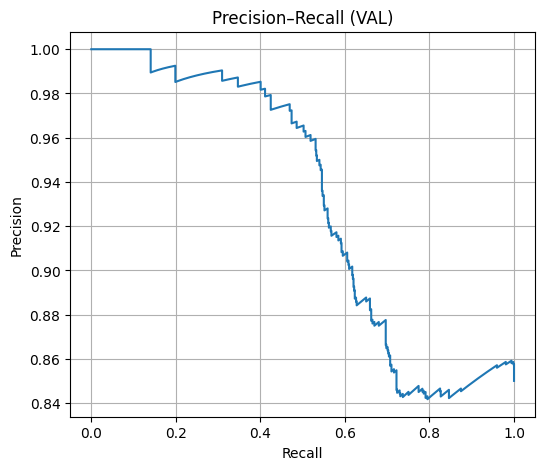


[TEST] ⭐ Mejor threshold por F2: t=0.050 | P=0.817 | R=0.974 | F1=0.889 | F2=0.938

[TEST] --- BASELINE t=0.050 ---
[[ 65 126]
 [ 15 564]]
              precision    recall  f1-score   support

      normal      0.812     0.340     0.480       191
       hurto      0.817     0.974     0.889       579

    accuracy                          0.817       770
   macro avg      0.815     0.657     0.684       770
weighted avg      0.816     0.817     0.787       770


[TEST] --- BASELINE t=0.550 ---
[[186   5]
 [476 103]]
              precision    recall  f1-score   support

      normal      0.281     0.974     0.436       191
       hurto      0.954     0.178     0.300       579

    accuracy                          0.375       770
   macro avg      0.617     0.576     0.368       770
weighted avg      0.787     0.375     0.334       770


[TEST] --- POST (smoothing+histéresis+minDur) con t_hi=0.050, t_lo=0.000 ---
[[191   0]
 [  0 579]]
              precision    recall  f1-score   sup

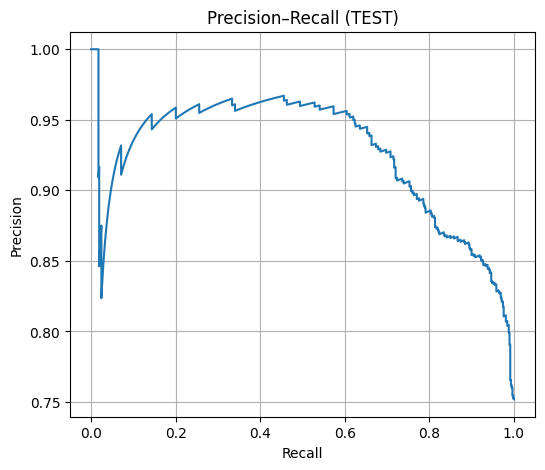


Archivos guardados en: /content/eval_out
 - /content/eval_out/val_operating_threshold.json
 - /content/eval_out/val_threshold_sweep.csv
 - /content/eval_out/test_threshold_sweep.csv
 - /content/eval_out/test_operating_threshold.json


In [ ]:
# ============================================
# EVALUACIÓN Colab – R3D-18 + Barrido + Runtime-like POST
# ============================================
import os, re, csv, json
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch, torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.video import r3d_18
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_recall_curve, precision_recall_fscore_support
)
import cv2

# -----------------------------
# CONFIG
# -----------------------------
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
BASE_DIR   = "/content/tesisV2/cortos/video_clips_192"
VAL_CSV    = f"{BASE_DIR}/val.csv"
TEST_CSV   = f"{BASE_DIR}/test.csv"
CKPT_PATH  = "/content/drive/MyDrive/tesisV2/models/r3d18_shoplifting_ft_l34_bestF1.pt"

NUM_CLASSES   = 2
CLIP_LEN      = 16
RESIZE        = 128
CROP          = 112
BATCH_SIZE    = 8

# Barrido de thresholds
T_MIN, T_MAX, T_STEPS = 0.05, 0.95, 37  # paso ~0.025
FIXED_T = 0.55                           # opcional, se reporta además de "best F2"

# POST tipo runtime
HOP_SECONDS    = 0.5     # si tus clips tienen otro hop, cambiá esto
SMOOTH_K       = 5       # ~2.5 s si hop=0.5
HYST_WIDTH     = 0.08    # THR_LO = THR_HI - HYST_WIDTH
MIN_EVENT_SEC  = 0.60
COOLDOWN_SEC   = 2.0
ABS_FLOOR_PEAK = 0.48    # si querés aplicar pisos (opcional)
ABS_FLOOR_MEAN = 0.36
BASE_MIN_FRAC  = 0.18

OUT_DIR = Path("/content/eval_out"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# -----------------------------
# DATASET
# -----------------------------
val_spatial = T.Compose([T.Resize((RESIZE, RESIZE)), T.CenterCrop(CROP)])

class SimpleVideoEval(Dataset):
    def __init__(self, csv_path, base_dir):
        self.items=[]; self.base_dir=base_dir
        with open(csv_path, newline='') as f:
            r = csv.reader(f)
            for row in r:
                if not row: continue
                head=row[0].strip().lower()
                if head in ("path","ruta","file","filename"):  # header
                    continue
                path=row[0].strip()
                y = 0 if str(row[1]).lower() in ("0","normal") else 1
                if not path.startswith("/"):
                    cand=os.path.join(base_dir, path)
                    if os.path.exists(cand):
                        path=cand
                    else:
                        sub="normal" if y==0 else "shoplifting"
                        path=os.path.join(base_dir, sub, path)
                self.items.append((path, y))
        # Kinetics norm
        self.mean = torch.tensor([0.43216, 0.394666, 0.37645]).view(1,3,1,1)
        self.std  = torch.tensor([0.22803, 0.22145, 0.216989]).view(1,3,1,1)

    def __len__(self): return len(self.items)

    def _read_video_cv2(self, path):
        cap=cv2.VideoCapture(str(path))
        frames=[]
        while True:
            ok, fr=cap.read()
            if not ok: break
            fr=cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            frames.append(fr)
        cap.release()
        if len(frames)==0:
            raise RuntimeError(f"No se pudo leer: {path}")
        T_total=len(frames)
        if T_total>=CLIP_LEN:
            start=max(0,(T_total-CLIP_LEN)//2)  # centro
            frames=frames[start:start+CLIP_LEN]
        else:
            last=frames[-1]
            frames=frames + [last]*(CLIP_LEN-T_total)
        arr=np.stack(frames, axis=0)                 # [T,H,W,3] uint8
        ten=torch.from_numpy(arr).permute(0,3,1,2)   # [T,3,H,W]
        return ten

    def __getitem__(self, idx):
        path,y=self.items[idx]
        clip=self._read_video_cv2(path)                  # [T,3,H,W]
        clip=torch.stack([val_spatial(fr) for fr in clip])
        clip=clip.float()/255.0
        clip=(clip - self.mean)/self.std
        clip=clip.permute(1,0,2,3).contiguous()          # [3,T,H,W]
        return clip, torch.tensor(y, dtype=torch.long), path

# -----------------------------
# MODELO
# -----------------------------
def build_model():
    try:
        model=r3d_18(weights="KINETICS400_V1")
    except TypeError:
        model=r3d_18(pretrained=True)
    in_feats=model.fc.in_features
    model.fc=nn.Sequential(nn.Dropout(0.5), nn.Linear(in_feats, NUM_CLASSES))
    sd=torch.load(CKPT_PATH, map_location="cpu")
    state_dict = sd["model"] if isinstance(sd, dict) and "model" in sd else sd
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    print("Checkpoint cargado:", CKPT_PATH)
    if missing or unexpected:
        print("Missing:", missing, "Unexpected:", unexpected)
    return model.to(DEVICE).eval()

# -----------------------------
# INFERENCIA
# -----------------------------
@torch.no_grad()
def infer_loader(model, loader):
    probs_all, ys_all, paths_all = [], [], []
    soft=nn.Softmax(dim=1)
    for x,y,paths in loader:
        x=x.to(DEVICE, non_blocking=True)
        logits=model(x)
        probs=soft(logits)[:,1].detach().cpu().numpy()
        probs_all.append(probs)
        ys_all.append(y.numpy())
        paths_all.extend(list(paths))
    return np.concatenate(probs_all), np.concatenate(ys_all), paths_all

# -----------------------------
# HELPERS POST
# -----------------------------
def moving_avg(a,k):
    if k<=1: return a
    pad=(k-1)//2
    a_pad=np.pad(a,(pad,pad),mode='edge')
    ker=np.ones(k)/k
    return np.convolve(a_pad,ker,mode='valid')

def hysteresis_events(sm_probs, thr_on, thr_off, hop_s, min_event_s, cooldown_s,
                      abs_floor_peak=None, abs_floor_mean=None, base_min_frac=None):
    active=False; start=None; events=[]
    above_mid_frac = []
    mid_thr = max(thr_off, 0.85*thr_on)

    # opcional: contabilidad de “fracción por encima del mid”
    for i,p in enumerate(sm_probs):
        above_mid_frac.append(1.0 if p>=mid_thr else 0.0)

    for i,p in enumerate(sm_probs):
        if not active and p>=thr_on:
            active=True; start=i
        elif active and p<=thr_off:
            end=i
            seg = sm_probs[start:end+1] if end>=start else sm_probs[start:start+1]
            dur_ok = ((end-start+1)*hop_s) >= min_event_s
            # filtros opcionales estilo runtime:
            peak_ok = True if abs_floor_peak is None else (seg.max() >= abs_floor_peak)
            mean_ok = True if abs_floor_mean is None else (seg.mean() >= abs_floor_mean)
            frac_ok = True
            if base_min_frac is not None:
                sl = above_mid_frac[start:end+1]
                frac_ok = (np.mean(sl) >= base_min_frac) if len(sl)>0 else False
            if dur_ok and peak_ok and mean_ok and frac_ok:
                events.append([start, end])
            active=False

    if active:
        end=len(sm_probs)-1
        seg = sm_probs[start:end+1]
        dur_ok = ((end-start+1)*hop_s) >= min_event_s
        peak_ok = True if abs_floor_peak is None else (seg.max() >= abs_floor_peak)
        mean_ok = True if abs_floor_mean is None else (seg.mean() >= abs_floor_mean)
        frac_ok = True
        if base_min_frac is not None:
            sl = above_mid_frac[start:end+1]
            frac_ok = (np.mean(sl) >= base_min_frac) if len(sl)>0 else False
        if dur_ok and peak_ok and mean_ok and frac_ok:
            events.append([start,end])

    # merge por cooldown
    merged=[]
    for s,e in events:
        if not merged: merged.append([s,e])
        else:
            ps,pe=merged[-1]
            if (s-pe)*hop_s < cooldown_s:
                merged[-1][1]=e
            else:
                merged.append([s,e])
    return merged

def events_to_clip_labels(n, events):
    y=np.zeros(n, dtype=np.int64)
    for s,e in events: y[s:e+1]=1
    return y

_idx_pat = re.compile(r"(?:_|-)(\d{1,6})(?=\D*$)")
def infer_vid_and_idx(path):
    p=str(path); stem=Path(p).stem
    m=_idx_pat.search(stem)
    if m:
        clip_idx=int(m.group(1))
        video_id=stem[:m.start()] or Path(p).parent.name
    else:
        video_id=Path(p).parent.name
        clip_idx=stem
    return video_id, clip_idx

def natkey(x):
    try: return int(x)
    except: return x

# -----------------------------
# EVAL: Barrido + Reports
# -----------------------------
def sweep_thresholds(y_true, probs, t_list):
    rows=[]
    for t in t_list:
        y_pred = (probs >= t).astype(int)
        P, R, F1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
        beta2 = 2.0
        F2 = (1+beta2**2)*P*R/((beta2**2)*P + R + 1e-12) if (P+R)>0 else 0.0
        rows.append([t,P,R,F1,F2])
    df = pd.DataFrame(rows, columns=["t","precision","recall","f1","f2"])
    return df

def evaluate_split(split_name, csv_path, model):
    if not os.path.exists(csv_path):
        print(f"[{split_name}] No existe:", csv_path); return

    ds=SimpleVideoEval(csv_path, BASE_DIR)
    dl=DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    probs, ys, paths = infer_loader(model, dl)

    # ---------- Barrido base (clip-level) ----------
    t_list = np.linspace(T_MIN, T_MAX, T_STEPS)
    sweep = sweep_thresholds(ys, probs, t_list)
    sweep_path = OUT_DIR / f"{split_name.lower()}_threshold_sweep.csv"
    sweep.to_csv(sweep_path, index=False)

    best = sweep.sort_values("f2", ascending=False).iloc[0].to_dict()
    t_best = float(best["t"])
    print(f"\n[{split_name}] ⭐ Mejor threshold por F2: t={t_best:.3f} | P={best['precision']:.3f} | R={best['recall']:.3f} | F1={best['f1']:.3f} | F2={best['f2']:.3f}")

    # ---------- Baseline (umbral directo) ----------
    def report_for_threshold(name_t, t):
        y_pred = (probs >= t).astype(int)
        cm = confusion_matrix(ys, y_pred, labels=[0,1])
        rep = classification_report(ys, y_pred, target_names=["normal","hurto"], digits=3)
        print(f"\n[{split_name}] --- BASELINE t={name_t} ---")
        print(cm); print(rep)
        return cm, rep

    cm_best, rep_best = report_for_threshold(f"{t_best:.3f}", t_best)
    if FIXED_T is not None:
        report_for_threshold(f"{FIXED_T:.3f}", float(FIXED_T))

    # ---------- POST tipo runtime (video-level, luego clip labels) ----------
    # usamos THR_HI/LO a partir de t_best
    thr_hi = t_best
    thr_lo = max(0.0, thr_hi - HYST_WIDTH)

    buckets=defaultdict(list)
    for p,pr,yv in zip(paths, probs, ys):
        vid,idx=infer_vid_and_idx(p)
        buckets[vid].append((idx, float(pr), int(yv)))

    y_true_all=[]; y_pred_all=[]
    for vid, triples in buckets.items():
        triples.sort(key=lambda t: natkey(t[0]))
        pv=np.array([t[1] for t in triples], float)
        yv=np.array([t[2] for t in triples], int)
        n=len(pv)
        sm=moving_avg(pv, SMOOTH_K)
        evs=hysteresis_events(
            sm, thr_hi, thr_lo,
            HOP_SECONDS, MIN_EVENT_SEC, COOLDOWN_SEC,
            abs_floor_peak=ABS_FLOOR_PEAK, abs_floor_mean=ABS_FLOOR_MEAN, base_min_frac=BASE_MIN_FRAC
        )
        yhat=events_to_clip_labels(n, evs)
        y_true_all.append(yv); y_pred_all.append(yhat)

    y_true_all=np.concatenate(y_true_all) if y_true_all else ys
    y_pred_all=np.concatenate(y_pred_all) if y_pred_all else (probs>=thr_hi).astype(int)

    cm_post = confusion_matrix(y_true_all, y_pred_all, labels=[0,1])
    rep_post = classification_report(y_true_all, y_pred_all, target_names=["normal","hurto"], digits=3)

    print(f"\n[{split_name}] --- POST (smoothing+histéresis+minDur) con t_hi={thr_hi:.3f}, t_lo={thr_lo:.3f} ---")
    print(cm_post); print(rep_post)

    # ---------- Guardar JSON de operating point ----------
    op = dict(split=split_name, threshold=float(t_best),
              precision=float(best["precision"]),
              recall=float(best["recall"]),
              f1=float(best["f1"]),
              f2=float(best["f2"]),
              thr_lo=float(thr_lo))
    with open(OUT_DIR / f"{split_name.lower()}_operating_threshold.json","w") as f:
        json.dump(op, f, indent=2)

    # ---------- PR Curve ----------
    prec, rec, thr = precision_recall_curve(ys, probs)
    plt.figure(figsize=(6,5))
    plt.plot(rec, prec)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision–Recall ({split_name})")
    plt.grid(True)
    plt.show()

    # ---------- Devolver por si querés usar luego ----------
    return dict(
        probs=probs, ys=ys, paths=paths,
        sweep=sweep, best=op,
        cm_base=cm_best, rep_base=rep_best,
        cm_post=cm_post, rep_post=rep_post
    )

# -----------------------------
# RUN
# -----------------------------
print("CUDA disponible:", torch.cuda.is_available())
model = build_model()

results = {}
for split_name, csv_path in [("VAL", VAL_CSV), ("TEST", TEST_CSV)]:
    res = evaluate_split(split_name, csv_path, model)
    results[split_name] = res

print("\nArchivos guardados en:", str(OUT_DIR))
for p in OUT_DIR.iterdir():
    print(" -", p)


In [ ]:
events_raw = merge_alert_segments(win_times, states, probs_s)
events_raw = merge_close_events(events_raw, gap_s=0.5)
events, inspected = filter_events(events_raw, win_times, P_RAW, P_SMO,
                                  MIN_DUR, MIN_PEAK, MIN_MEAN, MID_THR, MIN_FRAC)

# Export de eventos y picos (clips .mp4 con re-encode compatible)
clips = cut_events_to_clips(VIDEO_IN, events, out_dir, pad_s=PAD_S, max_dur_s=MAX_DUR, reencode=True)
peaks_extra = pick_all_peaks_above(P_SMO, win_times, min_prob=min_prob_for_peaks, min_gap_s=PEAK_MIN_GAP_S)
clips_peaks = cut_peak_centered_clips(VIDEO_IN, peaks_extra, out_dir_peaks, clip_dur_s=PEAK_CLIP_DUR_S, reencode=True)

# Registros para auditoría
json.dump([...], open(OUT_JSON,"w"), indent=2)   # por ventana
json.dump(events, open(OUT_EVENTS,"w"), indent=2) # por evento


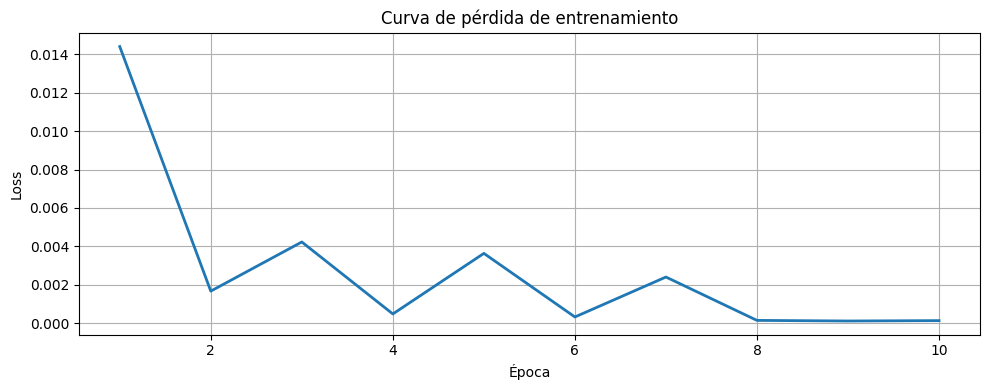

In [8]:
import json
import matplotlib.pyplot as plt

# Cambiá esto según tu ruta en Drive
with open("/content/drive/MyDrive/tesisV2/models/exp_l234_fullrun/trainlog.json", "r") as f:
    history = json.load(f)

epochs = [row["epoch"] for row in history]
train_loss = [row["train_loss"] for row in history]

plt.figure(figsize=(10, 4))
plt.plot(epochs, train_loss, label="Pérdida entrenamiento", linewidth=2)
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Curva de pérdida de entrenamiento")
plt.grid(True)
plt.tight_layout()
plt.show()
